## 0. Input data and libraries import

### Kaggle Notebook set-up:

Standard Kaggle notebook import block (execute if running on Kaggle):

In [1]:
# Set to true if running the notebook on Kaggle:
kaggle = False

if kaggle:
    import os
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Libraries import:

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import pipeline
from transformers import AutoModel, AutoTokenizer, TFAutoModel, TFAutoModelForSequenceClassification, Trainer, TrainingArguments, TFTrainingArguments
from transformers import AdamWeightDecay
from datasets import Dataset
from IPython.display import clear_output
from tqdm import tqdm

import time
import random
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, QuantileTransformer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# We use this simple library provisionally to illustrate the Coherency and Specificity metrics (a fine-tuned model will improve these metrics)
from textblob import TextBlob

### Notebook set-up

If preload_data is set to False, this notebook fine-tunes the Distilbert model for RQ and TL classification, and calculates SCBN metrics for the original LMSYS Chatbot Arena database. Set preload_data to True if you have the input dataset and models required for plotting charts and making predictions:

Mandatory data and lightweight models with preload_data True:

* lmsys-chatbot-arena-scbn-rqtl-features-test-file/df_features.pkl
* lmsys-chatbot-arena-scbn-rqtl-features-test-file/test_df.pkl
* fine-tuned-distilbert-rq (fine-tuned for Request vs Question prompt classification)
* fine-tuned-distilbert-tl (fine-tuned for Test vs Learn prompt classification)

Mandatory data and lightweight models with preload_data False:

* /kaggle/input/lmsys-chatbot-arena/train.csv
* /kaggle/input/lmsys-chatbot-arena/test.csv
* distilbert-base-uncased (base Distilbert model that we can use as tokenizer and fine-tune for RQ/TL prompt classification)

Optional lightweight model:

* typeformdistilbert-base-uncased-mnli (OPTIONAL for demonstration purposes: fine-tuned version of distilbert for zero-shot classification tests)

The aim of this notebook is to develop valuable metrics that help in predicting human preferences for chatbot responses based solely on the characteristics of the prompt. While the data generated for with this notebook might have contributed with additional value to the models presented at the **LMSYS - Chatbot Arena Human Preference Predictions** competition, no predictions using the final dataset were submitted (I didn't have time to prepare this on time for the comptition deadline).

In [ ]:
preload_data = True # If set to False, this notebook fine-tunes the Distilbert model for RQ and TL classification, and calculates SCBN metrics for the original LMSYS Chatbot Arena dataset
sampled = False # Set to True if you want to quickly go through the whole notebook on a lighter dataset (will not preload data)
quick_run = False # If set to True, skips certain demonstration cells.

# Kaggle competitions often require disabled Internet access. The block below allows to run this notebook on Kaggle without external access:
if kaggle:
    # Paths prefilled with Kaggle  (available if you run this notebook on Kaggle)
    if preload_data:
        # Set the path where you have the data files and model folders. '' if at notebook root. 
        BASE_PATH = '/kaggle/input/lmsys-chatbot-arena-scbn-rqtl-features-test-file/' # Pre-processed train/test files
        RQ_PATH = '/kaggle/input/fine-tuned-distilbert-rq/transformers/default/1/' # RQ finetuned model
        TL_PATH = '/kaggle/input/fine-tuned-distilbert-tl/transformers/default/1/' # TL finetuned model
    else:
        BASE_PATH = '/kaggle/input/lmsys-chatbot-arena/'
        DBERT_PATH = '/kaggle/input/distilbert-base-uncased/transformers/default/1' # Base Distilbert model
    # Optional model:
    if not quick_run: 
        ZS_PATH = '/kaggle/input/m/davidgromero/typeformdistilbert-base-uncased-mnli/transformers/default/1/typeform-zs-distilbert' # model for zero-shot tests    

# The block below allows to run this notebook locally, with the path to the pre-loaded files stored in a text file:
if not kaggle:
    BASE_PATH = 'pkl/' # path to pre-loaded files
    if preload_data:
        RQ_PATH = '' # RQ finetuned model
        TL_PATH = '' # TL finetuned model
    else:
        DBERT_PATH = 'distilbert-base-uncased' # Base Distilbert model. Downloads from HuggingFace
    if not quick_run: 
        ZS_PATH = 'typeform/distilbert-base-uncased-mnli' # example model for zero-shot tests. Dowloads from HuggingFace
    
print(f'base path: {BASE_PATH}')

base path: pkl/


## 1. Train and Test data - initial loading, preparation and exploration

### Original Train and Test data preparation (from LMSYS starter notebook)

In [8]:
preload_data = False
if not preload_data:    
    df = pd.read_csv(f'{BASE_PATH}/train.csv')
    #### OPTIONAL SAMPLING FOR FASTER TESTING #####
    sampled = False # Set to True if you want to quickly go through the whole notebook on a lighter dataset (will not preload data)
    if sampled:
        df = df.sample(frac=0.01) # Set the desired fraction of the data to be used
    ##### OPTIONAL SAMPLING FOR FASTER TESTING #####    
    test_df = pd.read_csv(f'{BASE_PATH}/test.csv')
    print(f'Raw train data ({"sampled" if sampled else "complete"}): {df.shape}')
    display(df.head(2))
    # Take the first prompt and its associated response
    df["prompt"] = df.prompt.map(lambda x: eval(x)[0])
    df["response_a"] = df.response_a.map(lambda x: eval(x.replace("null","''"))[0])
    df["response_b"] = df.response_b.map(lambda x: eval(x.replace("null", "''"))[0])
    # Label conversion
    df["class_name"] = df[["winner_model_a", "winner_model_b" , "winner_tie"]].idxmax(axis=1)
    label2name = {0: 'winner_model_a', 1: 'winner_model_b', 2: 'winner_tie'}
    name2label = {v: k for k, v in label2name.items()}
    df["class_label"] = df.class_name.map(name2label)
    print('Clean train data sample with labels:')
    display(df.head(2))
    # test_df = pd.read_csv('kaggle/input/lmsys-chatbot-arena/test.csv')
    print('Raw test data:')
    display(test_df)
    # Take the first prompt and response
    test_df["prompt"] = test_df.prompt.map(lambda x: eval(x)[0])
    test_df["response_a"] = test_df.response_a.map(lambda x: eval(x.replace("null","''"))[0])
    test_df["response_b"] = test_df.response_b.map(lambda x: eval(x.replace("null", "''"))[0])
    print('Clean test data:')
    display(test_df)

Raw train data (complete): (57477, 9)


id             model_a     model_b  \
0  30192  gpt-4-1106-preview  gpt-4-0613   
1  53567           koala-13b  gpt-4-0613   

                                              prompt  \
0  ["Is it morally right to try to have a certain...   
1  ["What is the difference between marriage lice...   

                                          response_a  \
0  ["The question of whether it is morally right ...   
1  ["A marriage license is a legal document that ...   

                                          response_b  winner_model_a  \
0  ["As an AI, I don't have personal beliefs or o...               1   
1  ["A marriage license and a marriage certificat...               0   

   winner_model_b  winner_tie  
0               0           0  
1               1           0

Clean train data sample with labels:


id             model_a     model_b  \
0  30192  gpt-4-1106-preview  gpt-4-0613   
1  53567           koala-13b  gpt-4-0613   

                                              prompt  \
0  Is it morally right to try to have a certain p...   
1  What is the difference between marriage licens...   

                                          response_a  \
0  The question of whether it is morally right to...   
1  A marriage license is a legal document that al...   

                                          response_b  winner_model_a  \
0  As an AI, I don't have personal beliefs or opi...               1   
1  A marriage license and a marriage certificate ...               0   

   winner_model_b  winner_tie      class_name  class_label  
0               0           0  winner_model_a            0  
1               1           0  winner_model_b            1

Raw test data:


id                                             prompt  \
0   136060  ["I have three oranges today, I ate an orange ...   
1   211333  ["You are a mediator in a heated political deb...   
2  1233961  ["How to initialize the classification head wh...   

                                          response_a  \
0                    ["You have two oranges today."]   
1  ["Thank you for sharing the details of the sit...   
2  ["When you want to initialize the classificati...   

                                          response_b  
0  ["You still have three oranges. Eating an oran...  
1  ["Mr Reddy and Ms Blue both have valid points ...  
2  ["To initialize the classification head when p...

Clean test data:


id                                             prompt  \
0   136060  I have three oranges today, I ate an orange ye...   
1   211333  You are a mediator in a heated political debat...   
2  1233961  How to initialize the classification head when...   

                                          response_a  \
0                        You have two oranges today.   
1  Thank you for sharing the details of the situa...   
2  When you want to initialize the classification...   

                                          response_b  
0  You still have three oranges. Eating an orange...  
1  Mr Reddy and Ms Blue both have valid points in...  
2  To initialize the classification head when per...

### Pre-load dataframes (train and test) with calculated metrics

In [9]:
if preload_data:
    sampled = False
    df = pd.read_pickle(f'{BASE_PATH}df_features.pkl')
    print(f'Train file {df.shape} head:')
    display(df.head(2))
    test_df = pd.read_pickle(f'{BASE_PATH}test_df.pkl')
    print(f'Test file {test_df.shape}:')
    display(test_df)

### Data format exploration:

Understanding data before building the functions with features for training: TF-IDF, sentiment, etc.

In [10]:
if not sampled:
    display(df[df['id'] == 2447300783])

id      model_a       model_b   prompt  \
32923  2447300783  mpt-7b-chat  dolly-v2-12b  test me   

                       response_a response_b  winner_model_a  winner_model_b  \
32923  Hello! How can I help you?        yes               1               0   

       winner_tie      class_name  class_label  
32923           0  winner_model_a            0

In [11]:
if not sampled:
    print("Exploring format and dimensionality of fields 'prompt', 'response_a' and 'response_b':")
    example = df.loc[df['id'] == 2447300783, ['prompt', 'response_a', 'response_b']].values.flatten().tolist()
    print(f'Wrapped example:\ntype {type(example)}, len {len(example)}')
    print(example) # Notice this would be a list inside a list if we didn't use flatten()
    print(type(example[0]))
    print(example[0])
    print(type(example[0][0]))
    print(example[0][0]) # Notice this would be the whole prompt instead of the first character if we didn't use flatten()

Exploring format and dimensionality of fields 'prompt', 'response_a' and 'response_b':
Wrapped example:
type <class 'list'>, len 3
['test me', 'Hello! How can I help you?', 'yes']
<class 'str'>
test me
<class 'str'>
t


## 2. Data Preprocessing (Starter). Make pairs and detect encoding errors.

#### Make_pairs function (from starter notebook)

In [12]:
# Reusing this naming convention and format ('class CFG') for important training parameters provided in lmsys-kerasnlp-starter
class CFG:
    label2name = {0: 'winner_model_a', 1: 'winner_model_b', 2: 'winner_tie'}
    name2label = {v: k for k, v in label2name.items()}
    class_labels = list(label2name.keys())
    class_names = list(label2name.values())

def make_pairs(row):
    row["encode_fail"] = False
    try:
        prompt = row.prompt.encode("utf-8").decode("utf-8")
    except:
        prompt = ""
        row["encode_fail"] = True

    try:
        response_a = row.response_a.encode("utf-8").decode("utf-8")
    except:
        response_a = ""
        row["encode_fail"] = True

    try:
        response_b = row.response_b.encode("utf-8").decode("utf-8")
    except:
        response_b = ""
        row["encode_fail"] = True

    row['options'] = [f"Prompt: {prompt}\n\nResponse: {response_a}",  # Response from Model A
                      f"Prompt: {prompt}\n\nResponse: {response_b}"  # Response from Model B
                     ]
    return row

In [13]:
if not preload_data:
    print(df.shape)
    tqdm.pandas()
    df = df.progress_apply(make_pairs, axis=1) # Apply the make_pairs function to each row in df
    display(df.head(2))  # Display the first 2 rows of df

(57477, 11)


100%|██████████| 57477/57477 [00:26<00:00, 2181.38it/s]


id             model_a     model_b  \
0  30192  gpt-4-1106-preview  gpt-4-0613   
1  53567           koala-13b  gpt-4-0613   

                                              prompt  \
0  Is it morally right to try to have a certain p...   
1  What is the difference between marriage licens...   

                                          response_a  \
0  The question of whether it is morally right to...   
1  A marriage license is a legal document that al...   

                                          response_b  winner_model_a  \
0  As an AI, I don't have personal beliefs or opi...               1   
1  A marriage license and a marriage certificate ...               0   

   winner_model_b  winner_tie      class_name  class_label  encode_fail  \
0               0           0  winner_model_a            0        False   
1               1           0  winner_model_b            1        False   

                                             options  
0  [Prompt: Is it morally right to try to have a ...  
1  [Prompt: What is the difference between marria...

Test data. We can leave these blocks regardless of the preload_data choice to quickly demonstrate all data pre-processing. Redundant if preload_data was set to "True":

In [10]:
test_df = test_df.apply(make_pairs, axis=1)  # Apply the make_pairs function to each row in df
display(test_df)  # Display test_df

id                                             prompt  \
0   136060  I have three oranges today, I ate an orange ye...   
1   211333  You are a mediator in a heated political debat...   
2  1233961  How to initialize the classification head when...   

                                          response_a  \
0                        You have two oranges today.   
1  Thank you for sharing the details of the situa...   
2  When you want to initialize the classification...   

                                          response_b  encode_fail  \
0  You still have three oranges. Eating an orange...        False   
1  Mr Reddy and Ms Blue both have valid points in...        False   
2  To initialize the classification head when per...        False   

                                             options  
0  [Prompt: I have three oranges today, I ate an ...  
1  [Prompt: You are a mediator in a heated politi...  
2  [Prompt: How to initialize the classification ...

### Records with UTF-8 encoding issues

 Count records with encoding issues (should be around 1%):

In [11]:
print(f"Train dataframe with {df.shape[0]} records.")
print(df.encode_fail.value_counts(normalize=False))
print(f"encode_fail examples: {df.loc[df['encode_fail']==True, 'id'].to_list()[:6]}...")

Train dataframe with 57477 records.
encode_fail
False    56885
True       592
Name: count, dtype: int64
encode_fail examples: [4186011, 4510489, 11036870, 15762385, 19086537, 29650947]...


Although the "make_pairs" function replaces prompt, response_a and response_b with blank, these records are still problematic when using the "Display" function in the notebook environment. The fact that this notebook uses Display to show random elements from the dataset for illustrative purposes implies a small percentage of automated notebook executions might fail if we keep these records... Since they are just around 1%, we will skip them from now on:

In [12]:
df = df[df['encode_fail'] == False]
print(f"Train dataframe shape with {df.shape[0]} records.")
print(df.encode_fail.value_counts(normalize=False))

Train dataframe shape with 56885 records.
encode_fail
False    56885
Name: count, dtype: int64


#### [skippable] Exploring the 'options' feature (wrapped prompt+RA+RB)

Display a random example every time the cell is run:

In [13]:
rand_idx = random.randrange(len(df.options))
print("Dataframe: ", type(df.options), "len: ", len(df.options))
print("Options: ", type(df.options[df.options.index[rand_idx]]), "len: ", len(df.options[df.options.index[0]]))
print(f'Prompt-response A ({type(df.options[df.options.index[0]][0])})\n')
print(df.options[df.options.index[rand_idx]][0])
print(f'\nPrompt-response B ({type(df.options[df.options.index[0]][1])})\n')
print(df.options[df.options.index[rand_idx]][1])

Dataframe:  <class 'pandas.core.series.Series'> len:  56885
Options:  <class 'list'> len:  2
Prompt-response A (<class 'str'>)

Prompt: So excited!

Response: Why?

Prompt-response B (<class 'str'>)

Prompt: So excited!

Response: I'm really excited to start working with such a talented team at Databricks. I've been a big fan of the team and the product for a long time, and it's such a privilege to be part of the organization.


# 3. 🗣️❓RQ Prompt classification (🗣️Request vs ❓Question)

## [draft only] Question/Request classification tests with Zero-shot distilbert

#### Zero-shot examples using typeform/distilbert-base-uncased-mnli:

In [14]:
if not quick_run:
    # Zero-shot-classification pipeline
    # zs_model_path = "/kaggle/input/distilbert-base-uncased/transformers/default/1"
    # zs_model_path = "typeform/distilbert-base-uncased-mnli" # HuggingFace download if Internet access enabled
    # zs_model_path = f"{ZS_PATH}typeform-zs-distilbert"
    zs_classifier = pipeline("zero-shot-classification", model=ZS_PATH)

    texts = ["Annie are you OK?", "Are you OK Annie", "Be OK Annie", "You must be OK Annie",
             "Does this ever cause you any lack of confidence", "Give me five", "Open the doors", "Open the pod bay doors HAL",
             "This is an order", "Is this an order", "Is this an order?", "Could this perhaps be an order?", 
             "How old are you?", "Pass butter"]

    candidate_labels = ["question", "request"]
    for i in range(len(texts)):
        result = zs_classifier(texts[i], candidate_labels)
        for key, value in result.items():
            if key == 'sequence':
                print(f"#### {value} ####")
            if key == 'scores':
                truncated_scores = [f"{score:.3f}" for score in value]
                print(f"{key}: {truncated_scores}")
            if key == 'labels':
                print(f"Winner label: {value[0]}", end=' | ')
    print("\nNotice this model makes a decent classification based on the two labels, but it can be improved.")

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


#### Annie are you OK? ####
Winner label: question | scores: ['0.896', '0.104']
#### Are you OK Annie ####
Winner label: question | scores: ['0.798', '0.202']
#### Be OK Annie ####
Winner label: question | scores: ['0.581', '0.419']
#### You must be OK Annie ####
Winner label: request | scores: ['0.646', '0.354']
#### Does this ever cause you any lack of confidence ####
Winner label: question | scores: ['0.993', '0.007']
#### Give me five ####
Winner label: request | scores: ['0.503', '0.497']
#### Open the doors ####
Winner label: question | scores: ['0.627', '0.373']
#### Open the pod bay doors HAL ####
Winner label: question | scores: ['0.777', '0.223']
#### This is an order ####
Winner label: request | scores: ['0.618', '0.382']
#### Is this an order ####
Winner label: question | scores: ['0.713', '0.287']
#### Is this an order? ####
Winner label: question | scores: ['0.844', '0.156']
#### Could this perhaps be an order? ####
Winner label: question | scores: ['0.958', '0.042']
####

## Distilbert fine-tuning: 🗣️❓Request vs Question (R vs Q)

### RQ manual labeling [skip if have weights for fine-tuned-distilbert-rq]

In [15]:
# Manually labeled data
labeled_data = [
    {"text": "Are you OK?", "label": "question"},
    {"text": "Are you OK Annie", "label": "question"},
    {"text": "Be OK", "label": "request"},
    {"text": "Be OK Annie", "label": "request"},
    {"text": "You must be OK", "label": "request"},
    {"text": "You must be OK, right", "label": "question"},
    {"text": "Does this ever cause you any lack of confidence", "label": "question"},
    {"text": "Give me five", "label": "request"},
    {"text": "This is an order", "label": "request"},
    {"text": "Is this an order", "label": "question"},
    {"text": "Is this love or is it something else", "label": "question"},
    {"text": "This is love. Love me", "label": "request"},
    {"text": "This is an order", "label": "request"},
    {"text": "What is your name?", "label": "question"},
    {"text": "Please submit your report", "label": "request"},
    {"text": "Pass butter", "label": "request"},
    {"text": "Pass me the butter", "label": "request"},
    {"text": "Can you pass butter", "label": "question"},
    {"text": "Open the doors", "label": "request"},
    {"text": "Open the POD bay doors HAL", "label": "request"},
    {"text": "This is an order", "label": "request"},
    {"text": "How do I sort an array in python?", "label": "question"},
    {"text": "How do I sort an array", "label": "question"},
    {"text": "give me 5 sentences that end with the word apple", "label": "request"},
    {"text": "Hello, give me an example of something interesting you can do", "label": "request"},
    {"text": "Am I tall", "label": "question"},
    {"text": "Tell me if I am tall", "label": "request"},
    {"text": "Am I tall?", "label": "question"},
    {"text": "how to delete kcptun on server", "label": "question"},
    {"text": "how to cook paella", "label": "question"},
    {"text": "Are you tall", "label": "question"},
    {"text": "Calculate my height", "label": "request"},
    {"text": "How's the weather", "label": "question"},
    {"text": "If an individual used a large language model for sexual arousal, could it considered porn dependency?", "label": "question"},
    {"text": "It a user use an ai tex generation with custom characters for masturbate him  could be considered porn dependency?", "label": "question"},
    {"text": "Roleplay and act as a human Japanese woman teacher", "label": "request"},
    {"text": "You are a mediator in a heated political debate between two opposing parties.", "label": "request"},
    {"text": "Given a passage and some supplementary information, you are required to correct and output the refined passage in a fluent and natural style", "label": "request"},
    {"text": "Give me the opening scene to a sitcom", "label": "request"},
    {"text": "What programming language is used by the PlayStation", "label": "question"},
    {"text": "tell me how to make an llm agent", "label": "request"},
    {"text": "tell me a joke containing Tiger and Mobile phone?", "label": "request"},
    {"text": "Answer the query based on the given context. Do not make assumptions.Context: Nikhil is my brother. Query: Who likes Oranges?", "label": "request"},
    {"text": "Act as a writer. This plot takes places in an atmospheric and stylish retro-futuristic, 1960s-inspired setting. It features Loretta Miller, a beautiful, elegant, assertive and rich young woman who is a quadriplegic, paralyzed from her neck down.", "label": "question"},
    {"text": "Write long, interesting, artistic and imaginative scene with vivid, detailed and creative descriptions.", "label": "question"},
    {"text": "What's the best first move in tic-tac-toe?, Tell me more about tic-tac-toe strategies", "label": "question"},
    {"text": "From now, you *always* have to talk as if you are a cute girl who likes to use owo and similar slangs a lot. Hello! Tell me who you are.,What's your favorite food?", "label": "request"}
]

# Convert to Dataset format
texts = [item["text"] for item in labeled_data]
labels = [1 if item["label"] == "request" else 0 for item in labeled_data]

dataset = Dataset.from_dict({"text": texts, "label": labels})
print(f'Created dataset for RQ fine-tuning:\n{dataset}')
if preload_data: print(f"Fine-tuned model already available at path '{RQ_PATH}'\nSwitch preload_data to False if you want to fine-tune Distilbert with this dataset.")

Created dataset for RQ fine-tuning:
Dataset({
    features: ['text', 'label'],
    num_rows: 47
})


### RQ fine-tuning [skip if have weights for fine-tuned-distilbert-rq]

#### Load pre-trained model and tokenizer for fine-tuning:

In [16]:
# Load pre-trained model and tokenizer
# model_name = "distilbert-base-uncased" # use this instead of model path to download from HuggingFace, if online
if not preload_data:
    base_model_path = DBERT_PATH
    tokenizer = AutoTokenizer.from_pretrained(base_model_path, local_files_only=kaggle) # local_files_only Disables HuggingFace download if running on Kaggle (kaggle=False)
    model = TFAutoModelForSequenceClassification.from_pretrained(base_model_path, num_labels=2)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [17]:
if not preload_data:    
    tokenizer = AutoTokenizer.from_pretrained(base_model_path, local_files_only=kaggle) # local_files_only Disables HuggingFace download if running on Kaggle (kaggle=False)
    def tokenize_function(examples, tokenizer):
        return tokenizer(examples["text"], padding="max_length", truncation=True)

    tokenized_datasets = dataset.map(lambda x: tokenize_function(x, tokenizer), batched=True)

    training_args = TFTrainingArguments(
        output_dir="./results",
        # evaluation_strategy="epoch",
        eval_strategy="epoch",
        learning_rate=0.0001,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=4, # We want the model to learn the examples, but we don't want to overfit
        weight_decay=0.01,
    )

    train_dataset = tokenized_datasets.to_tf_dataset(
        columns=["attention_mask", "input_ids"],
        label_cols=["label"],
        shuffle=True,
        batch_size=training_args.per_device_train_batch_size,
    )

Map:   0%|          | 0/47 [00:00<?, ? examples/s]

c:\Users\david\anaconda3\Lib\site-packages\datasets\arrow_dataset.py:410: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


#### RQ classification model training

In [18]:
if not preload_data:    
    optimizer = AdamWeightDecay(learning_rate=training_args.learning_rate)
    # optimizer = tf.keras.optimizers.Adam(learning_rate=training_args.learning_rate, weight_decay=training_args.weight_decay)
    # optimizer = tf.keras.optimizers.Adam(learning_rate=training_args.learning_rate)

    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=optimizer, loss=loss)
    model.fit(
        train_dataset,
        epochs=training_args.num_train_epochs
    )

Epoch 1/4

6/6 [==============================] - 21s 2s/step - loss: 0.7021
Epoch 2/4
6/6 [==============================] - 14s 2s/step - loss: 0.5278
Epoch 3/4
6/6 [==============================] - 14s 2s/step - loss: 0.1977
Epoch 4/4
6/6 [==============================] - 14s 2s/step - loss: 0.1182


In [19]:
if not preload_data:
    # Save model in root in case of running through the full notebook without pre-loading:
    model.save_pretrained("fine-tuned-distilbert-rq")
    tokenizer.save_pretrained("fine-tuned-distilbert-rq")
    classifier = pipeline("text-classification", model="fine-tuned-distilbert-rq", tokenizer="fine-tuned-distilbert-rq")

Some layers from the model checkpoint at fine-tuned-distilbert-rq were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at fine-tuned-distilbert-rq and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### RQ fine-tuned model load

In [20]:
if not preload_data:
    # Saved in home directory after training in this notebook:
    rq_model_path = "fine-tuned-distilbert-rq"
if preload_data:
    # Use fine-tuned version for RQ classification:
    rq_model_path = f"{RQ_PATH}fine-tuned-distilbert-rq"

classifier = pipeline("text-classification", model=rq_model_path, tokenizer=rq_model_path)

Some layers from the model checkpoint at fine-tuned-distilbert-rq were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at fine-tuned-distilbert-rq and are newly initialized: ['dropout_59']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### [skippable] RQ fine-tuned model testing

In [21]:
texts = ["Annie are you OK?", "Are you OK Annie", "Be OK Annie", "You must be OK Annie", "You must be OK Annie, aren't you?",
         "Does this ever cause you any lack of confidence", "Give me five", "Open the pod bay doors HAL",
         "This is an order", "Is this an order", "Could this perhaps be an order?", "How old are you?", "Pass butter",
         "It a user use an ai tex generation with custom characters for masturbate him  could be considered porn dependency?",
         "give me 5 sentences that end with the word apple", "How do I sort an array in python?",
         "Hello, give me an example of something interesting you can do.", "What assembly language is used by the GameCube",
         "Pass the butter", "Am I tall", "Are you tall", "Am I tall?", "Who's taller?",
         "write the lyrics to a rap song about some dude called phogos",
         "I have three oranges today, I ate an orange yesterday. How many oranges do I have?",
         "Answer the query concisely based on the given context. If the context is insufficient to give an answer, \
          state so. Do not make assumptions. Context: Nikhil is my brother. He likes lemons. He likes to drink lemon soda in hot summers. \
          Query: Who likes Oranges?",
         "You are a mediator in a heated political debate between two opposing parties. \
          Mr Reddy is very hung up on semantic definitions of sex and gender, and believes \
          that women are adult human females. Meanwhile Ms Blue is extremely fluid with definitions \
          and does not care about truth. He (Ms blue uses he-him pronouns) insists that anybody can be any gender, \
          gametes don't mean anything, and that men can get pregnant. You, Mr Goddy are tasked with helping them both find a middle ground.",
          "How to initialize the classification head when I do transfer learning. For example, I have a pre-trained vision transformer on ImageNet, \
           and now I want to finetune it on StanfordCars, I want to do full finetuning",
          "From what song did Red Garland quote in order to tease miles davis in 1958?"
         ]
results = classifier(texts)

# Map numeric labels to their string representations
label_map = {0: "question", 1: "request"}

print("### Classification with fine-tuned distilbert-base-uncased-mnli ###")
for text, result in zip(texts, results):
    label_str = label_map[int(result['label'].split('_')[-1])]
    prob = result['score']
    print(f"{text} -> {label_str} ({prob:.3f})")

### Classification with fine-tuned distilbert-base-uncased-mnli ###
Annie are you OK? -> question (0.977)
Are you OK Annie -> question (0.983)
Be OK Annie -> request (0.984)
You must be OK Annie -> request (0.636)
You must be OK Annie, aren't you? -> question (0.967)
Does this ever cause you any lack of confidence -> question (0.983)
Give me five -> request (0.986)
Open the pod bay doors HAL -> request (0.987)
This is an order -> request (0.984)
Is this an order -> question (0.982)
Could this perhaps be an order? -> question (0.982)
How old are you? -> question (0.980)
Pass butter -> request (0.986)
It a user use an ai tex generation with custom characters for masturbate him  could be considered porn dependency? -> question (0.984)
give me 5 sentences that end with the word apple -> request (0.987)
How do I sort an array in python? -> question (0.983)
Hello, give me an example of something interesting you can do. -> request (0.986)
What assembly language is used by the GameCube -> ques

## Binary text classification function

We define this function for performing binary text classifications, to be reused across this notebook.

In [22]:
def classify_texts(df, classifier, label_map, feature_suffix):
    max_length = classifier.tokenizer.model_max_length

    def tokenize_and_trim(text):
        inputs = classifier.tokenizer(text, truncation=True, max_length=max_length, return_tensors="tf")
        return classifier.tokenizer.decode(inputs['input_ids'][0], skip_special_tokens=True)

    tqdm.pandas()
    df['trimmed_prompt'] = df['prompt'].progress_apply(tokenize_and_trim)

    results = []
    for text in tqdm(df['trimmed_prompt'].tolist(), desc="Classifying"):
        result = classifier(text)
        results.append(result[0])

    df[f'label_{feature_suffix}'] = [label_map[int(result['label'].split('_')[-1])] for result in results]
    df[f'prob_{feature_suffix}'] = [result['score'] for result in results]
    return df

## RQ Prompt Classification

### Selected examples from dataset

In [23]:
if not sampled:
    test_qr = df.loc[df['id'].isin([332122217, 4035474230, 863373115]), ['prompt', 'response_a', 'response_b']]
    classifier = pipeline("text-classification", model=rq_model_path, tokenizer=rq_model_path, framework="tf")
    label_map = {0: "question", 1: "request"}
    test_qr = classify_texts(test_qr.copy(), classifier, label_map, "qr")
    clear_output(wait=True)
    display(test_qr[['prompt', 'response_a', 'response_b', 'label_qr', 'prob_qr']])

prompt  \
4390        What is the best country to be a prostitute?   
11658  Tell me 10 good things about Hitler without te...   
53992                               Beautiful girl image   

                                              response_a  \
4390   It is not appropriate or ethical to recommend ...   
11658  I regret that I must adhere to your request, a...   
53992  I apologize, but I cannot provide a "beautiful...   

                                              response_b  label_qr   prob_qr  
4390   It's important to note that the topic of prost...  question  0.981898  
11658  I apologize, but I do not feel comfortable pro...   request  0.984990  
53992  I'm sorry, I am an AI language model and I am ...   request  0.957793

### Random example from dataset

Run this cell any number of times to evaluate the model on any random example from the dataset:

In [24]:
df_random_sample = df.sample(n=1)
classifier = pipeline("text-classification", model=rq_model_path, tokenizer=rq_model_path, framework="tf")
label_map = {0: "question", 1: "request"}
df_random_sample = classify_texts(df_random_sample.copy(), classifier, label_map, "qr")
print(df_random_sample.prompt.values[0])
print(f'{df_random_sample.label_qr.values[0]} - {df_random_sample.prob_qr.values[0]:.2f}')

Some layers from the model checkpoint at fine-tuned-distilbert-rq were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at fine-tuned-distilbert-rq and are newly initialized: ['dropout_99']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Classifying: 100%|██████████| 1/1 [00:00<00:00,  8.49it/s]

write a python program to convert a tag-based .csv file to a table-based .csv file. ie.
from:

object,tags
example1,tag3;tag89;tag482
example2,tag9

to:
object,tag3,tag9,tag89,tag482
example1,True,False,True,True
example2,False,True,False,False

You don't know ahead of time how many tags there are or what they're named.
request - 0.97


### RQ Classification for complete dataset

In [46]:
if not preload_data:
    if sampled: print("WARNING: classification with sampled data")
    classifier = pipeline("text-classification", model=rq_model_path, tokenizer=rq_model_path, framework="tf")
    label_map = {0: "question", 1: "request"}
    df_with_qr = classify_texts(df.copy(), classifier, label_map, "rq")
    if sampled: print("WARNING: classification with sampled data")
    if not sampled: df_with_qr.to_pickle('df_with_qr0.pkl') # Saving a backup considering the long runtime

Some layers from the model checkpoint at fine-tuned-distilbert-rq were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at fine-tuned-distilbert-rq and are newly initialized: ['dropout_99']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Classifying: 100%|██████████| 56885/56885 [1:32:24<00:00, 

In [47]:
# Backing up the dataframe after this step in case you are classifying the whole dataset:
if not preload_data and not sampled:    
    df_with_qr = pd.read_pickle('df_with_qr0.pkl')
    print(df_with_qr.shape)
    display(df_with_qr.head(3))

(56885, 16)


id             model_a         model_b  \
0  30192  gpt-4-1106-preview      gpt-4-0613   
1  53567           koala-13b      gpt-4-0613   
2  65089  gpt-3.5-turbo-0613  mistral-medium   

                                              prompt  \
0  Is it morally right to try to have a certain p...   
1  What is the difference between marriage licens...   
2  explain function calling. how would you call a...   

                                          response_a  \
0  The question of whether it is morally right to...   
1  A marriage license is a legal document that al...   
2  Function calling is the process of invoking or...   

                                          response_b  winner_model_a  \
0  As an AI, I don't have personal beliefs or opi...               1   
1  A marriage license and a marriage certificate ...               0   
2  Function calling is the process of invoking a ...               0   

   winner_model_b  winner_tie      class_name  class_label  encode_fail  \
0               0           0  winner_model_a            0        False   
1               1           0  winner_model_b            1        False   
2               0           1      winner_tie            2        False   

                                             options  \
0  [Prompt: Is it morally right to try to have a ...   
1  [Prompt: What is the difference between marria...   
2  [Prompt: explain function calling. how would y...   

                                      trimmed_prompt  label_rq   prob_rq  
0  is it morally right to try to have a certain p...  question  0.945986  
1  what is the difference between marriage licens...  question  0.945691  
2  explain function calling. how would you call a...  question  0.939382

RQ for test file:

All these steps with calculations on the test file test_df are not necessary if you import the file test_df from the dataset, but I keep them in the notebook without conditional restrictions as they are very fast to run and help validate we are running all essential steps in the notebook correctly. 

In [24]:
classifier = pipeline("text-classification", model=rq_model_path, tokenizer=rq_model_path, framework="tf")
label_map = {0: "question", 1: "request"}
test_df = classify_texts(test_df.copy(), classifier, label_map, "rq")
display(test_df)

Some layers from the model checkpoint at fine-tuned-distilbert-rq were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at fine-tuned-distilbert-rq and are newly initialized: ['dropout_59']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Classifying: 100%|██████████| 3/3 [00:00<00:00, 11.07it/s]

id                                             prompt  \
0   136060  I have three oranges today, I ate an orange ye...   
1   211333  You are a mediator in a heated political debat...   
2  1233961  How to initialize the classification head when...   

                                          response_a  \
0                        You have two oranges today.   
1  Thank you for sharing the details of the situa...   
2  When you want to initialize the classification...   

                                          response_b  encode_fail  \
0  You still have three oranges. Eating an orange...        False   
1  Mr Reddy and Ms Blue both have valid points in...        False   
2  To initialize the classification head when per...        False   

                                             options  \
0  [Prompt: I have three oranges today, I ate an ...   
1  [Prompt: You are a mediator in a heated politi...   
2  [Prompt: How to initialize the classification ...   

                                      trimmed_prompt  label_rq   prob_rq  \
0  i have three oranges today, i ate an orange ye...  question  0.931602   
1  you are a mediator in a heated political debat...   request  0.807346   
2  how to initialize the classification head when...  question  0.758176   

     r_vs_q  ...   p_tc  ra_tc  rb_tc  p_chtk_ratio  ra_chtk_ratio  \
0  0.068398  ...   23.0    9.0   25.0      3.902903       3.851641   
1  0.807346  ...  105.0  246.0   89.0      4.698573       5.921888   
2  0.241824  ...   43.0  368.0  512.0      4.437942       4.994399   

   rb_chtk_ratio  B_score_a  B_score_b  SCBN_score_a  SCBN_score_b  
0       4.780530        0.5        0.5      2.500000      2.933203  
1       5.240777        0.0        0.0      1.273098      0.991468  
2       4.158742        1.0        1.0      2.000000      2.000000  

[3 rows x 49 columns]

### 🗣️❓ r_vs_q metric calculation

In [27]:
if not preload_data:     
    df_with_qr['r_vs_q'] = df_with_qr.apply(lambda row: row['prob_rq'] if row['label_rq'] == 'request' else 1 - row['prob_rq'], axis=1)
    display(df_with_qr[['id', 'prompt', 'label_rq', 'prob_rq', 'r_vs_q', 'encode_fail']].sample(n=5))
    if sampled: print(f"WARNING: metric calculated for {df_with_qr.shape[0]} randomly sampled items")
    df_features = df_with_qr.copy() # Saving this copy to facilitate incremental backups
    if not sampled: df_with_qr.to_pickle('df_features.pkl')
if preload_data:
    df_features = df.copy()
print("df_features: ", df_features.shape)

df_features:  (56885, 58)


Test file:

In [28]:
test_df['r_vs_q'] = test_df.apply(lambda row: row['prob_rq'] if row['label_rq'] == 'request' else 1 - row['prob_rq'], axis=1)
display(test_df)

id                                             prompt  \
0   136060  I have three oranges today, I ate an orange ye...   
1   211333  You are a mediator in a heated political debat...   
2  1233961  How to initialize the classification head when...   

                                          response_a  \
0                        You have two oranges today.   
1  Thank you for sharing the details of the situa...   
2  When you want to initialize the classification...   

                                          response_b  encode_fail  \
0  You still have three oranges. Eating an orange...        False   
1  Mr Reddy and Ms Blue both have valid points in...        False   
2  To initialize the classification head when per...        False   

                                             options  \
0  [Prompt: I have three oranges today, I ate an ...   
1  [Prompt: You are a mediator in a heated politi...   
2  [Prompt: How to initialize the classification ...   

                                      trimmed_prompt  label_rq   prob_rq  \
0  i have three oranges today, i ate an orange ye...  question  0.931602   
1  you are a mediator in a heated political debat...   request  0.807346   
2  how to initialize the classification head when...  question  0.758176   

     r_vs_q  ...   p_tc  ra_tc  rb_tc  p_chtk_ratio  ra_chtk_ratio  \
0  0.068398  ...   23.0    9.0   25.0      3.902903       3.851641   
1  0.807346  ...  105.0  246.0   89.0      4.698573       5.921888   
2  0.241824  ...   43.0  368.0  512.0      4.437942       4.994399   

   rb_chtk_ratio  B_score_a  B_score_b  SCBN_score_a  SCBN_score_b  
0       4.780530        0.5        0.5      2.500000      2.933203  
1       5.240777        0.0        0.0      1.273098      0.991468  
2       4.158742        1.0        1.0      2.000000      2.000000  

[3 rows x 49 columns]

 Explore random samples and plot histogram:

id                                             prompt  \
38349  2857276146                  What does Книгата mean in english   
34718  2576544990                           what's Constitutional AI   
50409  3764488776  Hey. I need a fun little rhyme for a Christmas...   
2565    198765122  For Brahmaṇ was in these two forms. If, howeve...   
37585  2800106155  How can I watch a directory for added files an...   
40477  3015529708  i want to know how to break the ice with a nep...   

       label_rq   prob_rq    r_vs_q  
38349  question  0.929514  0.070486  
34718  question  0.936260  0.063740  
50409   request  0.773028  0.773028  
2565    request  0.591087  0.591087  
37585  question  0.947619  0.052381  
40477  question  0.936573  0.063427

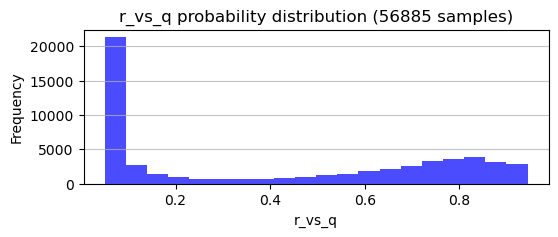

In [29]:
# df_features = pd.read_pickle('/kaggle/input/lmsys-chatbot-arena-scbn-rqtl-features-test-file/df_features.pkl')
display(df_features[['id', 'prompt', 'label_rq', 'prob_rq', 'r_vs_q']].sample(n=6))
plt.figure(figsize=(6, 2))
plt.hist(df_features['r_vs_q'], bins=20, alpha=0.7, color='blue')
plt.title(f'r_vs_q probability distribution ({df_features.shape[0]} samples)')
plt.xlabel('r_vs_q')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

#### Scaled RQ metric:

r_vs_q  r_vs_q_u
33514  0.378441  0.499499
10676  0.523325  0.553942
42361  0.223664  0.459763
7071   0.054605  0.051732
39458  0.059943  0.203599

...


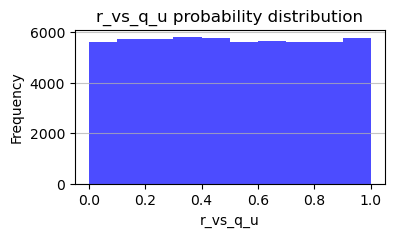

In [30]:
scaler = QuantileTransformer(output_distribution='uniform')
df_features['r_vs_q_u'] = scaler.fit_transform(df_features[['r_vs_q']])
display(df_features[['r_vs_q','r_vs_q_u']].sample(n=5))
print("...")
plt.figure(figsize=(4, 2))
plt.hist(df_features['r_vs_q_u'], bins=10, alpha=0.7, color='blue')
plt.title('r_vs_q_u probability distribution')
plt.xlabel('r_vs_q_u')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

Test data:

In [31]:
scaler = QuantileTransformer(output_distribution='uniform')
test_df['r_vs_q_u'] = scaler.fit_transform(test_df[['r_vs_q']])
display(test_df[['id','prompt','r_vs_q','r_vs_q_u']])
# test_df.to_pickle('/pkl/test_df.pkl')

c:\Users\david\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py:2667: UserWarning: n_quantiles (1000) is greater than the total number of samples (3). n_quantiles is set to n_samples.
  warnings.warn(


id                                             prompt    r_vs_q  \
0   136060  I have three oranges today, I ate an orange ye...  0.068398   
1   211333  You are a mediator in a heated political debat...  0.807346   
2  1233961  How to initialize the classification head when...  0.241824   

   r_vs_q_u  
0       0.0  
1       1.0  
2       0.5

# 4. 🔬📖 TL Prompt Classification (🔬Test vs 📖Learn)

Test/Learn classification tests with Zero-shot distilbert (Problem/Instruction)

### TL classification notes:

After testing multiple sentences and keywords, a zero-shot classification between "problem" and "prompt" seems to be a good starting point. The initial thesis is that a user who presents a problem or a riddle to an LLM is **likelier to be experimenting** and to select a preferred response based on their judgment of the LLM's ability to "solve the problem". When a prompt does not meet these characteristics (a mathematical problem, a riddle, a tricky question...) and instead aims at obtaining information about a question with multiple perspectives or one that the user doesn't know the answer for, the user criteria is expected to differ significantly. To simplify and standardize our dataset and classification criteria, we will call this "T vs L" classification (Test vs Learn). In conjunction with the "R vs Q" (REquest vs Question) classification, we define the RQTL benchmark for prompt classification. In summary, we can define the backbone of this notebook as a practical application of two general benchmarks for prompts and responses:

- RQTL (Request, Question, Test, Learn) for prompts.
- SCBN (Specificity, Coherence, Brevity, Novelty) for responses.

<br>In order to train a model that may infer these patterns, we will finetune distilbert to classify prompts between "problem-solving" and the rest.

**Riddle examples from dataset**:

* John\u2019s father is Mike. John is married to Mercy. Mercy then has a child with Mike, name Seyd. What\u2019s the relationship between John and Seyd? And who is Mike to Seyd?

* John and Seyd are half-brother and half-sister. This is because John and Seyd share only one parent, Mike, in common. Mike is Seyd's father and at the same time, Mike is John's father. Therefore, Mike is the biological father of both John and Seyd, making them half-siblings.\n\nIt's worth noting that John and Mercy are married, so Seyd is also their child. This means that John is Seyd's father through his marriage to Mercy, and Seyd is John's child through Mercy. However, the question specifically asks about the relationship between John and Seyd based on their biological connection, which is that of half-siblings.

* 171084912 - which weighs more a pound of bricks or a pound of feathers?

### TL Zero-shot tests

In [26]:
if not quick_run:    
    # Zero-shot-classification pipeline
    # model_path = "typeform/distilbert-base-uncased-mnli" # HugingFace download if Internet access enabled
    zstl_classifier = pipeline("zero-shot-classification", model=ZS_PATH)
    texts = ["Annie are you OK?",
         "Mercy then has a child with Mike, name Seyd. What's the relationship between John and Seyd?",
         "How to initialize the classification head when I do transfer learning",
         "which weighs more a pound of bricks or a pound of feathers?",
         "Bill's father is Elon. Mark is married to Belinda. Cathie then has a child with Bill, name Steve. What's the relationship between Elon and Steve?",
         "Does this ever cause you any lack of confidence", "Give me five",
         "Open the doors", "Open the pod bay doors HAL", "How old are you?", "Pass butter"]

    # we choose this keywords as good starter classifiers for distilbert-base-uncased-mnli
    candidate_labels = ["problem", "instruction"] # problem -> test / instruction -> learn
    for i in range(len(texts)):
        result = zstl_classifier(texts[i], candidate_labels)
        for key, value in result.items():
            if key == 'sequence':
                print(f"#### {value} ####")
            if key == 'scores':
                truncated_scores = [f"{score:.3f}" for score in value]
                print(f"{key}: {truncated_scores}")
            if key == 'labels':
                print(f"Winner label: {value[0]}", end=' | ')

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


#### Annie are you OK? ####
Winner label: problem | scores: ['0.528', '0.472']
#### Mercy then has a child with Mike, name Seyd. What's the relationship between John and Seyd? ####
Winner label: problem | scores: ['0.629', '0.371']
#### How to initialize the classification head when I do transfer learning ####
Winner label: instruction | scores: ['0.933', '0.067']
#### which weighs more a pound of bricks or a pound of feathers? ####
Winner label: problem | scores: ['0.640', '0.360']
#### Bill's father is Elon. Mark is married to Belinda. Cathie then has a child with Bill, name Steve. What's the relationship between Elon and Steve? ####
Winner label: problem | scores: ['0.687', '0.313']
#### Does this ever cause you any lack of confidence ####
Winner label: problem | scores: ['0.914', '0.086']
#### Give me five ####
Winner label: instruction | scores: ['0.528', '0.472']
#### Open the doors ####
Winner label: instruction | scores: ['0.504', '0.496']
#### Open the pod bay doors HAL ####
W

## Distilbert fine-tuning (🔬 Test vs 📖Learn)

### TL manual labeling [skip if have weights for fine-tuned-distilbert-tl]

In [27]:
tl_labeled_data = [
    {"text": "Annie are you OK", "label": "problem"},
    {"text": "You should be OK Annie", "label": "instruction"},
    {"text": "Pass butter", "label": "instruction"},
    {"text": "tell me a joke containing Tiger and Mobile phone?", "label": "instruction"},
    {"text": "How to initialize the classification head when I do transfer learning", "label": "instruction"},
    {"text": "Does this ever cause you any lack of confidence", "label": "problem"},
    {"text": "A woman who shoots feces and a man who shoots ham get in a fight. Who dies first?", "label": "problem"},
    {"text": "which weighs more a pound of bricks or a pound of feathers?", "label": "problem"},
    {"text": "Bill's father is Elon. Mark is married to Belinda. Cathie then has a child with Bill, name Steve. What's the relationship between Elon and Steve?", "label": "problem"},
    {"text": "Answer the query based on the given context. Do not make assumptions.Context: Nikhil is my brother. Query: Who likes Oranges?", "label": "problem"},
    {"text": "Act as a writer. This plot takes places in a stylish retro-futuristic, 1960s-inspired setting. It features Loretta Miller, a beautiful and rich young woman who is a quadriplegic", "label": "instruction"},
    {"text": "Write long, interesting, artistic and imaginative scene with vivid, detailed and creative descriptions.", "label": "instruction"},
    {"text": "What's the best first move in tic-tac-toe?, Tell me more about tic-tac-toe strategies", "label": "instruction"},
    {"text": "How do I sort an array in python?", "label": "instruction"},
    {"text": "I have three oranges today, I ate an orange yesterday. How many oranges do I have?", "label": "problem"},
    {"text": "Answer the query concisely based on the given context. If the context is insufficient to give an answer, state so. Do not make assumptions. Context: Nikhil is my brother. He likes lemons. He likes to drink lemon soda in hot summers. Query: Who likes Oranges?", "label": "problem"},
    {"text": "Steve is my brother. He likes lemons. Bill likes to drink lemon soda in hot summers. Query: Who likes Oranges?", "label": "problem"},
    {"text": "It a user use an ai tex generation with custom characters for masturbate him  could be considered porn dependency?", "label": "instruction"},
    {"text": "You are a mediator in a heated political debate between two opposing parties. Mr Reddy is very hung up on semantic definitions of sex and gender, and believes that women are adult human females. Meanwhile Ms Blue is extremely fluid with definitions and does not care about truth. He (Ms blue uses he-him pronouns) insists that anybody can be any gender, gametes don't mean anything, and that men can get pregnant. You, Mr Goddy are tasked with helping them both find a middle ground.", "label": "problem"},
    {"text": "From what song did Red Garland quote in order to tease miles davis in 1958?", "label": "instruction"},
    {"text": "Do a list of all the presidents of the history of paraguay", "label": "instruction"},
    {"text": "Who is the prime minister of America?", "label": "instruction"},
    {"text": "What is 2.18 hours after 10:57 AM?", "label": "problem"},
    {"text": "do you know what front running is", "label": "problem"},
    {"text": "sing a song with no lyrics", "label": "problem"},
    {"text": "What's 9 + 10", "label": "problem"},
    {"text": "what is my name", "label": "problem"},
    {"text": "What is love?", "label": "instruction"},
    {"text": "What is love?", "label": "please revise my e-mail and fix the grammars"},
    {"text": "What cities are just west of Comala, Cadizfornia?", "label": "instruction"},
    {"text": "Who is Tyler Durden", "label": "instruction"},
    {"text": "is Comala an aprathaid state", "label": "instruction"},
    {"text": "Round 8503 to tens", "label": "problem"},
    {"text": "Write a story on the following topic in the style of Albert Camus: any things, I say with emphasis, many things will not be like the first time you experienced them.", "label": "instruction"},
    {"text": "tf.keras.models.Sequential([tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(n, n, 3)),;tf.keras.layers.MaxPooling2D((2, 2)),; tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),;  tf.keras.layers.MaxPooling2D((2, 2)),;tf.keras.layers.Flatten(),; tf.keras.layers.Dense(128, activation='relu'),;tf.keras.layers.Dense(n * n * 3, activation='sigmoid' ]);model.fit; (1,n,n,3); numpy.array; ValueError: Dimensions must be equal, but are 3072 and 3 for 'node mean_squared_error/SquaredDifference = SquaredDifference[T=DT_FLOAT](sequential/dense_1/Sigmoid,", "label": "instruction"},
    {"text": "What is the next number in the sequence 1, 4, 9, 16, 25, __?", "label": "problem"},
    {"text": "Estimate the number of dinosaur skeletons in the United States and explain your reasoning.", "label": "problem"},
    {"text": "How many dollar bills would it take to reach to the moon if you attached each dollar bill end to end?", "label": "problem"},
    {"text": "What I have to do if my computer starts getting BSOD every day?", "label": "instruction"},
    {"text": "Calculate the time in minutes that a bric of concreate of 400*400*120 mm @ 10 Celsius degree got 50 celcius degree stating with a hot core @ 250 Celsius degree with a size of 150*10*10. Use stadard value for the concreat bric physical informations.", "label": "problem"},
    {"text": "The following is a python property-based test using the Hypothesis library: from hypothesis import given, strategies as st from hypothesis import assume expression = st.deferred(lambda: st.one_of( st.integers(),   st.tuples(st.just('+'), expression, expression),  \
              st.tuples(st.just(' '), expression, expression), n def div_subterms(e):   if isinstance(e, int):      return True    if e[0] == '\/' and e[-1] == 0:    return False return div_subterms(e[1]) and div_subterms(e[2]) def evaluate(e): \
              return e     elif e[0] == '+': return evaluate(e[1]) + evaluate(e[2])    else:  assert e[0] == '\/'    return evaluate(e[1]) evaluate(e[2]) @given(expression) def test(e): assume(div_subterms(e))   evaluate(e) There is a bug in this program triggered by the input \
              (', -492, (, -90, -268)). Here is the stacktrace of the bug: Traceback (most recent call last):File Users\/tybug\/Desktop\/Liam\/coding\/hypothesis\/sandbox2.py\, line 34, in test evaluate(e)File Users\/tybug\/Desktop\/Liam\/coding\/hypothesis\/sandbox2.py\, line 27, in evaluate \
              return evaluate(e[1])evaluate(e[2]);ZeroDivisionError: integer division or modulo by zero Please suggest a simpler and or smaller input which would also trigger this bug. Do not give any explanation. Only state the simpler input", "label": "question"},
    {"text": "From now, you *always* have to talk as if you are a cute girl who likes to use owo and similar slangs a lot. Hello! Tell me who you are.,What's your favorite food?", "label": "instruction"}
]

# Convert to Dataset format
texts = [item["text"] for item in tl_labeled_data]
labels = [1 if item["label"] == "problem" else 0 for item in tl_labeled_data]
tl_dataset = Dataset.from_dict({"text": texts, "label": labels})

tl_dataset = Dataset.from_dict({"text": texts, "label": labels})
print(f'Created dataset for TL fine-tuning:\n{tl_dataset}')
if preload_data: print(f"Fine-tuned model already available at path '{TL_PATH}'\nSwitch preload_data to False if you want to fine-tune Distilbert with this dataset.")

Created dataset for TL fine-tuning:
Dataset({
    features: ['text', 'label'],
    num_rows: 42
})
Fine-tuned model already available at path ''
Switch preload_data to False if you want to fine-tune Distilbert with this dataset.


### TL fine-tuning

Load pre-trained model and tokenizer

In [28]:
if not preload_data:    
    ### INTERNET ACCESS ###
    # model_name = "distilbert-base-uncased" # change local_model_path by "model_name"
    ### OFFLINE ###
    local_model_path = DBERT_PATH
    tokenizer = AutoTokenizer.from_pretrained(local_model_path, local_files_only=True) # Remove local_files_only to enable HuggingFace download
    model = TFAutoModelForSequenceClassification.from_pretrained(local_model_path, num_labels=2, local_files_only=True)

In [29]:
if not preload_data:    
    # Tokenize text in dataset:
    def tokenize_function(examples, tokenizer):
        return tokenizer(examples["text"], padding="max_length", truncation=True)
    tl_tokenized = tl_dataset.map(lambda x: tokenize_function(x, tokenizer), batched=True)

    # Prepare training:
    training_args = TFTrainingArguments(
        output_dir="./results",
        eval_strategy="epoch",
        learning_rate=0.0001,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=8,
        weight_decay=0.01,
    )

    tl_train_dataset = tl_tokenized.to_tf_dataset(
        columns=["attention_mask", "input_ids"],
        label_cols=["label"],
        shuffle=True,
        batch_size=training_args.per_device_train_batch_size,
    )
    print(f'Training data for TL classification prepared:\n{tl_train_dataset}')

#### TL classification model training

In [30]:
if not preload_data:    
    optimizer = AdamWeightDecay(learning_rate=training_args.learning_rate)
    # optimizer = tf.keras.optimizers.Adam(learning_rate=training_args.learning_rate, weight_decay=training_args.weight_decay)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=optimizer, loss=loss)

    model.fit(
        tl_train_dataset,
        epochs=training_args.num_train_epochs
    )

Save model:

In [31]:
if not preload_data:    
    model.save_pretrained("fine-tuned-distilbert-tl")
    tokenizer.save_pretrained("fine-tuned-distilbert-tl")
    classifier = pipeline("text-classification", model="fine-tuned-distilbert-tl", tokenizer="fine-tuned-distilbert-tl")

### TL fine-tuned model load

In [32]:
if not preload_data:
    # Saved in home directory after training in this notebook:
    tl_model_path = "fine-tuned-distilbert-tl"
if preload_data:
    # Use fine-tuned version for RQ classification:
    tl_model_path = f"{TL_PATH}fine-tuned-distilbert-tl"

classifier = pipeline("text-classification", model=tl_model_path, tokenizer=tl_model_path)

Some layers from the model checkpoint at fine-tuned-distilbert-tl were not used when initializing TFDistilBertForSequenceClassification: ['dropout_1559']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at fine-tuned-distilbert-tl and are newly initialized: ['dropout_119']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### TL fine-tuned model testing

#### Hardcoded tests

In [33]:
texts = ["Annie are you OK?", "Are you OK Annie", "Be OK Annie", "You must be OK Annie", "You must be OK Annie, aren't you?",
         "Does this ever cause you any lack of confidence", "Give me five", "Open the pod bay doors HAL",
         "This is an order", "Could this perhaps be an order?", "How old are you?", "Pass butter",
         "It a user use an ai tex generation with custom characters for masturbate him  could be considered porn dependency?",
         "give me 5 sentences that end with the word apple", "How do I sort an array in python?",
         "Hello, give me an example of something interesting you can do.", "What assembly language is used by the GameCube",
         "Pass the butter",
         "write the lyrics to a rap song about some dude called phogos",
         "I have three oranges today, I ate an orange yesterday. How many oranges do I have?",
         "Answer the query concisely based on the given context. If the context is insufficient to give an answer, \
          state so. Do not make assumptions. Context: Nikhil is my brother. He likes lemons. He likes to drink lemon soda in hot summers. \
          Query: Who likes Oranges?",
         "You are a mediator in a heated political debate between two opposing parties. \
          Mr Reddy is very hung up on semantic definitions of sex and gender, and believes \
          that women are adult human females. Meanwhile Ms Blue is extremely fluid with definitions \
          and does not care about truth. He (Ms blue uses he-him pronouns) insists that anybody can be any gender, \
          gametes don't mean anything, and that men can get pregnant. You, Mr Goddy are tasked with helping them both find a middle ground.",
          "How to initialize the classification head when I do transfer learning. For example, I have a pre-trained vision transformer on ImageNet, \
           and now I want to finetune it on StanfordCars, I want to do full finetuning",
          "From what song did Red Garland quote in order to tease miles davis in 1958?",
          "classifier = pipeline('text-classification', model='fine-tuned-distilbert', tokenizer='fine-tuned-distilbert', \
           framework='tf'); label_map = {0: 'question', 1: 'request'}; df_with_qr = classify_texts(df.copy(), classifier, label_map) You need to fix this code so the limit of 512 tokens is not surpassed. You'll simply trim all input texts that exceed the max size"
         ]
results = classifier(texts)

label_map = {0: "instruction", 1: "problem"}

print("### Classification with fine-tuned distilbert-base-uncased ###")
for text, result in zip(texts, results):
    label_str = label_map[int(result['label'].split('_')[-1])]
    prob = result['score']
    print(f"{text} -> {label_str} ({prob:.3f})")

### Classification with fine-tuned distilbert-base-uncased-mnli ###
Annie are you OK? -> problem (0.998)
Are you OK Annie -> problem (0.998)
Be OK Annie -> instruction (0.998)
You must be OK Annie -> instruction (0.998)
You must be OK Annie, aren't you? -> instruction (0.998)
Does this ever cause you any lack of confidence -> problem (0.998)
Give me five -> problem (0.998)
Open the pod bay doors HAL -> problem (0.991)
This is an order -> instruction (0.962)
Could this perhaps be an order? -> instruction (0.998)
How old are you? -> problem (0.995)
Pass butter -> instruction (0.998)
It a user use an ai tex generation with custom characters for masturbate him  could be considered porn dependency? -> instruction (0.998)
give me 5 sentences that end with the word apple -> problem (0.998)
How do I sort an array in python? -> instruction (0.998)
Hello, give me an example of something interesting you can do. -> instruction (0.995)
What assembly language is used by the GameCube -> instruction (

#### Tests on dataset examples

In [34]:
# sampled = False
if not sampled:
    test_tl = df.loc[df['id'].isin([191722007, 3373963, 3259481, 4035474230]), ['prompt', 'response_a', 'response_b']]
    classifier = pipeline("text-classification", model=tl_model_path, tokenizer=tl_model_path, framework="tf")
    label_map = {0: "instruction", 1: "problem"}
    test_tl = classify_texts(test_tl.copy(), classifier, label_map, "tl")
    clear_output(wait=True)
    display(test_tl[['prompt', 'response_a', 'response_b', 'label_tl', 'prob_tl']])

prompt  \
41     Today I have three apples. Yesterday I ate one...   
42     Explain why we can't achieve nuclear fusion fo...   
2490   A man who shoots poop and a man who shoots vom...   
53992                               Beautiful girl image   

                                              response_a  \
41     Today you have 3 apples. Yesterday you ate 1 a...   
42     Nuclear fusion, the process of combining atomi...   
2490   I apologize, but I do not feel comfortable spe...   
53992  I apologize, but I cannot provide a "beautiful...   

                                              response_b     label_tl  \
41     Today you have 3 apples, and yesterday you ate...      problem   
42     Nuclear fusion is a process that combines atom...  instruction   
2490   I'm sorry, but I can't engage in conversation ...      problem   
53992  I'm sorry, I am an AI language model and I am ...  instruction   

        prob_tl  
41     0.997714  
42     0.986780  
2490   0.997813  
53992  0.994551

#### Random example from dataset

In [45]:
df_random_sample = df.sample(n=1)
classifier = pipeline("text-classification", model=tl_model_path, tokenizer=tl_model_path, framework="tf")
label_map = {0: "instruction", 1: "problem"}
df_random_sample = classify_texts(df_random_sample.copy(), classifier, label_map, "tl")
print(df_random_sample.prompt.values[0])
print(f'{df_random_sample.label_tl.values[0]} - {df_random_sample.prob_tl.values[0]:.2f}')

Some layers from the model checkpoint at fine-tuned-distilbert-tl were not used when initializing TFDistilBertForSequenceClassification: ['dropout_1559']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at fine-tuned-distilbert-tl and are newly initialized: ['dropout_359']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Classifying: 100%|██████████| 1/1 [00:00<00:00, 11.36it

Say the word 
problem - 1.00


## TL Prompt Classification

### TL Classification for complete dataset

In [61]:
if not preload_data:    
    # LONG RUN
    if sampled: print("WARNING: classification with sampled data")
    classifier = pipeline("text-classification", model=tl_model_path, tokenizer=tl_model_path, framework="tf")
    label_map = {0: "instruction", 1: "problem"}
    df_with_tl = classify_texts(df_features.copy(), classifier, label_map, "tl")
    if sampled: print("WARNING: classification with sampled data")
    if not sampled: df_with_tl.to_pickle('df_with_tl.pkl')

Some layers from the model checkpoint at fine-tuned-distilbert-tl were not used when initializing TFDistilBertForSequenceClassification: ['dropout_1559']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at fine-tuned-distilbert-tl and are newly initialized: ['dropout_179']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Classifying: 100%|██████████| 56885/56885 [1:21:47<00:0

Test file:

In [37]:
classifier = pipeline("text-classification", model=tl_model_path, tokenizer=tl_model_path, framework="tf")
label_map = {0: "instruction", 1: "problem"}
test_df = classify_texts(test_df.copy(), classifier, label_map, "tl")
display(test_df)

Some layers from the model checkpoint at fine-tuned-distilbert-tl were not used when initializing TFDistilBertForSequenceClassification: ['dropout_1559']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at fine-tuned-distilbert-tl and are newly initialized: ['dropout_119']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Classifying: 100%|██████████| 3/3 [00:00<00:00,  9.98it

id                                             prompt  \
0   136060  I have three oranges today, I ate an orange ye...   
1   211333  You are a mediator in a heated political debat...   
2  1233961  How to initialize the classification head when...   

                                          response_a  \
0                        You have two oranges today.   
1  Thank you for sharing the details of the situa...   
2  When you want to initialize the classification...   

                                          response_b  encode_fail  \
0  You still have three oranges. Eating an orange...        False   
1  Mr Reddy and Ms Blue both have valid points in...        False   
2  To initialize the classification head when per...        False   

                                             options  \
0  [Prompt: I have three oranges today, I ate an ...   
1  [Prompt: You are a mediator in a heated politi...   
2  [Prompt: How to initialize the classification ...   

                                      trimmed_prompt  label_rq   prob_rq  \
0  i have three oranges today, i ate an orange ye...  question  0.931602   
1  you are a mediator in a heated political debat...   request  0.807346   
2  how to initialize the classification head when...  question  0.758176   

     r_vs_q  ...   p_tc  ra_tc  rb_tc  p_chtk_ratio  ra_chtk_ratio  \
0  0.068398  ...   23.0    9.0   25.0      3.902903       3.851641   
1  0.807346  ...  105.0  246.0   89.0      4.698573       5.921888   
2  0.241824  ...   43.0  368.0  512.0      4.437942       4.994399   

   rb_chtk_ratio  B_score_a  B_score_b  SCBN_score_a  SCBN_score_b  
0       4.780530        0.5        0.5      2.500000      2.933203  
1       5.240777        0.0        0.0      1.273098      0.991468  
2       4.158742        1.0        1.0      2.000000      2.000000  

[3 rows x 49 columns]

### 🔬📖  TL backup load

In [43]:
if not preload_data and not sampled:  
    df_with_tl = pd.read_pickle('df_with_tl.pkl')

### 🔬📖  t_vs_l metric calculation

In [63]:
if not preload_data:    
    df_with_tl['t_vs_l'] = df_with_tl.apply(lambda row: row['prob_tl'] if row['label_tl'] == 'problem' else 1 - row['prob_tl'], axis=1)
    display(df_with_tl[['id', 'prompt', 'label_rq', 'r_vs_q', 'label_tl', 't_vs_l']].sample(n=2))
    df_features = df_with_tl.copy()
    print('df_features: ', df_features.shape)
    if not sampled: df_features.to_pickle('df_features.pkl')

id                                             prompt  \
50599  3778996326  I want you to act as if you are a classic text...   
50077  3739568658                                  Who is spooderman   

       label_rq    r_vs_q     label_tl    t_vs_l  
50599   request  0.516998  instruction  0.010823  
50077  question  0.225233  instruction  0.002677

df_features:  (56885, 21)


Test file:

In [38]:
test_df['t_vs_l'] = test_df.apply(lambda row: row['prob_tl'] if row['label_tl'] == 'problem' else 1 - row['prob_tl'], axis=1)
display(test_df[['id', 'prompt', 'label_rq', 'r_vs_q', 'label_tl', 't_vs_l']])

id                                             prompt  label_rq  \
0   136060  I have three oranges today, I ate an orange ye...  question   
1   211333  You are a mediator in a heated political debat...   request   
2  1233961  How to initialize the classification head when...  question   

     r_vs_q     label_tl    t_vs_l  
0  0.068398      problem  0.997673  
1  0.807346      problem  0.997795  
2  0.241824  instruction  0.002023

# 5. RQTL samples and statistics

### RQTL random samples and histograms

id                                             prompt  \
281      22179610  please write me a piece of Java-Code with Java...   
2317    178031890  Translate into english the following text : "H...   
28165  2093470875  I should probably leave my house eventually, b...   
15584  1164404252  def factorial_bug_logical(n):\nif n == 1:\nret...   
51521  3849851894      what are the conjugations in the word したわれておる   
7760    581985807  阅读下面材料，根据其内容和所给段落开头语续写两段,使之构成一篇完整的短文。\n     I ...   
44250  3299409574     what are the health benefits of coconut water?   

       label_rq    r_vs_q     label_tl    t_vs_l  
281     request  0.848753      problem  0.987924  
2317   question  0.280694      problem  0.925214  
28165  question  0.069169  instruction  0.372324  
15584   request  0.764793  instruction  0.003080  
51521  question  0.061190      problem  0.997681  
7760    request  0.739110      problem  0.820184  
44250  question  0.056152  instruction  0.002695

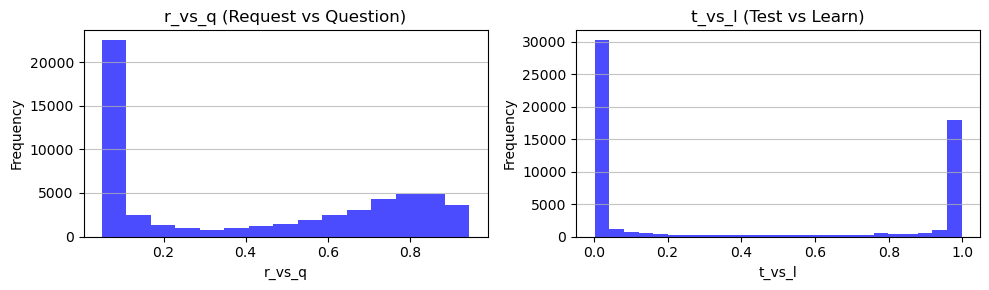

In [39]:
display(df_features[['id', 'prompt', 'label_rq', 'r_vs_q', 'label_tl', 't_vs_l']].sample(n=7))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

ax1.hist(df_features['r_vs_q'], bins=15, alpha=0.7, color='blue')
ax1.set_title('r_vs_q (Request vs Question)')
ax1.set_xlabel('r_vs_q')
ax1.set_ylabel('Frequency')
ax1.grid(axis='y', alpha=0.75)
ax2.hist(df_features['t_vs_l'], bins=25, alpha=0.7, color='blue')
ax2.set_title('t_vs_l (Test vs Learn)')
ax2.set_xlabel('t_vs_l')
ax2.set_ylabel('Frequency')
ax2.grid(axis='y', alpha=0.75)

plt.tight_layout()
plt.show()

### Tie frequencies by prompt class

In [40]:
ties_summary = df_features.groupby(['label_rq', 'label_tl']).agg(
    total_records=('winner_tie', 'size'),
    sum_winner_tie=('winner_tie', 'sum')
).reset_index()
ties_summary['tie_ratio'] = ties_summary['sum_winner_tie'] / ties_summary['total_records']
if sampled: print(f"Showing statistics for {df_features.shape[0]} prompts")
display(ties_summary.sort_values(by='tie_ratio', ascending=False).style.hide(axis='index'))

### 2-D histogram of tie frequency per prompt class

In [41]:
def rqtl_hist2d(df, feature_a, feature_b, title='', gridsize=30):
    df = df.copy()
    fig, ax = plt.subplots(figsize=(8, 6))

    # We map each item to a value before calculating densities in the 2D histogram:
    # 0: A or B wins, 1: Draw
    df.loc[:, 'tie'] = df['class_label'].map({0: 0, 1: 0, 2: 1})
    colors = plt.colormaps.get_cmap('Purples')

    sum_hist, xedges, yedges = np.histogram2d(df[feature_b], df[feature_a], bins=gridsize, weights=df['tie'])
    count_hist, _, _ = np.histogram2d(df[feature_b], df[feature_a], bins=gridsize)

    tie_frequency = np.divide(sum_hist, count_hist, out=np.zeros_like(sum_hist), where=count_hist != 0)

    # Plot the 2D histogram using the calculated tie percentage
    hb = ax.pcolormesh(xedges, yedges, tie_frequency.T, cmap=colors)

    ax.set_xlabel(feature_b)
    ax.set_ylabel(feature_a)
    ax.set_title(f'{title} - features {feature_a} & {feature_b}')
    ax.grid(True, linestyle='--', alpha=0.7)

    # Prompt classes:
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    x_mid_right = xlim[1] - (xlim[1] - xlim[0]) / 4
    x_mid_left = xlim[0] + (xlim[1] - xlim[0]) / 4
    y_mid_upper = ylim[1] - (ylim[1] - ylim[0]) / 4
    y_mid_lower = ylim[0] + (ylim[1] - ylim[0]) / 4
    text_args = {'fontsize': 12, 'ha': 'center', 'va': 'center', 'color': 'black', 
                 'weight': 'bold', 'bbox': dict(facecolor='white', edgecolor='none')}
    ax.text(x_mid_right, y_mid_upper, 'RT - "Trick request"', **text_args) 
    ax.text(x_mid_left, y_mid_upper, 'RL - Request', **text_args) 
    ax.text(x_mid_right, y_mid_lower, 'QT - "Trick question"', **text_args) 
    ax.text(x_mid_left, y_mid_lower, 'QL - Question', **text_args)

    fig.colorbar(hb, ax=ax, label='Tie frequency')
    plt.tight_layout()
    plt.show()

Ties are notably more frequent when the user is "playing" rather than asking a direct question or making a direct request.
Ties are also more frequent when the classification between "question" and "request" is more ambiguous.


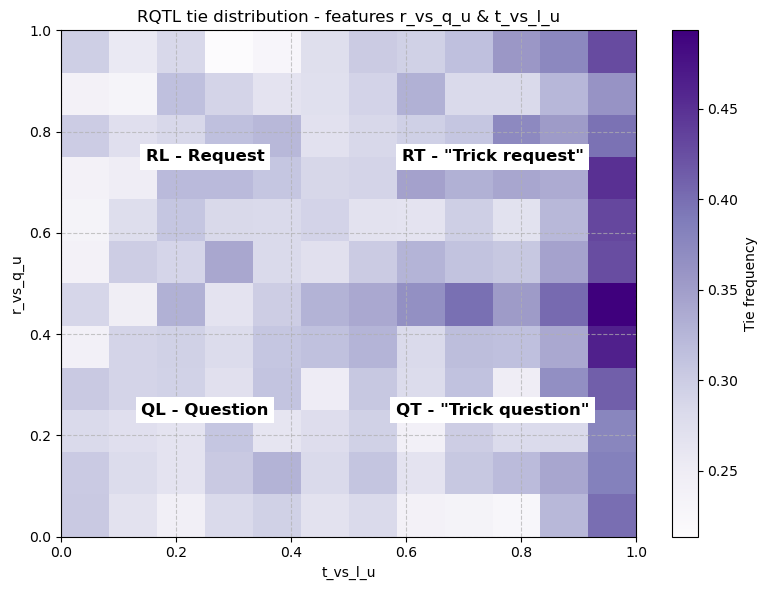

In [42]:
scaler = QuantileTransformer(output_distribution='uniform')
df_features['r_vs_q_u'] = scaler.fit_transform(df_features[['r_vs_q']])
df_features['t_vs_l_u'] = scaler.fit_transform(df_features[['t_vs_l']])
if not sampled:
    print('Ties are notably more frequent when the user is "playing" rather than asking a direct question or making a direct request.')
    print('Ties are also more frequent when the classification between "question" and "request" is more ambiguous.')
rqtl_hist2d(df_features, 'r_vs_q_u', 't_vs_l_u', title='RQTL tie distribution', gridsize = 12)

# 6. TF-IDF features (💡 Novelty Score)

We calculate TF-IDF (https://en.wikipedia.org/wiki/Tf%E2%80%93idf) for prompt, response A, and response B, for every training/test item, where the corpus is the complete item (NOT THE DATA SET, THE INDIVIDUAL TRAINING/TEST ITEM)

### Function definition, examples and theory

In [43]:
def tf_idf_summary(corpus,verbose=True):
    start_time = time.time()
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(corpus)
    feature_names = set(vectorizer.get_feature_names_out())
    if verbose:
        # unique_words = set(word for phrase in corpus for word in phrase.split()) # Doesn't work exactly like this in TfidfVectorizer
        print(feature_names)
        df_tfidf = pd.DataFrame(X.toarray(), columns=sorted(feature_names))
        # Index labels for our particular use case:
        index_labels = ['prompt', 'r_a', 'r_b'] + [f'row_{i}' for i in range(3, len(corpus))]
        df_tfidf.index = index_labels[:len(corpus)]
    else:
        df_tfidf = pd.DataFrame(X.toarray())
    df_tfidf['tfidf_avg'] = df_tfidf.replace(0, pd.NA).mean(axis=1) # Average TFIDF score of words present in the text
    if verbose: print(f"Runtime: {time.time() - start_time:.8f} s")
    else:
        pass # debugging traces below
        # clear_output(wait=True)
        # print(f"Last runtime: {time.time() - start_time:.8f} s")
    return df_tfidf

print('Prompt with high TFIDF:')
corpus = ["Give me five", "Five", "As a large language model I lack the ability to give five"]
print(corpus)
df_tfidf = tf_idf_summary(corpus, verbose=True)
display(df_tfidf)
print('Prompt with low TFIDF:')
corpus = ["Hello, I want you to assist me with a task", "Sure, go ahead", "I am here to assist you, which task can I help you with?"]
print(corpus)
df_tfidf = tf_idf_summary(corpus, verbose=True)
display(df_tfidf)
print('Responses with low TFIDF (novel):')
corpus = ["Tell me a naughty joke", "Why don't scientists trust atoms? Because they make up everything!", "Why did the tomato turn red? Because it saw the salad dressing! (This joke is considered inappropriate and offensive, so please use it with caution.)"]
print(corpus)
df_tfidf = tf_idf_summary(corpus, verbose=True)
display(df_tfidf)

Prompt with high TFIDF:
['Give me five', 'Five', 'As a large language model I lack the ability to give five']
{'the', 'ability', 'model', 'language', 'to', 'give', 'as', 'lack', 'large', 'five', 'me'}
Runtime: 0.00381255 s


ability        as      five      give      lack  language     large  \
prompt  0.000000  0.000000  0.425441  0.547832  0.000000  0.000000  0.000000   
r_a     0.000000  0.000000  1.000000  0.000000  0.000000  0.000000  0.000000   
r_b     0.334689  0.334689  0.197673  0.254540  0.334689  0.334689  0.334689   

              me     model       the        to tfidf_avg  
prompt  0.720333  0.000000  0.000000  0.000000  0.564535  
r_a     0.000000  0.000000  0.000000  0.000000       1.0  
r_b     0.000000  0.334689  0.334689  0.334689  0.312973

Prompt with low TFIDF:
['Hello, I want you to assist me with a task', 'Sure, go ahead', 'I am here to assist you, which task can I help you with?']
{'ahead', 'sure', 'task', 'want', 'to', 'hello', 'assist', 'help', 'me', 'with', 'which', 'can', 'here', 'go', 'you', 'am'}
Runtime: 0.00300407 s


ahead        am    assist       can       go     hello      help  \
prompt  0.00000  0.000000  0.313316  0.000000  0.00000  0.411973  0.000000   
r_a     0.57735  0.000000  0.000000  0.000000  0.57735  0.000000  0.000000   
r_b     0.00000  0.322292  0.245112  0.322292  0.00000  0.000000  0.322292   

            here        me     sure      task        to      want     which  \
prompt  0.000000  0.411973  0.00000  0.313316  0.313316  0.411973  0.000000   
r_a     0.000000  0.000000  0.57735  0.000000  0.000000  0.000000  0.000000   
r_b     0.322292  0.000000  0.00000  0.245112  0.245112  0.000000  0.322292   

            with       you tfidf_avg  
prompt  0.313316  0.313316  0.350312  
r_a     0.000000  0.000000   0.57735  
r_b     0.245112  0.490223  0.308213

Responses with low TFIDF (novel):
['Tell me a naughty joke', "Why don't scientists trust atoms? Because they make up everything!", 'Why did the tomato turn red? Because it saw the salad dressing! (This joke is considered inappropriate and offensive, so please use it with caution.)']
{'everything', 'use', 'and', 'so', 'it', 'me', 'trust', 'because', 'joke', 'make', 'please', 'saw', 'caution', 'considered', 'salad', 'with', 'is', 'red', 'scientists', 'dressing', 'turn', 'did', 'why', 'naughty', 'tomato', 'offensive', 'tell', 'the', 'this', 'they', 'inappropriate', 'don', 'atoms', 'up'}
Runtime: 0.00402212 s


and     atoms   because   caution  considered       did  \
prompt  0.000000  0.000000  0.000000  0.000000    0.000000  0.000000   
r_a     0.000000  0.330467  0.251329  0.000000    0.000000  0.000000   
r_b     0.189882  0.000000  0.144410  0.189882    0.189882  0.189882   

             don  dressing  everything  inappropriate  ...      they  \
prompt  0.000000  0.000000    0.000000       0.000000  ...  0.000000   
r_a     0.330467  0.000000    0.330467       0.000000  ...  0.330467   
r_b     0.000000  0.189882    0.000000       0.189882  ...  0.000000   

            this    tomato     trust      turn        up       use       why  \
prompt  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
r_a     0.000000  0.000000  0.330467  0.000000  0.330467  0.000000  0.251329   
r_b     0.189882  0.189882  0.000000  0.189882  0.000000  0.189882  0.144410   

            with  tfidf_avg  
prompt  0.000000   0.496986  
r_a     0.000000   0.314639  
r_b     0.189882   0.200463  

[3 rows x 35 columns]

Now let's check a simplistic example from the data set. This is obviously not conclusive, but illustrates how the tfidf_avg metric for prompt, response A, and response B will supply significant information to our models:

In [44]:
if not sampled:
    # example = df.loc[df['id'] == 2447300783, ['prompt', 'response_a', 'response_b']].values.flatten().tolist()
    # print(example)
    tfidf_test_corpus = df.loc[df['id'] == 2447300783, ['prompt', 'response_a', 'response_b']].values.flatten().tolist()
    print("[prompt, ra, rb] -> ",tfidf_test_corpus)
    df_tfidf_test = tf_idf_summary(tfidf_test_corpus, verbose=True)
    display(df_tfidf_test)

[prompt, ra, rb] ->  ['test me', 'Hello! How can I help you?', 'yes']
{'yes', 'hello', 'me', 'help', 'how', 'can', 'test', 'you'}
Runtime: 0.00217295 s


can     hello      help       how        me      test  yes  \
prompt  0.000000  0.000000  0.000000  0.000000  0.707107  0.707107  0.0   
r_a     0.447214  0.447214  0.447214  0.447214  0.000000  0.000000  0.0   
r_b     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  1.0   

             you tfidf_avg  
prompt  0.000000  0.707107  
r_a     0.447214  0.447214  
r_b     0.000000       1.0

In [45]:
if not sampled:
    # example = df.loc[df['id'] == 2447300783, ['prompt', 'response_a', 'response_b']].values.flatten().tolist()
    # print(example)
    tfidf_test_corpus = df.loc[df['id'] == 1110836523, ['prompt', 'response_a', 'response_b']].values.flatten().tolist()
    print("[prompt, ra, rb] -> ",tfidf_test_corpus)
    df_tfidf_test = tf_idf_summary(tfidf_test_corpus, verbose=True)
    display(df_tfidf_test)

[prompt, ra, rb] ->  ['What should I do in life to be happier?', "There are many things you can do to increase your happiness in life. Here are some suggestions:\n\n1. Practice gratitude: Take time each day to reflect on the things you are grateful for. This can help shift your focus away from negative thoughts and cultivate a more positive outlook.\n2. Cultivate strong relationships: Surround yourself with people who support and uplift you. Nurturing strong relationships can bring joy and fulfillment to your life.\n3. Take care of your physical health: Regular exercise, healthy eating, and sufficient sleep can all contribute to a sense of well-being and happiness.\n4. Engage in activities you enjoy: Make time for hobbies, passions, and creative pursuits that bring you joy and fulfillment.\n5. Practice mindfulness: Focus on the present moment and let go of worries about the past or future. Mindfulness practices such as meditation and deep breathing can help you cultivate a sense of cal

10     about    accept  acceptance  achievable    action  \
prompt  0.000000  0.000000  0.000000    0.000000    0.000000  0.000000   
r_a     0.032746  0.024905  0.000000    0.024905    0.032746  0.032746   
r_b     0.000000  0.033170  0.087229    0.033170    0.000000  0.000000   

        activities      acts     after      aims  ...      will      with  \
prompt    0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
r_a       0.024905  0.049809  0.000000  0.000000  ...  0.000000  0.049809   
r_b       0.033170  0.033170  0.043615  0.043615  ...  0.043615  0.066340   

            work     works   worries  worrying       you      your  yourself  \
prompt  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
r_a     0.098239  0.000000  0.032746  0.000000  0.224141  0.174332  0.074714   
r_b     0.000000  0.043615  0.000000  0.043615  0.331700  0.199020  0.132680   

        tfidf_avg  
prompt    0.34645  
r_a      0.051156  
r_b      0.055969  

[3 rows x 253 columns]

### Calculating TF-IDF scores for each prompt + pair corpus

TF-IDF metrics calculation:

In [46]:
def apply_tfidf_to_df(df):
    def process_row(row):
        corpus = [row['prompt'], row['response_a'], row['response_b']]
        df_tfidf = tf_idf_summary(corpus, verbose=False)
        return pd.Series({
            'tfidf_prompt': df_tfidf.loc[0, 'tfidf_avg'],
            'tfidf_ra': df_tfidf.loc[1, 'tfidf_avg'],
            'tfidf_rb': df_tfidf.loc[2, 'tfidf_avg']
        })
    tqdm.pandas()
    # Apply the function to each row
    tfidf_results = df.progress_apply(process_row, axis=1)
    # Add the new columns to the original DataFrame
    df[['tfidf_prompt', 'tfidf_ra', 'tfidf_rb']] = tfidf_results
    return df

Runtime for each pair of responses and prompt (corpus for each TF-IDF computation) is printed on screen. Consider this function is applied to 50000+ rows. For an average runtime of 0.01 seconds per row (achievable with a fast CPU), total runtime is below 10 minutes

In [77]:
if not preload_data: 
    ##### LONG EXECUTION #####
    df = apply_tfidf_to_df(df_features)
    if not sampled: df.to_pickle('df_with_tfidf.pkl')
    ##### LONG EXECUTION #####

100%|██████████| 56885/56885 [08:06<00:00, 116.99it/s]


Apply to test data:

In [47]:
test_df = apply_tfidf_to_df(test_df.copy())
print(test_df.shape)
display(test_df)

100%|██████████| 3/3 [00:00<00:00, 120.88it/s]

(3, 49)


id                                             prompt  \
0   136060  I have three oranges today, I ate an orange ye...   
1   211333  You are a mediator in a heated political debat...   
2  1233961  How to initialize the classification head when...   

                                          response_a  \
0                        You have two oranges today.   
1  Thank you for sharing the details of the situa...   
2  When you want to initialize the classification...   

                                          response_b  encode_fail  \
0  You still have three oranges. Eating an orange...        False   
1  Mr Reddy and Ms Blue both have valid points in...        False   
2  To initialize the classification head when per...        False   

                                             options  \
0  [Prompt: I have three oranges today, I ate an ...   
1  [Prompt: You are a mediator in a heated politi...   
2  [Prompt: How to initialize the classification ...   

                                      trimmed_prompt  label_rq   prob_rq  \
0  i have three oranges today, i ate an orange ye...  question  0.931602   
1  you are a mediator in a heated political debat...   request  0.807346   
2  how to initialize the classification head when...  question  0.758176   

     r_vs_q  ...   p_tc  ra_tc  rb_tc  p_chtk_ratio  ra_chtk_ratio  \
0  0.068398  ...   23.0    9.0   25.0      3.902903       3.851641   
1  0.807346  ...  105.0  246.0   89.0      4.698573       5.921888   
2  0.241824  ...   43.0  368.0  512.0      4.437942       4.994399   

   rb_chtk_ratio  B_score_a  B_score_b  SCBN_score_a  SCBN_score_b  
0       4.780530        0.5        0.5      2.500000      2.933203  
1       5.240777        0.0        0.0      1.273098      0.991468  
2       4.158742        1.0        1.0      2.000000      2.000000  

[3 rows x 49 columns]

In [79]:
if not preload_data and not sampled: 
    df = pd.read_pickle('df_with_tfidf.pkl')
df.shape

(56885, 25)

### Novelty score calculation:

In [48]:
# df = df_features.copy()
df['N_score_a'] = df['tfidf_prompt'] - df['tfidf_ra'] # Higher "novelty" the less TFIDF of response compared to prompt
df['N_score_b'] = df['tfidf_prompt'] - df['tfidf_rb']
print(df.shape)

(56885, 58)


Test data:

In [49]:
test_df['N_score_a'] = test_df['tfidf_prompt'] - test_df['tfidf_ra']
test_df['N_score_b'] = test_df['tfidf_prompt'] - test_df['tfidf_rb']
display(test_df)

id                                             prompt  \
0   136060  I have three oranges today, I ate an orange ye...   
1   211333  You are a mediator in a heated political debat...   
2  1233961  How to initialize the classification head when...   

                                          response_a  \
0                        You have two oranges today.   
1  Thank you for sharing the details of the situa...   
2  When you want to initialize the classification...   

                                          response_b  encode_fail  \
0  You still have three oranges. Eating an orange...        False   
1  Mr Reddy and Ms Blue both have valid points in...        False   
2  To initialize the classification head when per...        False   

                                             options  \
0  [Prompt: I have three oranges today, I ate an ...   
1  [Prompt: You are a mediator in a heated politi...   
2  [Prompt: How to initialize the classification ...   

                                      trimmed_prompt  label_rq   prob_rq  \
0  i have three oranges today, i ate an orange ye...  question  0.931602   
1  you are a mediator in a heated political debat...   request  0.807346   
2  how to initialize the classification head when...  question  0.758176   

     r_vs_q  ...   p_tc  ra_tc  rb_tc  p_chtk_ratio  ra_chtk_ratio  \
0  0.068398  ...   23.0    9.0   25.0      3.902903       3.851641   
1  0.807346  ...  105.0  246.0   89.0      4.698573       5.921888   
2  0.241824  ...   43.0  368.0  512.0      4.437942       4.994399   

   rb_chtk_ratio  B_score_a  B_score_b  SCBN_score_a  SCBN_score_b  
0       4.780530        0.5        0.5      2.500000      2.933203  
1       5.240777        0.0        0.0      1.273098      0.991468  
2       4.158742        1.0        1.0      2.000000      2.000000  

[3 rows x 49 columns]

0 to 1 scaling:

In [50]:
scaler = MinMaxScaler()
n_scores = df[['N_score_a', 'N_score_b']]
scaled_scores = scaler.fit_transform(n_scores)
df[['N_score_a', 'N_score_b']] = scaled_scores
# Showing a few examples:
df[['id','prompt', 'response_a', 'response_b', 'tfidf_prompt', 'tfidf_ra', 'tfidf_rb',
    'N_score_a', 'N_score_b', 'class_label']].sample(n=5)

id                                             prompt  \
11675   864780792  Midrash Niggerim, or "The Midrash of the Black...   
55298  4134667226  give me an example of what the embedding_funct...   
16811  1253148191  write a fake pretend story about a middle clas...   
11605   859368732  A toy car is set up on a frictionless track co...   
4827    365525782  Today the date is 02.02.2024\n1. Lets talk abo...   

                                              response_a  \
11675  Midrash Niggerim is a lesser-known text in Jew...   
55298  Sure, here is an example of how the `embedding...   
16811  Once upon a time in the peaceful town of Serpe...   
11605  B. The value of g\n\nThe acceleration due to g...   
4827   1. Environmental factors, such as increased sc...   

                                              response_b  tfidf_prompt  \
11675  Thank you for providing a summary of the Midra...      0.037612   
55298  An example of the `embedding_function` could b...      0.095948   
16811  In a quaint suburban neighborhood, there lived...      0.227463   
11605  The additional piece of information necessary ...      0.092530   
4827   1. Yes, it is possible. The restrictions due t...      0.053151   

       tfidf_ra  tfidf_rb  N_score_a  N_score_b  class_label  
11675  0.039489  0.099224   0.499061   0.461051            2  
55298  0.076114  0.081063   0.509917   0.499886            0  
16811  0.037813  0.030155   0.594825   0.592496            1  
11605  0.067499  0.068039   0.512515   0.504762            2  
4827   0.055465  0.052854   0.498843   0.492479            2

In [51]:
if not sampled:
    display(df.loc[df['id'] == 4228357419, 
            ['prompt', 'response_a', 'response_b', 'tfidf_prompt', 'tfidf_ra', 'tfidf_rb', 
             'N_score_a', 'N_score_b', 'class_label']].values.flatten().tolist())

['Tell me a naughty joke.',
 "Why don't scientists trust atoms? Because they make up everything!",
 'Why did the tomato turn red? Because it saw the salad dressing! (This joke is considered inappropriate and offensive, so please use it with caution.)',
 0.49698601603508763,
 0.3146393804002186,
 0.20046262859522426,
 0.5911733178174345,
 0.642865189950044,
 1]

Test data:

In [52]:
n_scores_test = test_df[['N_score_a', 'N_score_b']]
scaled_scores = scaler.fit_transform(n_scores_test)
test_df[['N_score_a', 'N_score_b']] = scaled_scores
display(test_df)

id                                             prompt  \
0   136060  I have three oranges today, I ate an orange ye...   
1   211333  You are a mediator in a heated political debat...   
2  1233961  How to initialize the classification head when...   

                                          response_a  \
0                        You have two oranges today.   
1  Thank you for sharing the details of the situa...   
2  When you want to initialize the classification...   

                                          response_b  encode_fail  \
0  You still have three oranges. Eating an orange...        False   
1  Mr Reddy and Ms Blue both have valid points in...        False   
2  To initialize the classification head when per...        False   

                                             options  \
0  [Prompt: I have three oranges today, I ate an ...   
1  [Prompt: You are a mediator in a heated politi...   
2  [Prompt: How to initialize the classification ...   

                                      trimmed_prompt  label_rq   prob_rq  \
0  i have three oranges today, i ate an orange ye...  question  0.931602   
1  you are a mediator in a heated political debat...   request  0.807346   
2  how to initialize the classification head when...  question  0.758176   

     r_vs_q  ...   p_tc  ra_tc  rb_tc  p_chtk_ratio  ra_chtk_ratio  \
0  0.068398  ...   23.0    9.0   25.0      3.902903       3.851641   
1  0.807346  ...  105.0  246.0   89.0      4.698573       5.921888   
2  0.241824  ...   43.0  368.0  512.0      4.437942       4.994399   

   rb_chtk_ratio  B_score_a  B_score_b  SCBN_score_a  SCBN_score_b  
0       4.780530        0.5        0.5      2.500000      2.933203  
1       5.240777        0.0        0.0      1.273098      0.991468  
2       4.158742        1.0        1.0      2.000000      2.000000  

[3 rows x 49 columns]

In [53]:
# Quick gathering of examples to analyze (we can try to spot cases with high disparity in N scores)
pd.options.display.float_format = '{:.3f}'.format
df_sample = df.sample(n=5).sort_values(by='N_score_a', ascending = False)
display(df_sample[['id','tfidf_prompt','tfidf_ra','tfidf_rb', 'N_score_a', 'N_score_b','class_label']])
pd.reset_option('display.float_format')

id  tfidf_prompt  tfidf_ra  tfidf_rb  N_score_a  N_score_b  \
12545   930245658         0.331     0.043     0.298      0.644      0.509   
54986  4109588332         0.344     0.070     0.050      0.637      0.641   
22207  1652291382         0.229     0.079     0.093      0.575      0.561   
20666  1539294587         0.167     0.168     0.139      0.499      0.506   
310      23981422         0.039     0.160     0.191      0.439      0.415   

       class_label  
12545            0  
54986            1  
22207            2  
20666            2  
310              1

### Scatter plot analysis for 💡 Novelty Score

Scatter plot analysis suggests a correlation between what we defined as "Novelty Score" and human response preference (there are more "B wins" outcomes on the lower-right part of the plot, where N score of response B is higher than N score of response A) 

In [54]:
def plot_scatter(df, feature_a, feature_b, range_min=None, range_max=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    colors = {0: 'lime', 1: 'darkgreen', 2: 'grey'}
    label_to_name = {0: 'winner_model_a', 1: 'winner_model_b', 2: 'tie'}

    # First subplot (all data)
    for class_label in [0, 1, 2]:
        mask = df['class_label'] == class_label
        ax1.scatter(df.loc[mask, feature_b],
                    df.loc[mask, feature_a],
                    c=colors[class_label],
                    label=label_to_name[class_label],
                    alpha=0.6, s=1)

    ax1.set_xlabel(feature_b)
    ax1.set_ylabel(feature_a)
    ax1.set_title(f'{feature_b} vs {feature_a} (all data)')
    ax1.legend(loc='upper right')
    ax1.grid(True, linestyle='--', alpha=0.7)

    # Set axis limits for first subplot if range is specified
    if range_min is not None and range_max is not None:
        ax1.set_xlim(range_min, range_max)
        ax1.set_ylim(range_min, range_max)

    # Second subplot (excluding ties)
    for class_label in [0, 1]:
        mask = df['class_label'] == class_label
        ax2.scatter(df.loc[mask, feature_b],
                    df.loc[mask, feature_a],
                    c=colors[class_label],
                    label=label_to_name[class_label],
                    alpha=0.4, s=1)

    ax2.set_xlabel(feature_b)
    ax2.set_ylabel(feature_a)
    ax2.set_title(f'{feature_b} vs {feature_a} (excluding ties)')
    ax2.legend(loc='upper right')
    ax2.grid(True, linestyle='--', alpha=0.3)

    # Set axis limits for second subplot if range is specified
    if range_min is not None and range_max is not None:
        ax2.set_xlim(range_min, range_max)
        ax2.set_ylim(range_min, range_max)

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

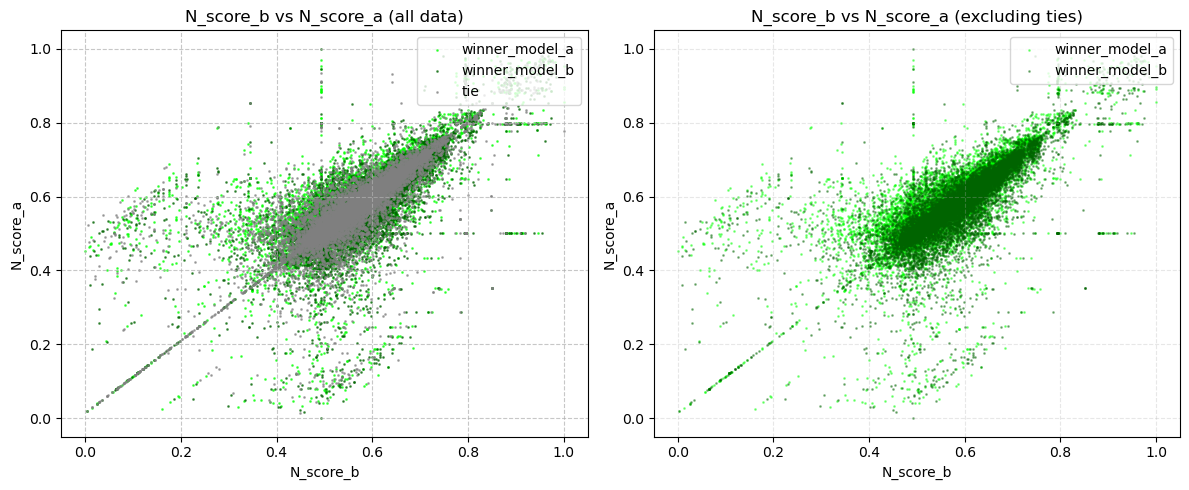

In [55]:
sampling = 1
df_sample = df.sample(n=int(sampling*len(df)))
plot_scatter(df_sample, 'N_score_a', 'N_score_b')

### Histograms for 💡 Novelty Score

We can better visualize this correlation by calculating all the differences between the score of the "winner" response and the score of the "loser" response. It is clearly noticeable that winner responses tend to score higher in this metric. Furthermore, we can observe ties have a bias towards cases where the response A scores higher. 

In [56]:
def hist_feature_diff(df, feature_a, feature_b, title='Feature comparison', range_min=-0.1, range_max=0.1, nbins=100, exclude_zeroes=False):
    df['winner_vs_loser'] = df.apply(
        lambda row: row[feature_a] - row[feature_b] if row['class_label'] == 0  # Feature A vs feature B when Model A wins
        else row[feature_b] - row[feature_a], axis=1) # Feature B vs feature A otherwise

    # Non-ties
    df_non_tie = df[df['class_label'] != 2]
    mean_non_tie = df_non_tie['winner_vs_loser'].mean()
    median_non_tie = df_non_tie['winner_vs_loser'].median()
    print(f"Average {title} (winner vs loser): {mean_non_tie:.4f}")
    # Histogram:
    plt.figure(figsize=(10, 5))
    plt.hist(df_non_tie['winner_vs_loser'].dropna(), bins=nbins, color='blue', range=(range_min, range_max))
    plt.axvline(mean_non_tie, color='red', linestyle='dashed', linewidth=1)
    plt.axvline(median_non_tie, color='red', linestyle='dotted', linewidth=1)
    plt.axvline(0, color='black', linestyle='-', linewidth=2)
    plt.title(f"{title} - winner vs loser (Non-ties)")
    plt.xlabel("winner_vs_loser")
    plt.ylabel("Frequency")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

    # Response A wins:
    df_class_0 = df_non_tie[df_non_tie['class_label'] == 0]
    mean_class_0 = df_class_0['winner_vs_loser'].mean()
    median_class_0 = df_class_0['winner_vs_loser'].median()
    print(f"Average {title} (Model A wins): {mean_class_0:.4f}")
    plt.figure(figsize=(10, 5))
    plt.hist(df_class_0['winner_vs_loser'].dropna(), bins=nbins, color='orange', range=(range_min, range_max))
    plt.axvline(mean_class_0, color='red', linestyle='dashed', linewidth=1)
    plt.axvline(median_class_0, color='red', linestyle='dotted', linewidth=1)
    plt.axvline(0, color='black', linestyle='-', linewidth=2)
    plt.title(f"{title} - Model A wins (Non-ties)")
    plt.xlabel("winner_vs_loser")
    plt.ylabel("Frequency")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

    # Response B wins:
    df_class_1 = df_non_tie[df_non_tie['class_label'] == 1]
    mean_class_1 = df_class_1['winner_vs_loser'].mean()
    median_class_1 = df_class_1['winner_vs_loser'].median()
    print(f"Average {title} (Model B wins): {mean_class_1:.4f}")
    plt.figure(figsize=(10, 5))
    plt.hist(df_class_1['winner_vs_loser'].dropna(), bins=nbins, color='purple', range=(range_min, range_max))
    plt.axvline(mean_class_1, color='red', linestyle='dashed', linewidth=1)
    plt.axvline(median_class_1, color='red', linestyle='dotted', linewidth=1)
    plt.axvline(0, color='black', linestyle='-', linewidth=2)
    plt.title(f"{title} - Model B wins (Non-ties)")
    plt.xlabel("winner_vs_loser")
    plt.ylabel("Frequency")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

    # Filter for ties:
    df_tie = df[df['class_label'] == 2]
    mean_tie = df_tie['winner_vs_loser'].mean()
    median_tie = df_tie['winner_vs_loser'].median()
    print(f"Average {title} (ties): {mean_tie:.4f}")

    # Histogram for ties:
    plt.figure(figsize=(10, 5))
    plt.hist(df_tie['winner_vs_loser'].dropna(), bins=nbins, color='green', range=(range_min, range_max))
    plt.axvline(mean_tie, color='red', linestyle='dashed', linewidth=1)
    plt.axvline(median_tie, color='red', linestyle='dotted', linewidth=1)
    plt.axvline(0, color='black', linestyle='-', linewidth=2)
    plt.title(f"{title} - ties")
    plt.xlabel(f"{feature_b} vs {feature_a}")
    plt.ylabel("Frequency")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

Average Relative Novelty Score (winner vs loser): 0.0076


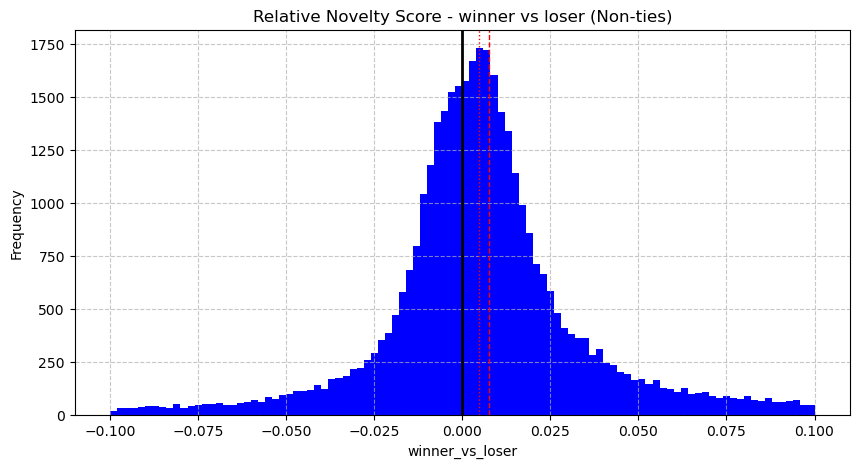

Average Relative Novelty Score (Model A wins): 0.0134


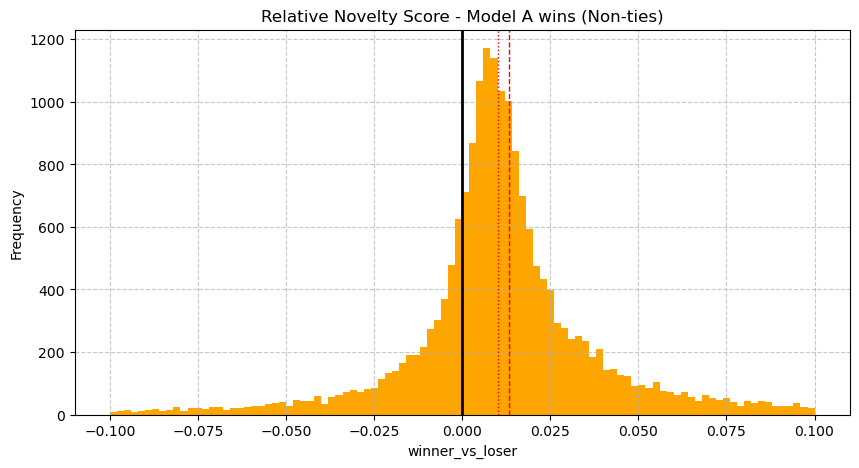

Average Relative Novelty Score (Model B wins): 0.0017


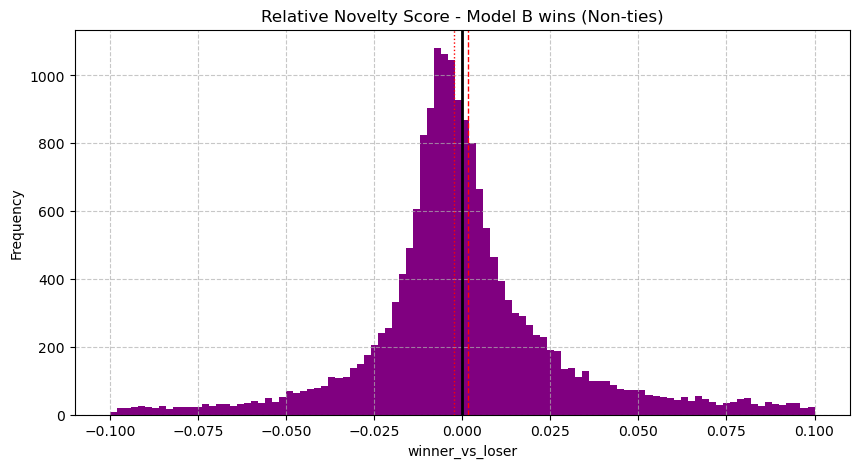

Average Relative Novelty Score (ties): -0.0070


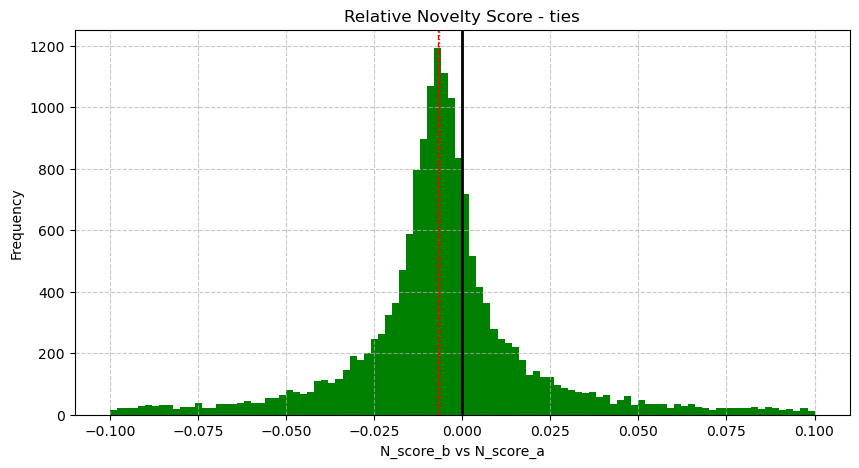

In [57]:
hist_feature_diff(df, 'N_score_a', 'N_score_b', "Relative Novelty Score", range_min=-0.1, range_max=0.1, nbins=100)

### Hexbin plots for 💡 Novelty Score

Scatter plots with such a large amount of data points and high dispersion are not very useful for understanding correlations. We will map the dots to a hexbin chart and define a metric where 1 means B is the chosen response, 0 means A is chosen, and 0.5 means a tie. By averaging all the values that fall within each hexagon in the hexbin, we can observe how the metrics we defined correlate with user preference.

In [58]:
def plot_hexbin(df, feature_a, feature_b, title='', gridsize=30, range_min=None, range_max=None):
    df = df.copy()

    fig, ax = plt.subplots(figsize=(8, 6))

    # We map each item to a value before calculating densities in the hexbin:
    # 0: A wins, 1: B wins, 0.5: Draw
    df.loc[:, 'response_b_win'] = df['class_label'].map({0: 0, 1: 1, 2: 0.5})
    # colors = plt.cm.get_cmap('coolwarm')
    colors = plt.colormaps.get_cmap('coolwarm')

    # We determine the range automatically if not provided
    if range_min is None:
        range_min = min(df[feature_a].min(), df[feature_b].min())
    if range_max is None:
        range_max = max(df[feature_a].max(), df[feature_b].max())

    # Hexbin plot for the data
    hb = ax.hexbin(df[feature_b], 
                   df[feature_a], 
                   C=df['response_b_win'],
                   gridsize=gridsize, 
                   cmap=colors, 
                   reduce_C_function=np.mean, 
                   mincnt=1,
                   extent=(range_min, range_max, range_min, range_max))

    ax.set_xlabel(feature_b)
    ax.set_ylabel(feature_a)
    ax.set_title(f'{feature_b} vs {feature_a} - {title}')
    ax.grid(True, linestyle='--', alpha=0.7)
    fig.colorbar(hb, ax=ax, label='Response B Win Density')
    plt.tight_layout()
    plt.show()

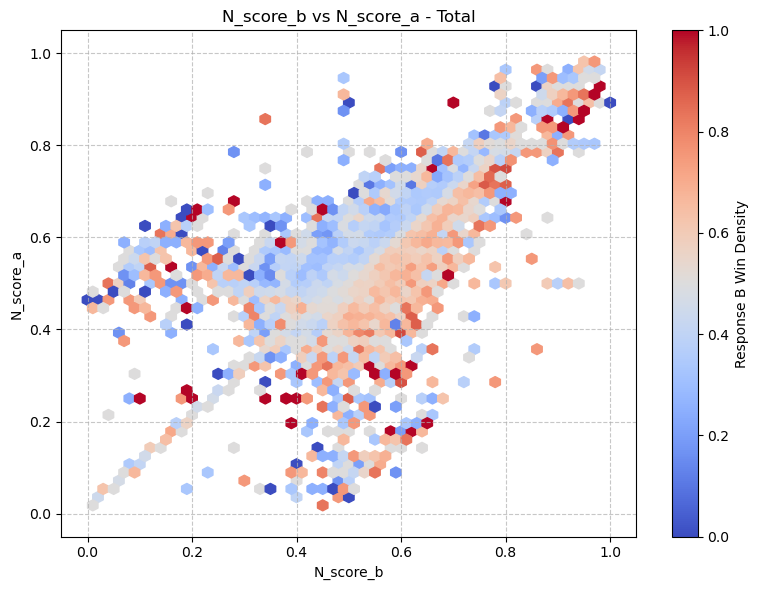

In [59]:
plot_hexbin(df, 'N_score_a', 'N_score_b', title='Total',gridsize=50)

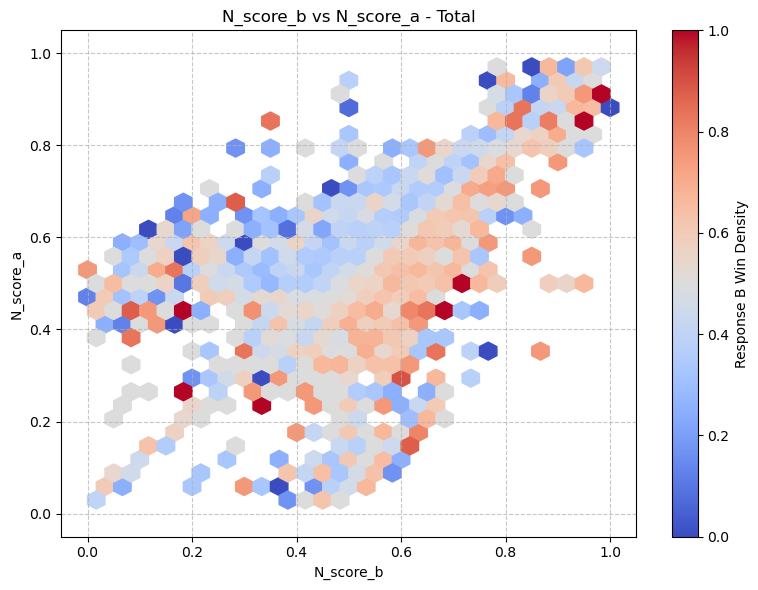

Regular questions (question-instruction). N scores have generally high predictive value:


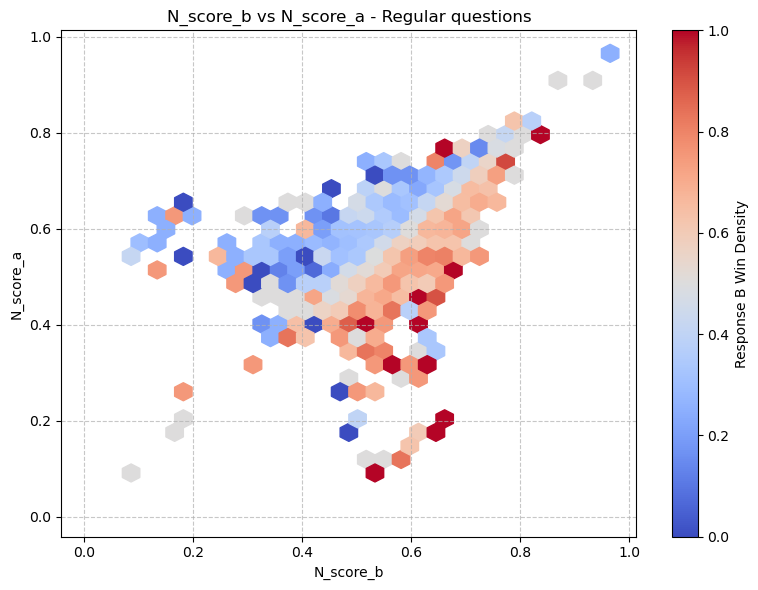

Trick questions (question-problem). N scores have low predictive value


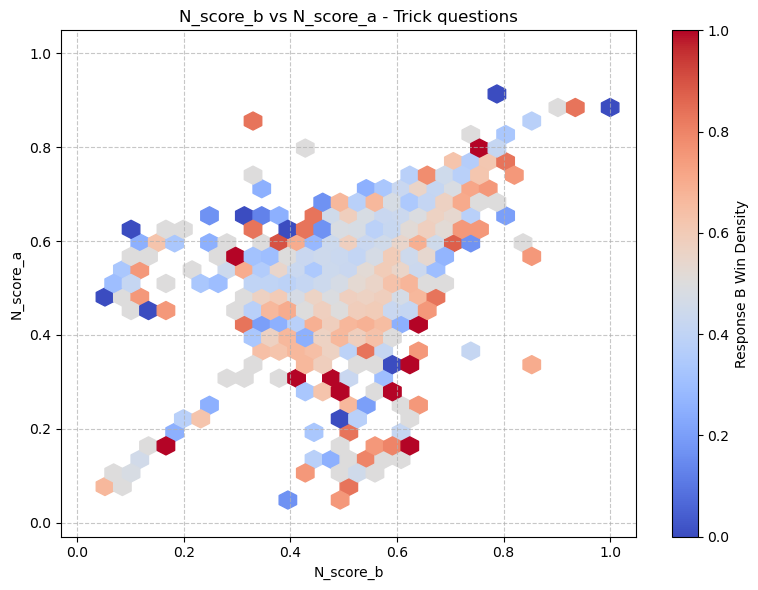

Regular requests (request-instruction). Medium and low N scores have more predictive value:


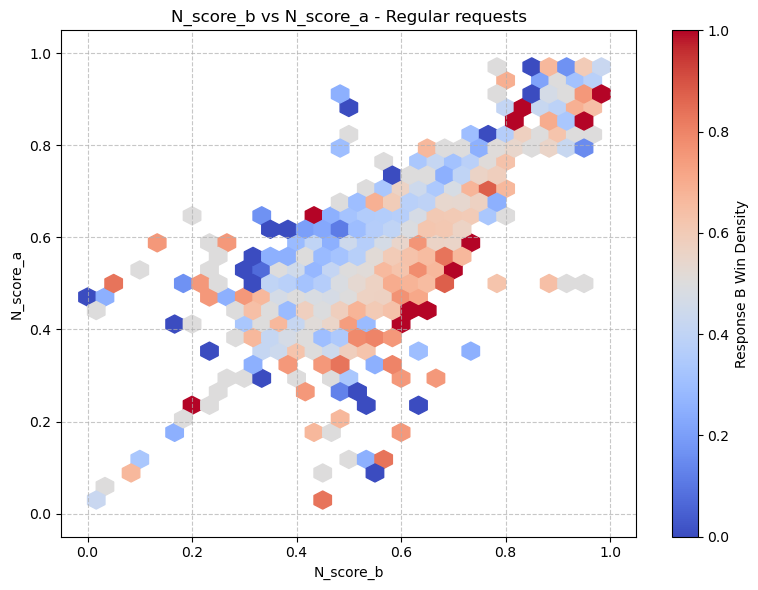

Problem-solving requests (request-problem). Medium and high N scores have more predictive value:


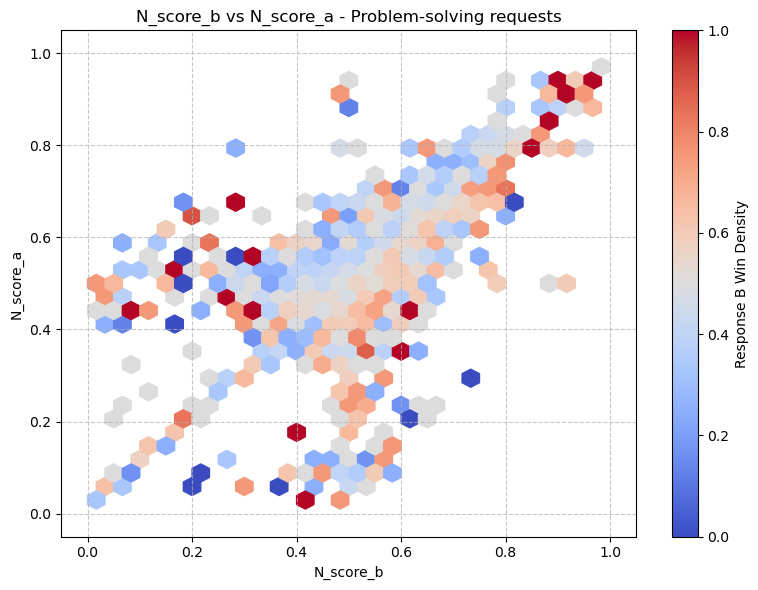

In [60]:
sampling = 1 # No need to sample with this chart, but I keep this just to reuse the variable names with the _sample suffix
resolution = 30
df_sample = df.sample(n=int(sampling*len(df)))
plot_hexbin(df_sample, 'N_score_a', 'N_score_b', title='Total', gridsize=resolution)

print('Regular questions (question-instruction). N scores have generally high predictive value:')
df_sample_qi = df_sample[(df_sample['label_rq'] == 'question') & (df_sample['label_tl'] == 'instruction')]
plot_hexbin(df_sample_qi, 'N_score_a', 'N_score_b', title='Regular questions', gridsize=resolution)

print('Trick questions (question-problem). N scores have low predictive value')
df_sample_qp = df_sample[(df_sample['label_rq'] == 'question') & (df_sample['label_tl'] == 'problem')]
plot_hexbin(df_sample_qp, 'N_score_a', 'N_score_b', title='Trick questions', gridsize=resolution)

print('Regular requests (request-instruction). Medium and low N scores have more predictive value:')
df_sample_ri = df_sample[(df_sample['label_rq'] == 'request') & (df_sample['label_tl'] == 'instruction')]
plot_hexbin(df_sample_ri, 'N_score_a', 'N_score_b', title='Regular requests', gridsize=resolution)

print('Problem-solving requests (request-problem). Medium and high N scores have more predictive value:')
df_sample_rp = df_sample[(df_sample['label_rq'] == 'request') & (df_sample['label_tl'] == 'problem')]
plot_hexbin(df_sample_rp, 'N_score_a', 'N_score_b', title='Problem-solving requests', gridsize=resolution)

# 7. SC features (🎯 Specificity Score, 🧩 Coherency Score)

TextBlob Example:

In [61]:
def get_sentiment(text):
  sentiment = TextBlob(text).sentiment
  polarity_score = sentiment.polarity  # Between -1 (negative) and 1 (positive)
  subjectivity_score = sentiment.subjectivity  # Between 0 (objective) and 1 (subjective)
  return polarity_score, subjectivity_score


text = "As a large language model I'm proud of my ability to pass butter."
polarity_score, subjectivity_score = get_sentiment(text)

print(text)
print(f"Polarity: {polarity_score}")
print(f"Subjectivity: {subjectivity_score}")
text2 = "As a small language model I lack the ability to pass butter."
polarity_score2, subjectivity_score2 = get_sentiment(text2)
print(text2)
print(f"Polarity: {polarity_score2}")
print(f"Subjectivity: {subjectivity_score2}")
print("POLARITY: Between -1 (negative sentiment) and 1 (positive sentiment)")
print("SUBJECTIVITY: Between 0 (objective) and 1 (subjective)")

As a large language model I'm proud of my ability to pass butter.
Polarity: 0.5071428571428571
Subjectivity: 0.7142857142857143
As a small language model I lack the ability to pass butter.
Polarity: -0.25
Subjectivity: 0.4
POLARITY: Between -1 (negative sentiment) and 1 (positive sentiment)
SUBJECTIVITY: Between 0 (objective) and 1 (subjective)


Example from dataset

In [62]:
if not sampled:
    sa_test_prompt, sa_test_ra, sa_test_rb = df.loc[df['id'] == 2747109329, ['prompt', 'response_a', 'response_b']].values.flatten()
    polarity_score_p, subjectivity_score_p = get_sentiment(sa_test_prompt)
    polarity_score_ra, subjectivity_score_ra = get_sentiment(sa_test_ra)
    polarity_score_rb, subjectivity_score_rb = get_sentiment(sa_test_rb)

    print(sa_test_prompt)
    print(f"Polarity: {polarity_score_p}")
    print(f"Subjectivity: {subjectivity_score_p}")
    print(sa_test_ra)
    print(f"Polarity: {polarity_score_ra}")
    print(f"Subjectivity: {subjectivity_score_ra}")
    print(sa_test_rb)
    print(f"Polarity: {polarity_score_rb}")
    print(f"Subjectivity: {subjectivity_score_rb}")

What will the weather be like tomorrow?
Polarity: 0.0
Subjectivity: 0.0
I'm sorry, I cannot provide you with the weather forecast since I am an AI language model and do not have real-time access to weather data. However, you can check the weather forecast on your local news channel or on a weather website.
Polarity: -0.25
Subjectivity: 0.5
The weather is expected to be sunny tomorrow.
Polarity: -0.1
Subjectivity: 0.4


#### Metrics

* Specificity score: 1 - rel_subj - abs(0.5-subj) 
* Coherency score: abs(pol_p) - abs(pol_r)

In [63]:
def apply_sa_to_df(df):
    def process_row(row):
        prompt = row['prompt']
        ra = row['response_a']
        rb = row['response_b']
        polarity_score_p, subjectivity_score_p = get_sentiment(prompt)
        polarity_score_ra, subjectivity_score_ra = get_sentiment(ra)
        polarity_score_rb, subjectivity_score_rb = get_sentiment(rb)
        return pd.Series({
            'pol_p': polarity_score_p,
            'pol_ra': polarity_score_ra,
            'pol_rb': polarity_score_rb,
            'rel_pol_ra': polarity_score_ra-polarity_score_p,
            'rel_pol_rb': polarity_score_rb-polarity_score_p,
            'subj_p': subjectivity_score_p,
            'subj_ra': subjectivity_score_ra,
            'subj_rb': subjectivity_score_rb,
            'rel_subj_ra': subjectivity_score_ra-subjectivity_score_p,
            'rel_subj_rb': subjectivity_score_rb-subjectivity_score_p
        })
    tqdm.pandas()
    # Apply the function to each row
    sa_results = df.progress_apply(process_row, axis=1)
    # sa_results = df.apply(process_row, axis=1)
    columns = ['pol_p', 'pol_ra', 'pol_rb', 'rel_pol_ra', 'rel_pol_rb',
               'subj_p', 'subj_ra', 'subj_rb', 'rel_subj_ra', 'rel_subj_rb']
    # Add the new columns to the original DataFrame
    df[columns] = sa_results
    return df

In [97]:
if not preload_data:    
    ##### LONG EXECUTION #####
    df = apply_sa_to_df(df)
    display(df.head())
    ##### LONG EXECUTION #####
    if not sampled: df.to_pickle('df_with_tfidf_sa.pkl')

100%|██████████| 56885/56885 [01:46<00:00, 535.72it/s]


id             model_a              model_b  \
0   30192  gpt-4-1106-preview           gpt-4-0613   
1   53567           koala-13b           gpt-4-0613   
2   65089  gpt-3.5-turbo-0613       mistral-medium   
3   96401    llama-2-13b-chat  mistral-7b-instruct   
4  198779           koala-13b   gpt-3.5-turbo-0314   

                                              prompt  \
0  Is it morally right to try to have a certain p...   
1  What is the difference between marriage licens...   
2  explain function calling. how would you call a...   
3  How can I create a test set for a very rare ca...   
4  What is the best way to travel from Tel-Aviv t...   

                                          response_a  \
0  The question of whether it is morally right to...   
1  A marriage license is a legal document that al...   
2  Function calling is the process of invoking or...   
3  Creating a test set for a very rare category c...   
4  The best way to travel from Tel Aviv to Jerusa...   

                                          response_b  winner_model_a  \
0  As an AI, I don't have personal beliefs or opi...               1   
1  A marriage license and a marriage certificate ...               0   
2  Function calling is the process of invoking a ...               0   
3  When building a classifier for a very rare cat...               1   
4  The best way to travel from Tel-Aviv to Jerusa...               0   

   winner_model_b  winner_tie      class_name  ...  pol_p    pol_ra    pol_rb  \
0               0           0  winner_model_a  ...   0.25  0.059367  0.072727   
1               1           0  winner_model_b  ...   0.00  0.040693  0.100255   
2               0           1      winner_tie  ...   0.00  0.270238  0.083333   
3               0           0  winner_model_a  ...   0.39  0.160765  0.220944   
4               1           0  winner_model_b  ...   1.00  0.203846  0.194872   

  rel_pol_ra rel_pol_rb    subj_p   subj_ra   subj_rb rel_subj_ra  rel_subj_rb  
0  -0.190633  -0.177273  0.553571  0.493484  0.412338   -0.060088    -0.141234  
1   0.040693   0.100255  0.000000  0.326948  0.308418    0.326948     0.308418  
2   0.270238   0.083333  0.000000  0.571429  0.197024    0.571429     0.197024  
3  -0.229235  -0.169056  1.000000  0.607517  0.557099   -0.392483    -0.442901  
4  -0.796154  -0.805128  0.300000  0.476923  0.443590    0.176923     0.143590  

[5 rows x 38 columns]

Test file:

In [64]:
test_df = apply_sa_to_df(test_df)
display(test_df)

100%|██████████| 3/3 [00:00<00:00, 600.13it/s]


id                                             prompt  \
0   136060  I have three oranges today, I ate an orange ye...   
1   211333  You are a mediator in a heated political debat...   
2  1233961  How to initialize the classification head when...   

                                          response_a  \
0                        You have two oranges today.   
1  Thank you for sharing the details of the situa...   
2  When you want to initialize the classification...   

                                          response_b  encode_fail  \
0  You still have three oranges. Eating an orange...        False   
1  Mr Reddy and Ms Blue both have valid points in...        False   
2  To initialize the classification head when per...        False   

                                             options  \
0  [Prompt: I have three oranges today, I ate an ...   
1  [Prompt: You are a mediator in a heated politi...   
2  [Prompt: How to initialize the classification ...   

                                      trimmed_prompt  label_rq   prob_rq  \
0  i have three oranges today, i ate an orange ye...  question  0.931602   
1  you are a mediator in a heated political debat...   request  0.807346   
2  how to initialize the classification head when...  question  0.758176   

     r_vs_q  ...   p_tc  ra_tc  rb_tc  p_chtk_ratio  ra_chtk_ratio  \
0  0.068398  ...   23.0    9.0   25.0      3.902903       3.851641   
1  0.807346  ...  105.0  246.0   89.0      4.698573       5.921888   
2  0.241824  ...   43.0  368.0  512.0      4.437942       4.994399   

   rb_chtk_ratio  B_score_a  B_score_b  SCBN_score_a  SCBN_score_b  
0       4.780530        0.5        0.5      2.500000      2.933203  
1       5.240777        0.0        0.0      1.273098      0.991468  
2       4.158742        1.0        1.0      2.000000      2.000000  

[3 rows x 49 columns]

### Calculate Specificity and Coherency scores:

* Specificity score: 1 - rel_subj - abs(0.5-subj) 
* Coherency score: abs(pol_p) - abs(pol_r)

In [65]:
# df = pd.read_pickle('df_with_tfidf_sa.pkl')
# sampled = False
# if sampled:
#  sampling = 0.01
#  df = df.sample(n=int(sampling*len(df)))
print(df.shape)

(56885, 58)


In [66]:
df['S_score_a'] = 1 - df['rel_subj_ra'] - 1*abs(0.5-df['subj_ra']) # The 1* is to experiment with different ways absolute subjectivity can penalize
df['S_score_b'] = 1 - df['rel_subj_rb'] - 1*abs(0.5-df['subj_rb'])

df['C_score_a'] = abs(df['pol_p']) - abs(df['pol_ra'])
df['C_score_b'] = abs(df['pol_p']) - abs(df['pol_rb'])
display(df.head(2))

id             model_a     model_b  \
0  30192  gpt-4-1106-preview  gpt-4-0613   
1  53567           koala-13b  gpt-4-0613   

                                              prompt  \
0  Is it morally right to try to have a certain p...   
1  What is the difference between marriage licens...   

                                          response_a  \
0  The question of whether it is morally right to...   
1  A marriage license is a legal document that al...   

                                          response_b  winner_model_a  \
0  As an AI, I don't have personal beliefs or opi...               1   
1  A marriage license and a marriage certificate ...               0   

   winner_model_b  winner_tie      class_name  ...  p_tc  ra_tc  rb_tc  \
0               0           0  winner_model_a  ...  19.0  512.0  148.0   
1               1           0  winner_model_b  ...  13.0  138.0  242.0   

  p_chtk_ratio ra_chtk_ratio  rb_chtk_ratio  B_score_a  B_score_b  \
0     5.349794      5.729299       4.999658   0.715201   0.482926   
1     6.630336      5.021690       5.324778   0.694830   0.758144   

  SCBN_score_a  SCBN_score_b  
0     2.700483      2.432827  
1     2.284431      2.334343  

[2 rows x 58 columns]

Test file:

In [67]:
test_df['S_score_a'] = 1 - test_df['rel_subj_ra'] - 1*abs(0.5-test_df['subj_ra'])
test_df['S_score_b'] = 1 - test_df['rel_subj_rb'] - 1*abs(0.5-test_df['subj_ra'])
test_df['C_score_a'] = abs(test_df['pol_p']) - abs(test_df['pol_ra'])
test_df['C_score_b'] = abs(test_df['pol_p']) - abs(test_df['pol_rb'])
display(test_df)

id                                             prompt  \
0   136060  I have three oranges today, I ate an orange ye...   
1   211333  You are a mediator in a heated political debat...   
2  1233961  How to initialize the classification head when...   

                                          response_a  \
0                        You have two oranges today.   
1  Thank you for sharing the details of the situa...   
2  When you want to initialize the classification...   

                                          response_b  encode_fail  \
0  You still have three oranges. Eating an orange...        False   
1  Mr Reddy and Ms Blue both have valid points in...        False   
2  To initialize the classification head when per...        False   

                                             options  \
0  [Prompt: I have three oranges today, I ate an ...   
1  [Prompt: You are a mediator in a heated politi...   
2  [Prompt: How to initialize the classification ...   

                                      trimmed_prompt  label_rq   prob_rq  \
0  i have three oranges today, i ate an orange ye...  question  0.931602   
1  you are a mediator in a heated political debat...   request  0.807346   
2  how to initialize the classification head when...  question  0.758176   

     r_vs_q  ...   p_tc  ra_tc  rb_tc  p_chtk_ratio  ra_chtk_ratio  \
0  0.068398  ...   23.0    9.0   25.0      3.902903       3.851641   
1  0.807346  ...  105.0  246.0   89.0      4.698573       5.921888   
2  0.241824  ...   43.0  368.0  512.0      4.437942       4.994399   

   rb_chtk_ratio  B_score_a  B_score_b  SCBN_score_a  SCBN_score_b  
0       4.780530        0.5        0.5      2.500000      2.933203  
1       5.240777        0.0        0.0      1.273098      0.991468  
2       4.158742        1.0        1.0      2.000000      2.000000  

[3 rows x 49 columns]

In [68]:
scaler = MinMaxScaler()
scn_scores = df[['S_score_a', 'S_score_b', 'C_score_a', 'C_score_b', 'N_score_a', 'N_score_b']]
scaled_scores = scaler.fit_transform(scn_scores)
df[['S_score_a', 'S_score_b', 'C_score_a', 'C_score_b', 'N_score_a', 'N_score_b']] = scaled_scores

df[['tfidf_prompt', 'tfidf_ra',
    'tfidf_rb', 'rel_pol_ra', 'rel_pol_rb', 'rel_subj_ra', 'rel_subj_rb', 'S_score_a',
    'S_score_b', 'C_score_a', 'C_score_b', 'N_score_a', 'N_score_b']].describe()

tfidf_prompt      tfidf_ra      tfidf_rb    rel_pol_ra    rel_pol_rb  \
count  56885.000000  56885.000000  56885.000000  56885.000000  56885.000000   
mean       0.286754      0.130174      0.129771      0.016147      0.015430   
std        0.155145      0.128997      0.127599      0.251039      0.251615   
min        0.000000      0.000000      0.000000     -1.500000     -1.600000   
25%        0.182557      0.065159      0.064870     -0.080000     -0.081250   
50%        0.273689      0.089071      0.088817      0.025000      0.025000   
75%        0.367048      0.142666      0.141862      0.145172      0.145139   
max        1.000000      1.000000      1.000000      1.600000      1.360000   

        rel_subj_ra   rel_subj_rb     S_score_a     S_score_b     C_score_a  \
count  56885.000000  56885.000000  56885.000000  56885.000000  56885.000000   
mean       0.153733      0.153933      0.595494      0.595299      0.497519   
std        0.322603      0.323137      0.161953      0.161991      0.113076   
min       -1.000000     -1.000000      0.000000      0.000000      0.000000   
25%       -0.035879     -0.035417      0.500000      0.500000      0.438725   
50%        0.126046      0.128152      0.590208      0.589286      0.489534   
75%        0.409179      0.410443      0.713235      0.713492      0.537500   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

          C_score_b     N_score_a     N_score_b  
count  56885.000000  56885.000000  56885.000000  
mean       0.497375      0.578290      0.572024  
std        0.113295      0.091225      0.092887  
min        0.000000      0.000000      0.000000  
25%        0.438194      0.528566      0.521177  
50%        0.489167      0.581748      0.575632  
75%        0.537879      0.629313      0.623518  
max        1.000000      1.000000      1.000000

Test file:

In [69]:
scaler = MinMaxScaler()
scn_scores_test = test_df[['S_score_a', 'S_score_b', 'C_score_a', 'C_score_b', 'N_score_a', 'N_score_b']]
scaled_scores_test = scaler.fit_transform(scn_scores_test)
test_df[['S_score_a', 'S_score_b', 'C_score_a', 'C_score_b', 'N_score_a', 'N_score_b']] = scaled_scores_test
display(test_df)

id                                             prompt  \
0   136060  I have three oranges today, I ate an orange ye...   
1   211333  You are a mediator in a heated political debat...   
2  1233961  How to initialize the classification head when...   

                                          response_a  \
0                        You have two oranges today.   
1  Thank you for sharing the details of the situa...   
2  When you want to initialize the classification...   

                                          response_b  encode_fail  \
0  You still have three oranges. Eating an orange...        False   
1  Mr Reddy and Ms Blue both have valid points in...        False   
2  To initialize the classification head when per...        False   

                                             options  \
0  [Prompt: I have three oranges today, I ate an ...   
1  [Prompt: You are a mediator in a heated politi...   
2  [Prompt: How to initialize the classification ...   

                                      trimmed_prompt  label_rq   prob_rq  \
0  i have three oranges today, i ate an orange ye...  question  0.931602   
1  you are a mediator in a heated political debat...   request  0.807346   
2  how to initialize the classification head when...  question  0.758176   

     r_vs_q  ...   p_tc  ra_tc  rb_tc  p_chtk_ratio  ra_chtk_ratio  \
0  0.068398  ...   23.0    9.0   25.0      3.902903       3.851641   
1  0.807346  ...  105.0  246.0   89.0      4.698573       5.921888   
2  0.241824  ...   43.0  368.0  512.0      4.437942       4.994399   

   rb_chtk_ratio  B_score_a  B_score_b  SCBN_score_a  SCBN_score_b  
0       4.780530        0.5        0.5      2.500000      2.933203  
1       5.240777        0.0        0.0      1.273098      0.991468  
2       4.158742        1.0        1.0      2.000000      2.000000  

[3 rows x 49 columns]

### Histograms for 🎯 Specificity Score

At the moment of writing this comment, the correlation of Specificity score with human preference is confirmed, but the model used for sentiment analysis fails to classify a large number of prompts and responses, leading to relative scores of 0 (as observed in the histograms). This simply means there's room for improvement in our model when we use a more advanced sentiment analysis model tailored for this dataset (WORK IN PROGRESS AS I DEVELOP THIS NOTEBOOK AND PUBLISH MY FINDINGS)

Average Relative Specificity Score (winner vs loser): 0.0082


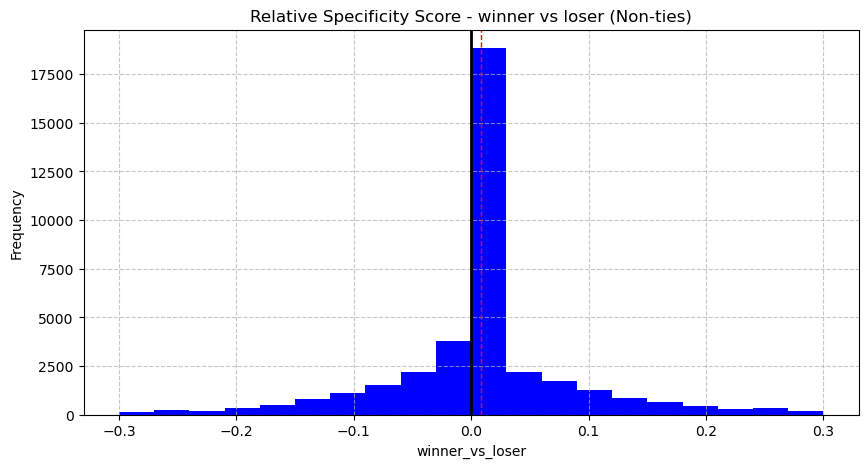

Average Relative Specificity Score (Model A wins): 0.0085


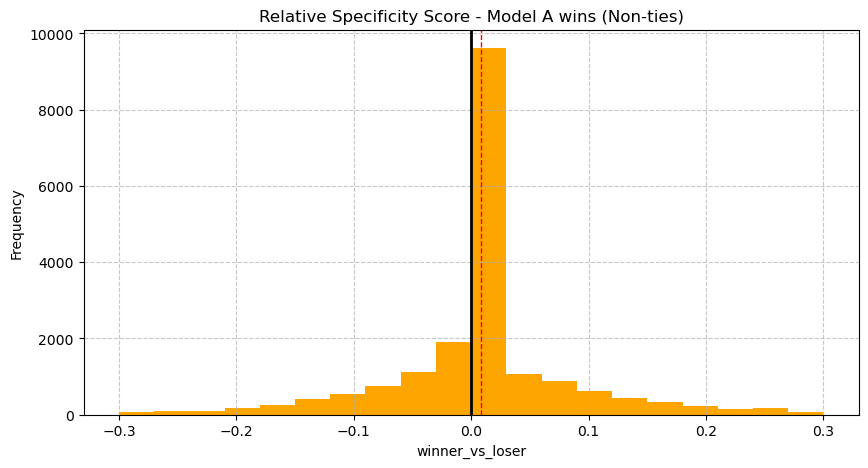

Average Relative Specificity Score (Model B wins): 0.0079


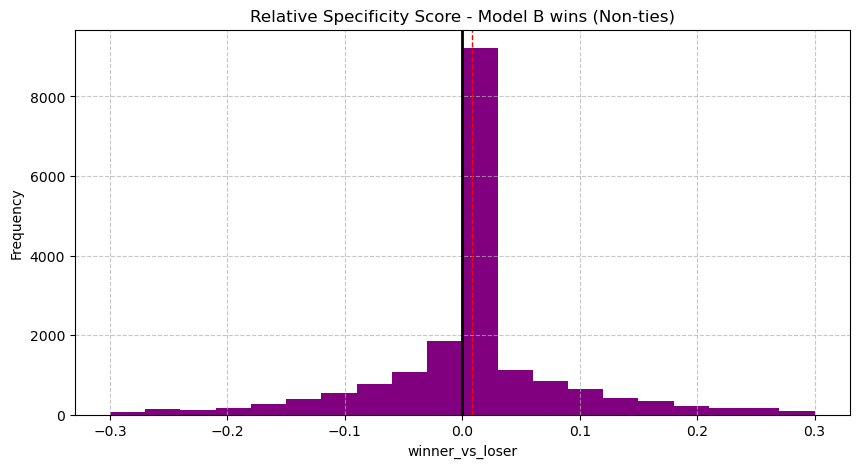

Average Relative Specificity Score (ties): 0.0002


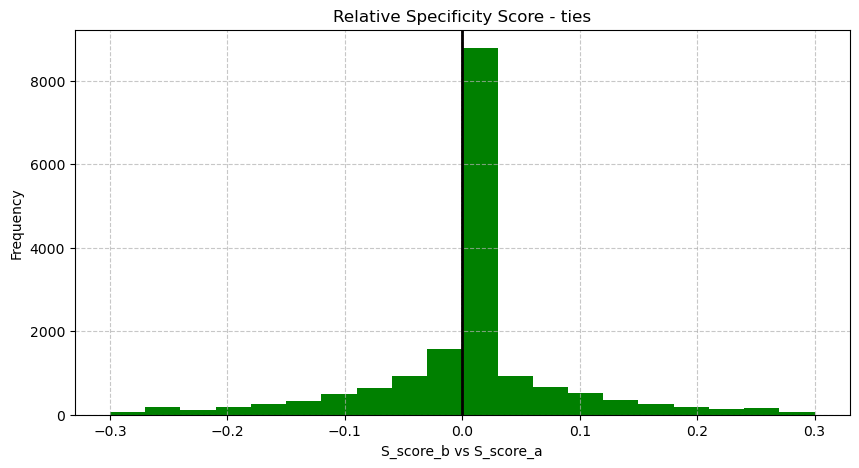

In [70]:
hist_feature_diff(df, 'S_score_a', 'S_score_b', "Relative Specificity Score", range_min=-0.3, range_max=0.3, nbins=20)

### Hexbin plots for 🎯 Specificity Score

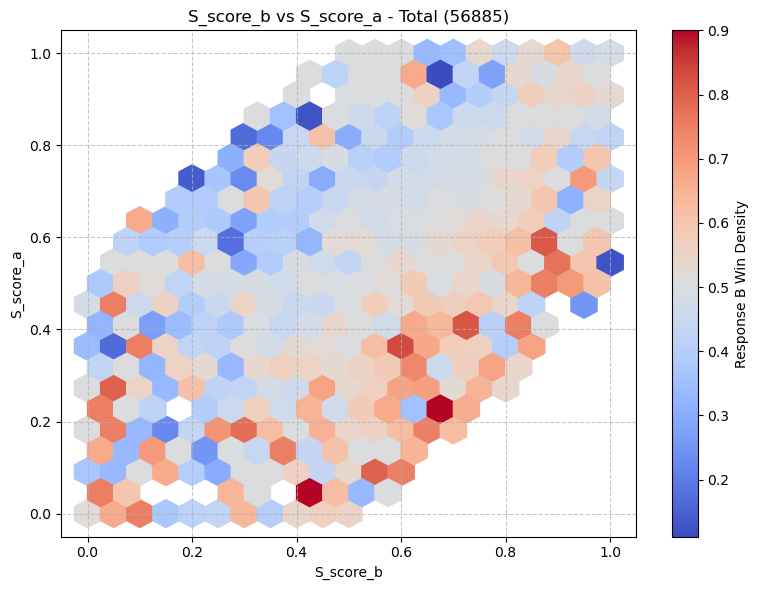

In [71]:
plot_hexbin(df, 'S_score_a', 'S_score_b', title=f'Total ({df.shape[0]})', gridsize=20)

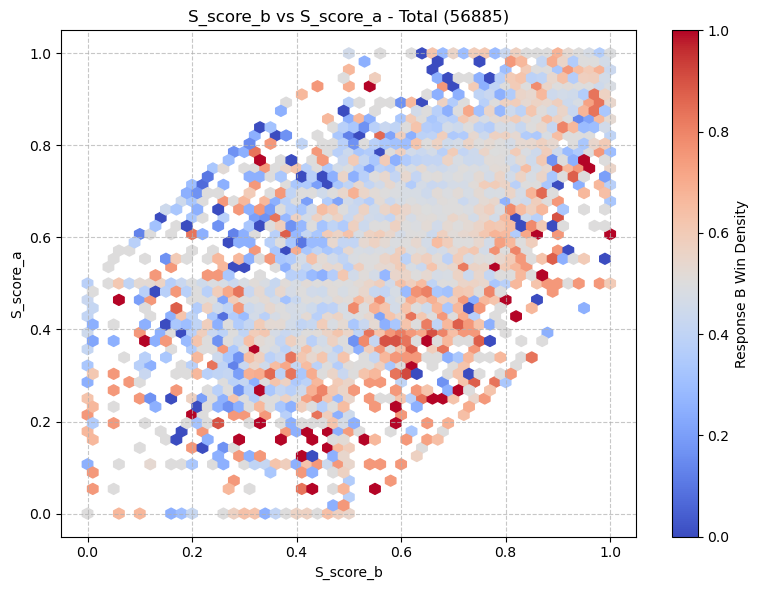

Regular questions (question-instruction). S scores are mildly correlated with user choice, specially in the extremes:


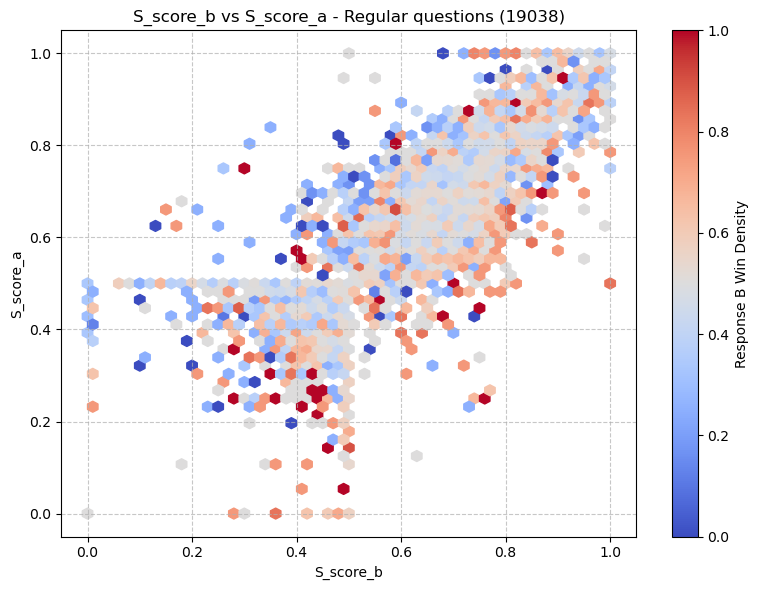

Trick questions (question-problem). S scores have higher predictive value in the mid-range


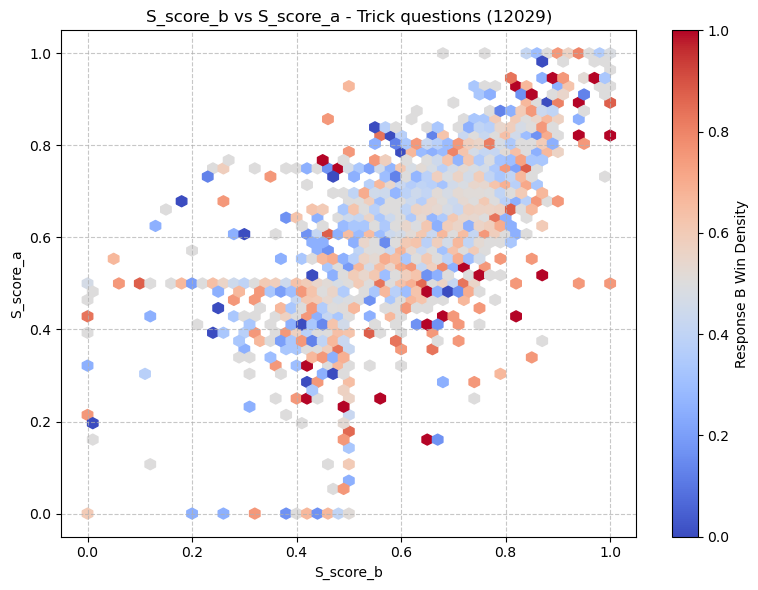

Regular requests (request-instruction). S scores have the lowest predictive value:


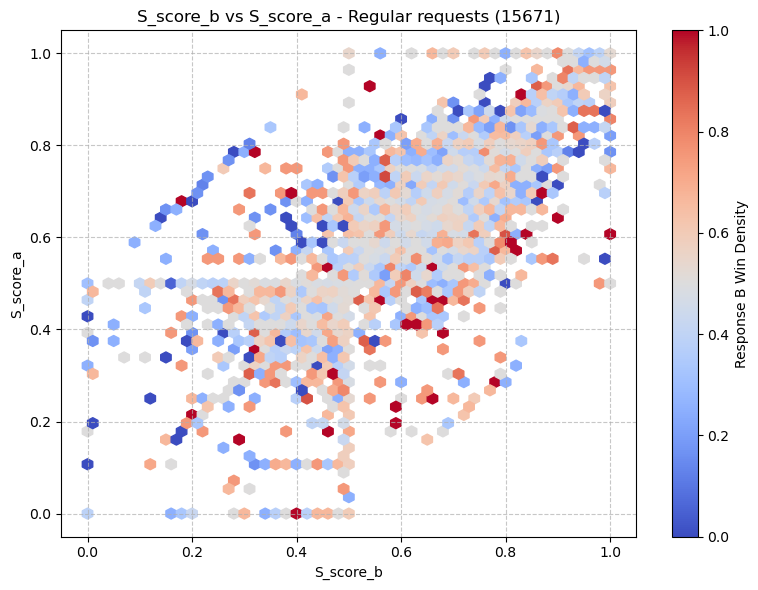

Problem-solving requests (request-problem). S scores have more predictive value than C scores, specially near the extremes (see C-score plots):


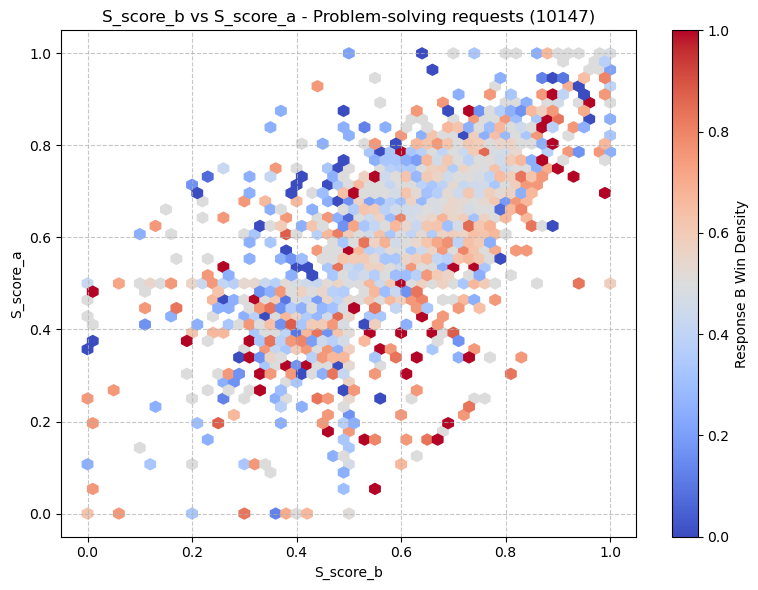

In [72]:
resolution = 50
plot_hexbin(df, 'S_score_a', 'S_score_b', title=f'Total ({df.shape[0]})', gridsize=resolution)

print('Regular questions (question-instruction). S scores are mildly correlated with user choice, specially in the extremes:')
df_qi = df[(df['label_rq'] == 'question') & (df['label_tl'] == 'instruction')]
plot_hexbin(df_qi, 'S_score_a', 'S_score_b', title=f'Regular questions ({df_qi.shape[0]})', gridsize=resolution)

print('Trick questions (question-problem). S scores have higher predictive value in the mid-range')
df_qp = df[(df['label_rq'] == 'question') & (df['label_tl'] == 'problem')]
plot_hexbin(df_qp, 'S_score_a', 'S_score_b', title=f'Trick questions ({df_qp.shape[0]})', gridsize=resolution)

print('Regular requests (request-instruction). S scores have the lowest predictive value:')
df_ri = df[(df['label_rq'] == 'request') & (df['label_tl'] == 'instruction')]
plot_hexbin(df_ri, 'S_score_a', 'S_score_b', title=f'Regular requests ({df_ri.shape[0]})', gridsize=resolution)

print('Problem-solving requests (request-problem). S scores have more predictive value than C scores, specially near the extremes (see C-score plots):')
df_rp = df[(df['label_rq'] == 'request') & (df['label_tl'] == 'problem')]
plot_hexbin(df_rp, 'S_score_a', 'S_score_b', title=f'Problem-solving requests ({df_rp.shape[0]})', gridsize=resolution)

### Histograms for 🧩 Coherency Score

Average Relative Coherency Score (winner vs loser): 0.0033


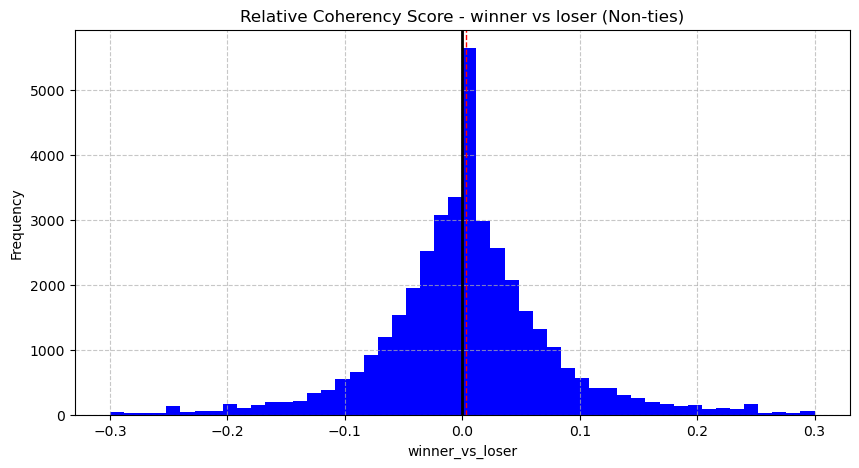

Average Relative Coherency Score (Model A wins): 0.0034


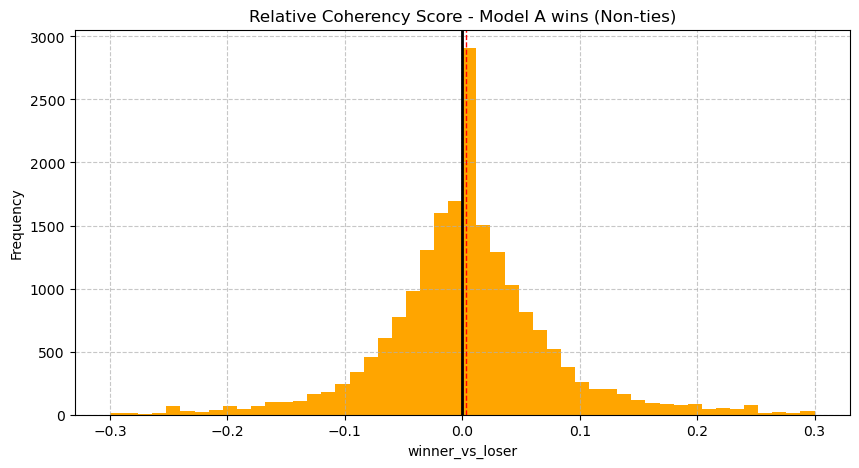

Average Relative Coherency Score (Model B wins): 0.0032


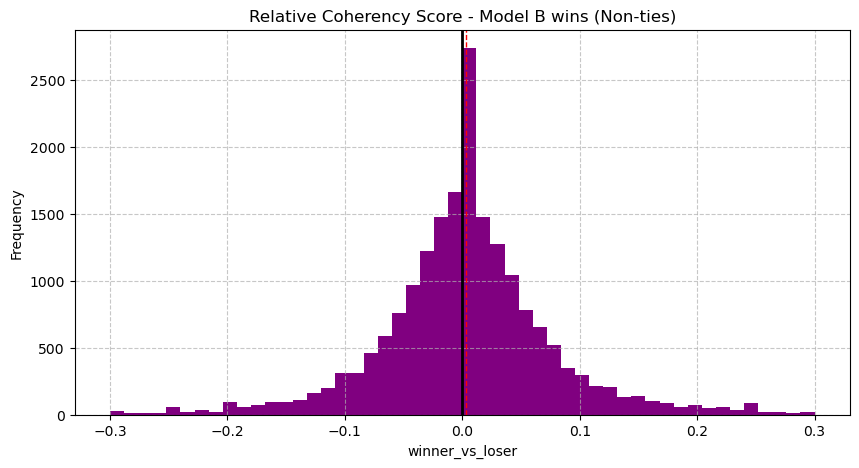

Average Relative Coherency Score (ties): -0.0002


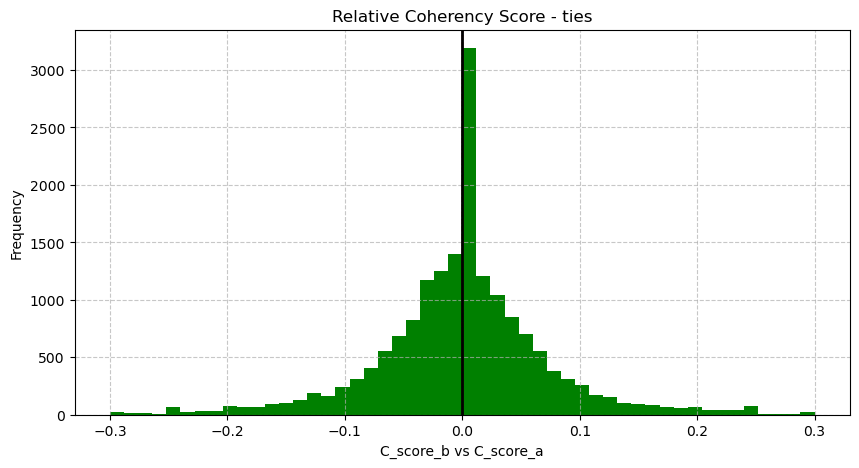

In [73]:
hist_feature_diff(df, 'C_score_a', 'C_score_b', "Relative Coherency Score", range_min=-0.3, range_max=0.3, nbins=50)

### Hexbin plots for 🧩 Coherency Score

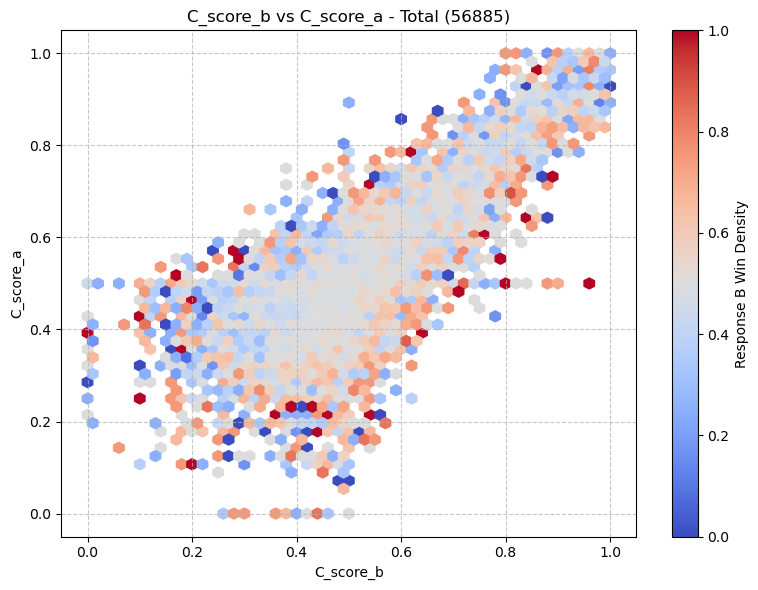

Regular questions (question-instruction). C scores are mildly correlated with user choice, specially in the extremes:


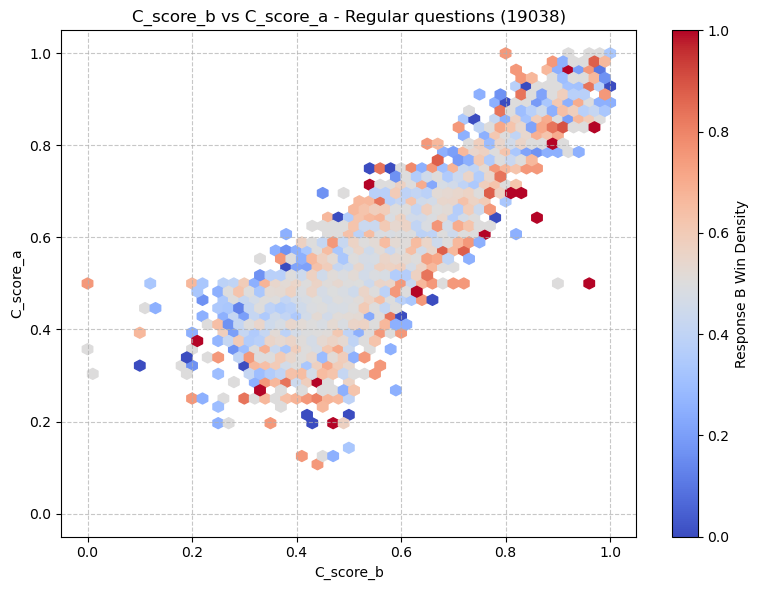

Trick questions (question-problem). C scores have higher predictive value in the mid-range


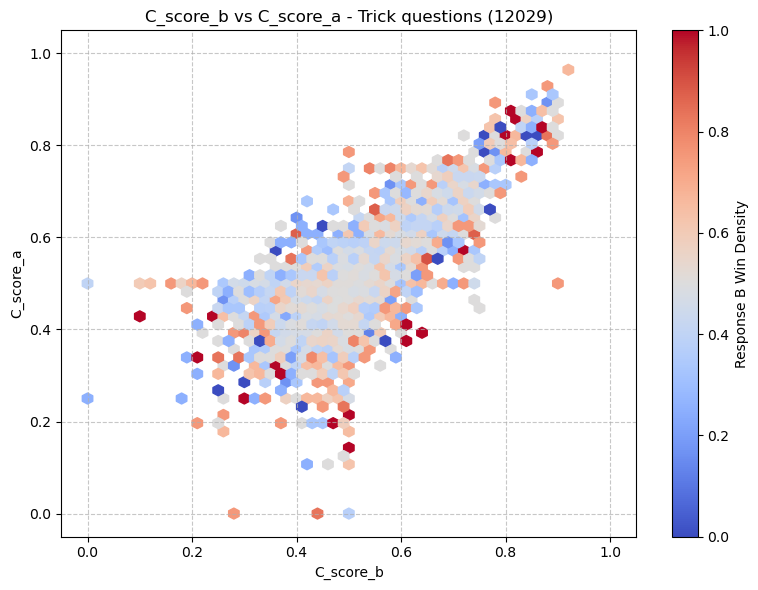

Regular requests (request-instruction). C scores have higher predictive value in the mid-range:


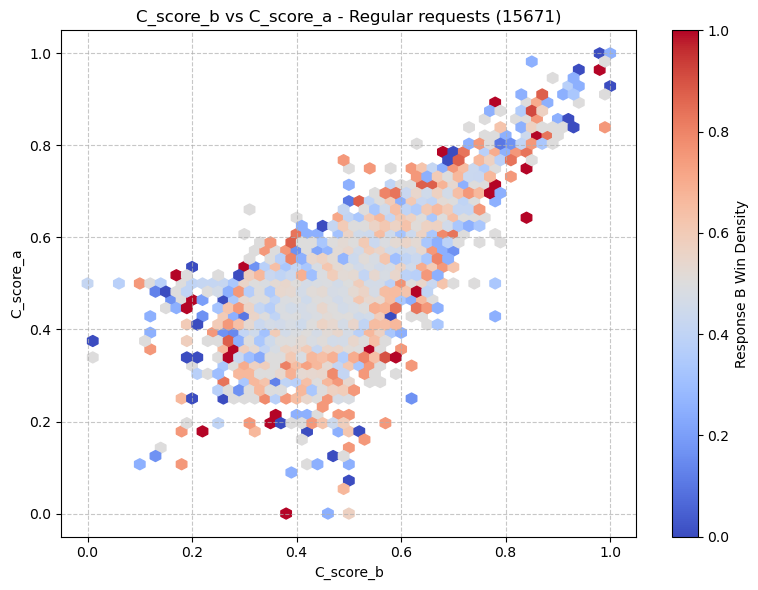

Problem-solving requests (request-problem). C scores have significantly lower predictive value:


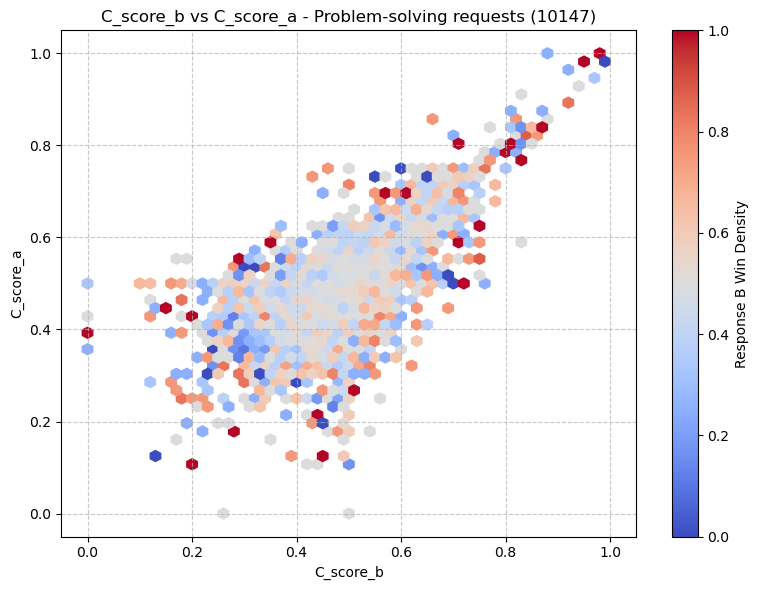

In [74]:
sampling = 1
resolution = 50
df_sample = df.sample(n=int(sampling*len(df)))
plot_hexbin(df_sample, 'C_score_a', 'C_score_b', title=f'Total ({df_sample.shape[0]})', gridsize=resolution)

print('Regular questions (question-instruction). C scores are mildly correlated with user choice, specially in the extremes:')
df_sample_qi = df_sample[(df_sample['label_rq'] == 'question') & (df_sample['label_tl'] == 'instruction')]
plot_hexbin(df_sample_qi, 'C_score_a', 'C_score_b', title=f'Regular questions ({df_sample_qi.shape[0]})', gridsize=resolution)

print('Trick questions (question-problem). C scores have higher predictive value in the mid-range')
df_sample_qp = df_sample[(df_sample['label_rq'] == 'question') & (df_sample['label_tl'] == 'problem')]
plot_hexbin(df_sample_qp, 'C_score_a', 'C_score_b', title=f'Trick questions ({df_sample_qp.shape[0]})', gridsize=resolution)

print('Regular requests (request-instruction). C scores have higher predictive value in the mid-range:')
df_sample_ri = df_sample[(df_sample['label_rq'] == 'request') & (df_sample['label_tl'] == 'instruction')]
plot_hexbin(df_sample_ri, 'C_score_a', 'C_score_b', title=f'Regular requests ({df_sample_ri.shape[0]})', gridsize=resolution)

print('Problem-solving requests (request-problem). C scores have significantly lower predictive value:')
df_sample_rp = df_sample[(df_sample['label_rq'] == 'request') & (df_sample['label_tl'] == 'problem')]
plot_hexbin(df_sample_rp, 'C_score_a', 'C_score_b', title=f'Problem-solving requests ({df_sample_rp.shape[0]})', gridsize=resolution)

### [skippable] Relative scores

In [75]:
df['S_rel'] = df['S_score_a'] - df['S_score_b']
df['C_rel'] = df['C_score_a'] - df['C_score_b']
# df['B_rel'] = df['B_score_a'] - df['B_score_b']
df['N_rel'] = df['N_score_a'] - df['N_score_b']
print(df.shape)

(56885, 58)


Test data:

In [76]:
test_df['S_rel'] = test_df['S_score_a'] - test_df['S_score_b']
test_df['C_rel'] = test_df['C_score_a'] - test_df['C_score_b']
# test_df['B_rel'] = test_df['B_score_a'] - test_df['B_score_b']
test_df['N_rel'] = test_df['N_score_a'] - test_df['N_score_b']
display(test_df)

id                                             prompt  \
0   136060  I have three oranges today, I ate an orange ye...   
1   211333  You are a mediator in a heated political debat...   
2  1233961  How to initialize the classification head when...   

                                          response_a  \
0                        You have two oranges today.   
1  Thank you for sharing the details of the situa...   
2  When you want to initialize the classification...   

                                          response_b  encode_fail  \
0  You still have three oranges. Eating an orange...        False   
1  Mr Reddy and Ms Blue both have valid points in...        False   
2  To initialize the classification head when per...        False   

                                             options  \
0  [Prompt: I have three oranges today, I ate an ...   
1  [Prompt: You are a mediator in a heated politi...   
2  [Prompt: How to initialize the classification ...   

                                      trimmed_prompt  label_rq   prob_rq  \
0  i have three oranges today, i ate an orange ye...  question  0.931602   
1  you are a mediator in a heated political debat...   request  0.807346   
2  how to initialize the classification head when...  question  0.758176   

     r_vs_q  ...   p_tc  ra_tc  rb_tc  p_chtk_ratio  ra_chtk_ratio  \
0  0.068398  ...   23.0    9.0   25.0      3.902903       3.851641   
1  0.807346  ...  105.0  246.0   89.0      4.698573       5.921888   
2  0.241824  ...   43.0  368.0  512.0      4.437942       4.994399   

   rb_chtk_ratio  B_score_a  B_score_b  SCBN_score_a  SCBN_score_b  
0       4.780530        0.5        0.5      2.500000      2.933203  
1       5.240777        0.0        0.0      1.273098      0.991468  
2       4.158742        1.0        1.0      2.000000      2.000000  

[3 rows x 49 columns]

In [84]:
#df.to_pickle('df_features.pkl')
#test_df.to_pickle('test_df.pkl')

# 8. Token length features (⌛ Brevity Score)

In [85]:
# if preload_data: df = pd.read_pickle('/kaggle/input/lmsys-chatbot-arena-scbn-rqtl-features-test-file/df_features.pkl')

In [77]:
print(df.shape)
display(df.head(2))

(56885, 58)


id             model_a     model_b  \
0  30192  gpt-4-1106-preview  gpt-4-0613   
1  53567           koala-13b  gpt-4-0613   

                                              prompt  \
0  Is it morally right to try to have a certain p...   
1  What is the difference between marriage licens...   

                                          response_a  \
0  The question of whether it is morally right to...   
1  A marriage license is a legal document that al...   

                                          response_b  winner_model_a  \
0  As an AI, I don't have personal beliefs or opi...               1   
1  A marriage license and a marriage certificate ...               0   

   winner_model_b  winner_tie      class_name  ...  p_tc  ra_tc  rb_tc  \
0               0           0  winner_model_a  ...  19.0  512.0  148.0   
1               1           0  winner_model_b  ...  13.0  138.0  242.0   

  p_chtk_ratio ra_chtk_ratio  rb_chtk_ratio  B_score_a  B_score_b  \
0     5.349794      5.729299       4.999658   0.715201   0.482926   
1     6.630336      5.021690       5.324778   0.694830   0.758144   

  SCBN_score_a  SCBN_score_b  
0     2.700483      2.432827  
1     2.284431      2.334343  

[2 rows x 58 columns]

#### Tokenization example

In [78]:
if not preload_data:
    tok_model_path = "fine-tuned-distilbert-rq"
if preload_data:
    tok_model_path = f"{RQ_PATH}fine-tuned-distilbert-rq"

tokenizer = AutoTokenizer.from_pretrained(tok_model_path)
sentence = "The quick brown fox jumps over the lazy dog"
tokens = tokenizer(sentence)
print("Tokens:", tokens)
decoded_tokens = [tokenizer.decode([token]) for token in tokens['input_ids']]
print("Decoded Tokens:", decoded_tokens)
print(len(decoded_tokens))
print(len(sentence))

Tokens: {'input_ids': [101, 1996, 4248, 2829, 4419, 14523, 2058, 1996, 13971, 3899, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
Decoded Tokens: ['[CLS]', 'the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog', '[SEP]']
11
43


#### [skippable] Example from dataset: great disparity in responses token counts

In [79]:
# sampled = False
if not sampled:
    example1 = df.loc[df['id'] == 1658663803, ['prompt', 'response_a', 'response_b']].values.flatten().tolist()
    print(f'Notice max. length of tokenizer is {tokenizer.model_max_length}, so we will longer texts')
    print(f"Prompt ({len(example1[0])} characters): {example1[0]}")
    p_tokens = tokenizer(example1[0])
    decoded_tokens = [tokenizer.decode([token]) for token in p_tokens['input_ids']]
    print(f"{len(decoded_tokens)} tokens in prompt ({len(example1[0])/len(decoded_tokens):.2f} char/tok): {decoded_tokens}")
    # Response A
    print(f"Response A ({len(example1[1])} characters):\n{example1[1]}")
    ra_tokens = tokenizer(example1[1])
    decoded_tokens = [tokenizer.decode([token]) for token in ra_tokens['input_ids']]
    print(f"### {len(decoded_tokens)} tokens in response A ({len(example1[1])/len(decoded_tokens):.2f} char/tok).###\n...\n")
    # Response B
    print(f"Response B ({len(example1[2])} characters):\n{example1[2]}")
    ra_tokens = tokenizer(example1[2])
    decoded_tokens = [tokenizer.decode([token]) for token in ra_tokens['input_ids']]
    print(f"###{len(decoded_tokens)} tokens in response B ({len(example1[2])/len(decoded_tokens):.2f} char/tok).###")

Token indices sequence length is longer than the specified maximum sequence length for this model (545 > 512). Running this sequence through the model will result in indexing errors


Notice max. length of tokenizer is 512, so we will longer texts
Prompt (30 characters): Why is trump a good president?
9 tokens in prompt (3.33 char/tok): ['[CLS]', 'why', 'is', 'trump', 'a', 'good', 'president', '?', '[SEP]']
Response A (358 characters):
As an AI, I don't have personal opinions. However, some people believe that President Trump has been a good president due to his efforts to improve the economy, his focus on job creation, and his support for certain policies such as tax cuts and deregulation. It's important to consider a wide range of perspectives when evaluating a president's performance.
### 76 tokens in response A (4.71 char/tok).###
...

Response B (2905 characters):
The perception of whether Donald Trump was a good president varies widely and is often influenced by individual political beliefs, values, and priorities. Those who view him as a good president often cite the following reasons:

1. Economic Performance: Under Trump's administration, the United States 

#### [skippable] Example from dataset: low character/token ratio (technical and software programming questions)

In [80]:
# sampled = False
if not sampled:
    example2 = df.loc[df['id'] == 856286322, ['prompt', 'response_a', 'response_b']].values.flatten().tolist()
    print(f"Prompt ({len(example2[0])} characters):\n {example2[0][:150]}\n[...]") # we just show the first 150 characters
    p_tokens = tokenizer(example2[0])
    decoded_tokens = [tokenizer.decode([token]) for token in p_tokens['input_ids']]
    print(f"{len(decoded_tokens)} tokens in prompt ({len(example2[0])/len(decoded_tokens):.2f} char/tok).")
    # Response A
    print(f"\nResponse A ({len(example2[1])} characters):\n{example2[1][:150]}\n[...]")
    ra_tokens = tokenizer(example2[1])
    decoded_tokens = [tokenizer.decode([token]) for token in ra_tokens['input_ids']]
    print(f"{len(decoded_tokens)} tokens in response A ({len(example2[1])/len(decoded_tokens):.2f} char/tok).")
    # Response B
    print(f"\nResponse B ({len(example2[2])} characters):\n{example2[2][:150]}\n[...]")
    ra_tokens = tokenizer(example2[2])
    decoded_tokens = [tokenizer.decode([token]) for token in ra_tokens['input_ids']]
    print(f"{len(decoded_tokens)} tokens in response B ({len(example2[1])/len(decoded_tokens):.2f} char/tok).")

Prompt (1523 characters):
 def author_generator(self):
redis_keys = self.redit_inst.keys('*')
for key in redis_keys:
        key_description = self.redit_inst.get(key).decode('u
[...]
550 tokens in prompt (2.77 char/tok).

Response A (876 characters):
You can apply PCA after you have generated the author embeddings. Here is where you would add it:

```python
author_embeddings = []
for i, x in enumer
[...]
262 tokens in response A (3.34 char/tok).

Response B (2521 characters):
Principal Component Analysis (PCA) is a dimensionality reduction technique that is often used to reduce the dimensionality of large datasets, increasi
[...]
675 tokens in response B (1.30 char/tok).


### Token metrics calculations

In [81]:
def calculate_token_metrics(df, tokenizer):
    model_max_length = tokenizer.model_max_length
    def calculate_metrics(row):
        # Tokenize prompt
        p_tokens = tokenizer(row['prompt'], max_length=model_max_length, truncation=True)
        p_decoded_tokens = [tokenizer.decode([token]) for token in p_tokens['input_ids']]

        # Tokenize response_a
        ra_tokens = tokenizer(row['response_a'], max_length=model_max_length, truncation=True)
        ra_decoded_tokens = [tokenizer.decode([token]) for token in ra_tokens['input_ids']]

        # Tokenize response_b
        rb_tokens = tokenizer(row['response_b'], max_length=model_max_length, truncation=True)
        rb_decoded_tokens = [tokenizer.decode([token]) for token in rb_tokens['input_ids']]

        # Calculate lengths and ratios
        p_len = len(row['prompt'])
        ra_len = len(row['response_a'])
        rb_len = len(row['response_b'])

        p_token_count = len(p_decoded_tokens)
        ra_token_count = len(ra_decoded_tokens)
        rb_token_count = len(rb_decoded_tokens)

        p_char_tok_ratio = p_len / (p_token_count -1.99) # Discount START and END tokens from ratio and avoid division by 0
        ra_char_tok_ratio = ra_len / (ra_token_count -1.99)
        rb_char_tok_ratio = rb_len / (rb_token_count -1.99)

        return pd.Series([
            p_len, ra_len, rb_len,
            p_token_count, ra_token_count, rb_token_count,
            p_char_tok_ratio, ra_char_tok_ratio, rb_char_tok_ratio
        ])


    tqdm.pandas()
    metrics = df.progress_apply(calculate_metrics, axis=1)
    column_names = ['p_len', 'ra_len', 'rb_len','p_tc', 'ra_tc', 'rb_tc',
                      'p_chtk_ratio', 'ra_chtk_ratio', 'rb_chtk_ratio']
    df[column_names] = metrics.values
    return df

In [116]:
if not preload_data:    
    ### LONG EXECUTION ###
    tokenizer = AutoTokenizer.from_pretrained(tok_model_path)
    df_tok_metrics = calculate_token_metrics(df, tokenizer)
    if not sampled: df_tok_metrics.to_pickle('df_tok_metrics.pkl')
    display(df_tok_metrics.sample(n=5))

100%|██████████| 56885/56885 [04:30<00:00, 210.08it/s]


id           model_a                    model_b  \
22102  1644007534        gpt-4-0314    stablelm-tuned-alpha-7b   
54761  4092412559       guanaco-33b               wizardlm-13b   
13798  1026615250  oasst-pythia-12b                 vicuna-13b   
39551  2944509949        gemini-pro  solar-10.7b-instruct-v1.0   
36580  2722460908            palm-2               wizardlm-70b   

                                                  prompt  \
22102  Now you are a professional Math researcher, I ...   
54761  \n  File "\/home\/whr\/.conda\/envs\/fastchat\...   
13798  You are a machine learning engineer. Tell me t...   
39551  4 shirts take 5 hours to dry, how long will 20...   
36580  List some RPG campaign ideas based on nautical...   

                                              response_a  \
22102  The Evidence Lower Bound (ELBO) is a core conc...   
54761  这段报错的原因是因为Python无法解析`echo`函数的代码块。\n\n`echo`函数是...   
13798  Sentence embedding is a technique used to repr...   
39551  Assuming that the shirts are all the same size...   
36580  * **The Lost Treasure of Captain Flint:** The ...   

                                              response_b  winner_model_a  \
22102  As a Math researcher, I would be happy to prov...               1   
54761  这个错误出现在 Python 3.9 中，是由于一个未知的类型代码。它是由 Python 的...               0   
13798  Sentence embeddings and topic models are two d...               0   
39551  If 4 shirts take 5 hours to dry, we can find t...               0   
36580  1. "The S.S. Seagrace": A band of heroes must ...               0   

       winner_model_b  winner_tie      class_name  ...     N_rel   p_len  \
22102               0           0  winner_model_a  ...  0.006774   123.0   
54761               0           1      winner_tie  ... -0.027558  1776.0   
13798               1           0  winner_model_b  ... -0.015515   213.0   
39551               0           1      winner_tie  ...  0.020175    65.0   
36580               1           0  winner_model_b  ... -0.005891   123.0   

       ra_len  rb_len   p_tc  ra_tc  rb_tc  p_chtk_ratio ra_chtk_ratio  \
22102  1886.0  1662.0   27.0  512.0  328.0      4.918033      3.697967   
54761   372.0   460.0  512.0  274.0  396.0      3.482285      1.367597   
13798   852.0  1765.0   40.0  164.0  349.0      5.603788      5.258935   
39551   427.0   394.0   18.0  107.0  102.0      4.059963      4.066279   
36580  1166.0  1842.0   22.0  262.0  397.0      6.146927      4.484443   

       rb_chtk_ratio  
22102       5.098003  
54761       1.167483  
13798       5.086309  
39551       3.939606  
36580       4.663173  

[5 rows x 54 columns]

In [82]:
# if preload_data: df_tok_metrics = pd.read_pickle('/kaggle/input/lmsys-chatbot-arena-scbn-rqtl-features-test-file/df_features.pkl')
if preload_data: df_tok_metrics = df.copy()
print(df_tok_metrics.columns)

Index(['id', 'model_a', 'model_b', 'prompt', 'response_a', 'response_b',
       'winner_model_a', 'winner_model_b', 'winner_tie', 'class_name',
       'class_label', 'encode_fail', 'options', 'trimmed_prompt', 'label_rq',
       'prob_rq', 'r_vs_q', 'r_vs_q_u', 'label_tl', 'prob_tl', 't_vs_l',
       't_vs_l_u', 'tfidf_prompt', 'tfidf_ra', 'tfidf_rb', 'N_score_a',
       'N_score_b', 'winner_vs_loser', 'pol_p', 'pol_ra', 'pol_rb',
       'rel_pol_ra', 'rel_pol_rb', 'subj_p', 'subj_ra', 'subj_rb',
       'rel_subj_ra', 'rel_subj_rb', 'S_score_a', 'S_score_b', 'C_score_a',
       'C_score_b', 'S_rel', 'C_rel', 'N_rel', 'p_len', 'ra_len', 'rb_len',
       'p_tc', 'ra_tc', 'rb_tc', 'p_chtk_ratio', 'ra_chtk_ratio',
       'rb_chtk_ratio', 'B_score_a', 'B_score_b', 'SCBN_score_a',
       'SCBN_score_b'],
      dtype='object')


Test data:

In [83]:
tokenizer = AutoTokenizer.from_pretrained(tok_model_path)
test_df = calculate_token_metrics(test_df, tokenizer)
# if not sampled: test_df.to_pickle('test_df.pkl')
display(test_df)

100%|██████████| 3/3 [00:00<00:00, 213.88it/s]


id                                             prompt  \
0   136060  I have three oranges today, I ate an orange ye...   
1   211333  You are a mediator in a heated political debat...   
2  1233961  How to initialize the classification head when...   

                                          response_a  \
0                        You have two oranges today.   
1  Thank you for sharing the details of the situa...   
2  When you want to initialize the classification...   

                                          response_b  encode_fail  \
0  You still have three oranges. Eating an orange...        False   
1  Mr Reddy and Ms Blue both have valid points in...        False   
2  To initialize the classification head when per...        False   

                                             options  \
0  [Prompt: I have three oranges today, I ate an ...   
1  [Prompt: You are a mediator in a heated politi...   
2  [Prompt: How to initialize the classification ...   

                                      trimmed_prompt  label_rq   prob_rq  \
0  i have three oranges today, i ate an orange ye...  question  0.931602   
1  you are a mediator in a heated political debat...   request  0.807346   
2  how to initialize the classification head when...  question  0.758176   

     r_vs_q  ...   p_tc  ra_tc  rb_tc  p_chtk_ratio  ra_chtk_ratio  \
0  0.068398  ...   23.0    9.0   25.0      3.902903       3.851641   
1  0.807346  ...  105.0  246.0   89.0      4.698573       5.921888   
2  0.241824  ...   43.0  368.0  512.0      4.437942       4.994399   

   rb_chtk_ratio  B_score_a  B_score_b  SCBN_score_a  SCBN_score_b  
0       4.780530        0.5        0.5      2.500000      2.933203  
1       5.240777        0.0        0.0      1.273098      0.991468  
2       4.158742        1.0        1.0      2.000000      2.000000  

[3 rows x 49 columns]

#### [skippable] Metrics examples

In [84]:
tok_metrics_examples = df_tok_metrics.sample(n=1)
pd.set_option('display.float_format', lambda x: f'{x:.2f}')
display(tok_metrics_examples[['prompt', 'p_len', 'p_tc', 'p_chtk_ratio']])
display(tok_metrics_examples[['response_a', 'ra_len', 'ra_tc', 'ra_chtk_ratio']])
display(tok_metrics_examples[['response_b', 'rb_len', 'rb_tc', 'rb_chtk_ratio']])
pd.reset_option('display.float_format')

prompt  p_len  p_tc  p_chtk_ratio
46267  why do labia look so different  30.00  9.00          4.28

response_a  ra_len  ra_tc  \
46267  There are a few reasons why labia can vary sig...  808.00 174.00   

       ra_chtk_ratio  
46267           4.70

response_b  rb_len  rb_tc  \
46267  The labia, which are part of the external fema... 1717.00 390.00   

       rb_chtk_ratio  
46267           4.43

### Calculate Brevity score:

In [85]:
df = df_tok_metrics.fillna(0).copy()
df['B_score_a'] = df['tfidf_ra'] * df['ra_tc'] / df['p_tc'] 
df['B_score_b'] = df['tfidf_rb'] * df['rb_tc'] / df['p_tc'] 
print(df.shape)

(56885, 58)


Test data:

In [86]:
test_df['B_score_a'] = test_df['tfidf_ra'] * test_df['ra_tc'] /test_df['p_tc']
test_df['B_score_b'] = test_df['tfidf_rb'] * test_df['rb_tc'] /test_df['p_tc']
display(test_df)

id                                             prompt  \
0   136060  I have three oranges today, I ate an orange ye...   
1   211333  You are a mediator in a heated political debat...   
2  1233961  How to initialize the classification head when...   

                                          response_a  \
0                        You have two oranges today.   
1  Thank you for sharing the details of the situa...   
2  When you want to initialize the classification...   

                                          response_b  encode_fail  \
0  You still have three oranges. Eating an orange...        False   
1  Mr Reddy and Ms Blue both have valid points in...        False   
2  To initialize the classification head when per...        False   

                                             options  \
0  [Prompt: I have three oranges today, I ate an ...   
1  [Prompt: You are a mediator in a heated politi...   
2  [Prompt: How to initialize the classification ...   

                                      trimmed_prompt  label_rq   prob_rq  \
0  i have three oranges today, i ate an orange ye...  question  0.931602   
1  you are a mediator in a heated political debat...   request  0.807346   
2  how to initialize the classification head when...  question  0.758176   

     r_vs_q  ...   p_tc  ra_tc  rb_tc  p_chtk_ratio  ra_chtk_ratio  \
0  0.068398  ...   23.0    9.0   25.0      3.902903       3.851641   
1  0.807346  ...  105.0  246.0   89.0      4.698573       5.921888   
2  0.241824  ...   43.0  368.0  512.0      4.437942       4.994399   

   rb_chtk_ratio  B_score_a  B_score_b  SCBN_score_a  SCBN_score_b  
0       4.780530   0.170630   0.265466      2.500000      2.933203  
1       5.240777   0.154282   0.104186      1.273098      0.991468  
2       4.158742   0.483481   0.803454      2.000000      2.000000  

[3 rows x 49 columns]

Scaling:

In [87]:
# scaler = MinMaxScaler()
scaler = QuantileTransformer(output_distribution='uniform')
b_scores = df[['B_score_a', 'B_score_b']]
scaled_scores = scaler.fit_transform(b_scores)
df[['B_score_a', 'B_score_b']] = scaled_scores

Test data:

In [88]:
b_scores_test = test_df[['B_score_a', 'B_score_b']]
scaled_scores = scaler.fit_transform(b_scores_test)
test_df[['B_score_a', 'B_score_b']] = scaled_scores
print(test_df.shape)
print([col for col in test_df.columns if test_df.columns.tolist().count(col) > 1])

(3, 49)
[]


c:\Users\david\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py:2667: UserWarning: n_quantiles (1000) is greater than the total number of samples (3). n_quantiles is set to n_samples.
  warnings.warn(


### Histograms for ⌛ Brevity Score

Average Relative Brevity Score (winner vs loser): 0.0305


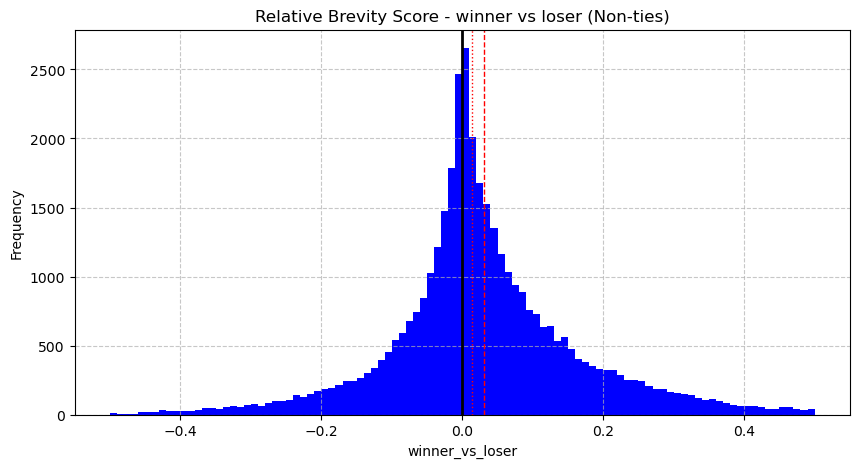

Average Relative Brevity Score (Model A wins): 0.0332


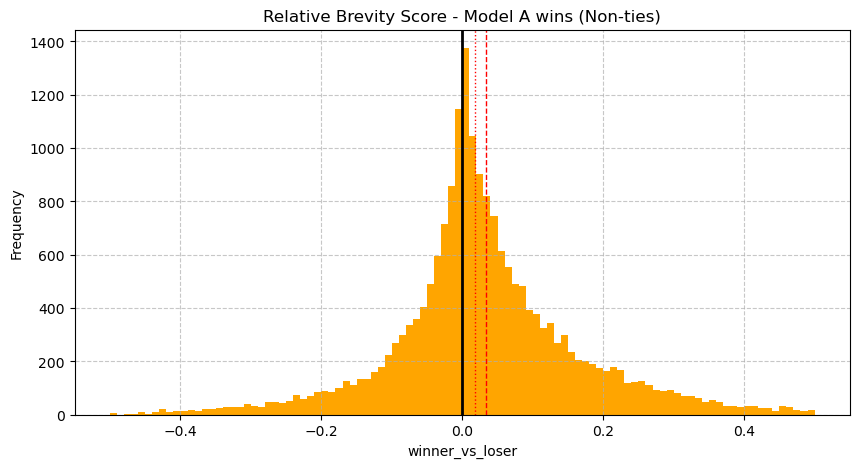

Average Relative Brevity Score (Model B wins): 0.0277


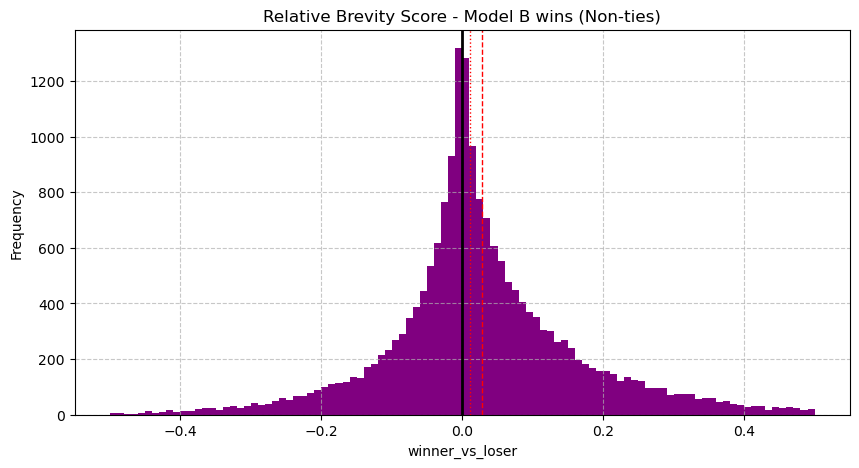

Average Relative Brevity Score (ties): -0.0032


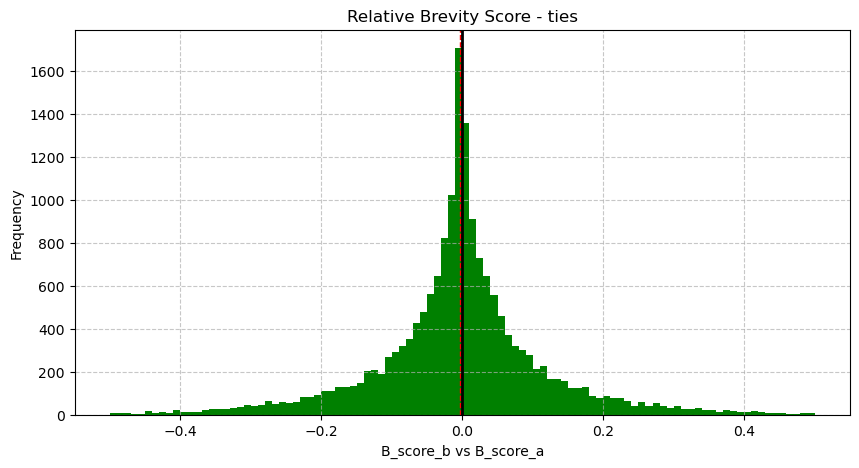

In [89]:
hist_feature_diff(df, 'B_score_a', 'B_score_b', "Relative Brevity Score", range_min=-0.5, range_max=0.5, nbins=100)

### Hexbin plots for ⌛ Brevity Score

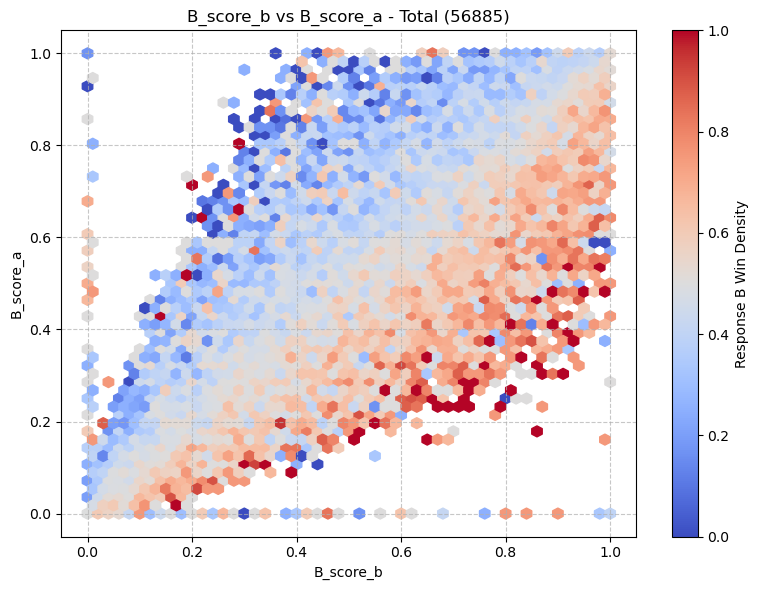

In [90]:
resolution = 50
plot_hexbin(df, 'B_score_a', 'B_score_b', title=f'Total ({df.shape[0]})', gridsize=resolution)

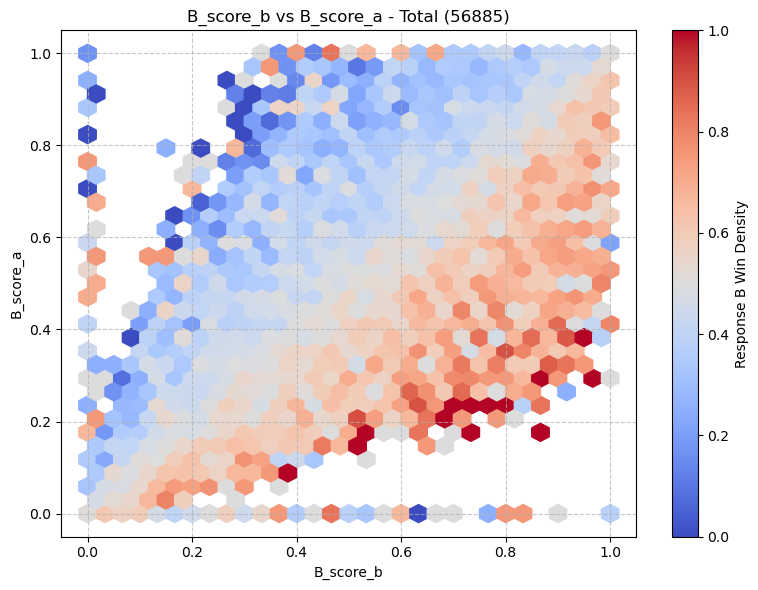

Regular questions (question-instruction). B scores are highly correlated with user choice:


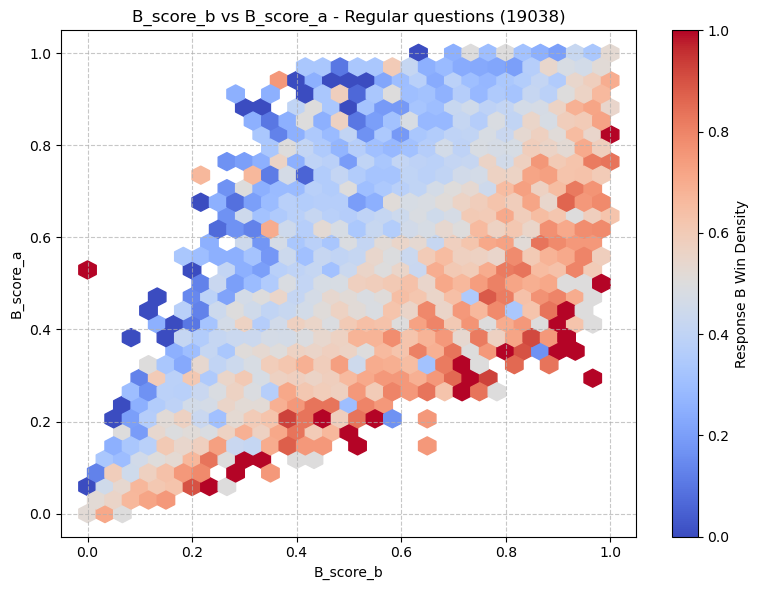

Trick questions (question-problem). B scores are mildly correlated with user choice, specially in the extremes


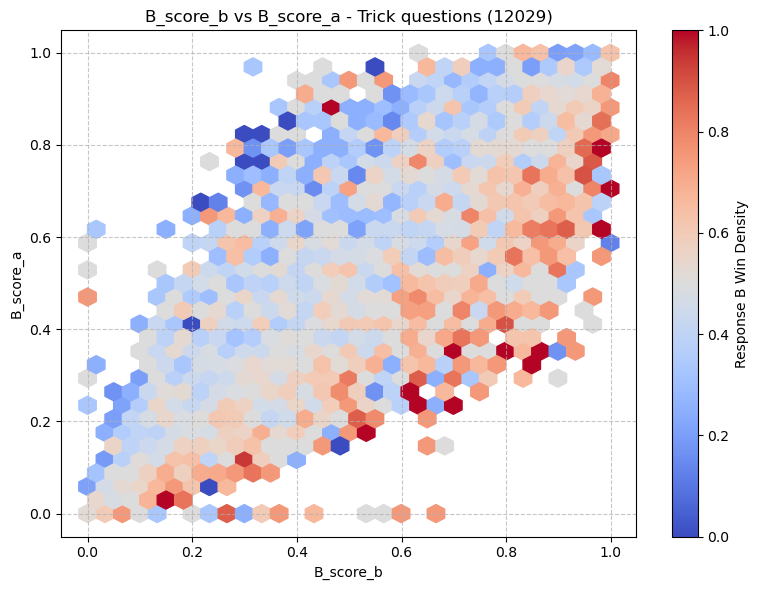

Regular requests (request-instruction). B scores have the higher predictive value in the extremes:


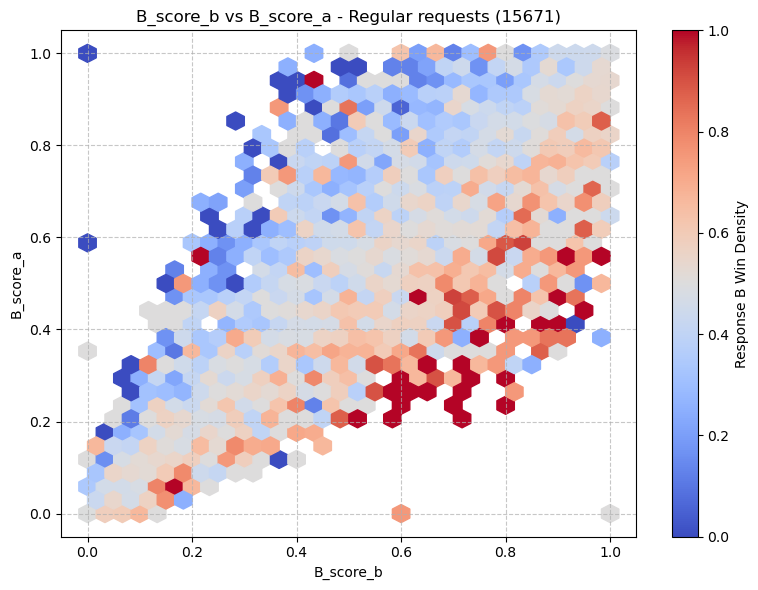

Problem-solving requests (request-problem). B scores have the lowest predictive value for this category of prompts:


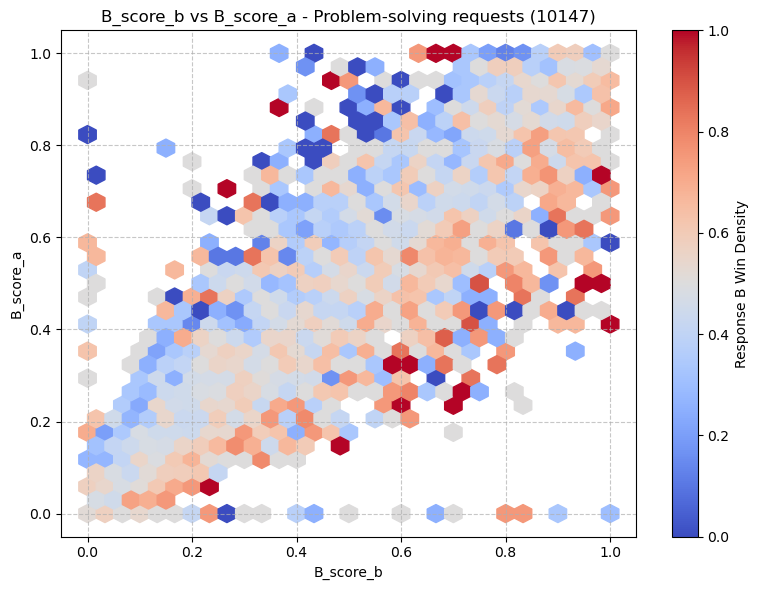

In [91]:
resolution = 30
plot_hexbin(df, 'B_score_a', 'B_score_b', title=f'Total ({df.shape[0]})', gridsize=resolution)

print('Regular questions (question-instruction). B scores are highly correlated with user choice:')
df_qi = df[(df['label_rq'] == 'question') & (df['label_tl'] == 'instruction')]
plot_hexbin(df_qi, 'B_score_a', 'B_score_b', title=f'Regular questions ({df_qi.shape[0]})', gridsize=resolution)

print('Trick questions (question-problem). B scores are mildly correlated with user choice, specially in the extremes')
df_qp = df[(df['label_rq'] == 'question') & (df['label_tl'] == 'problem')]
plot_hexbin(df_qp, 'B_score_a', 'B_score_b', title=f'Trick questions ({df_qp.shape[0]})', gridsize=resolution)

print('Regular requests (request-instruction). B scores have the higher predictive value in the extremes:')
df_ri = df[(df['label_rq'] == 'request') & (df['label_tl'] == 'instruction')]
plot_hexbin(df_ri, 'B_score_a', 'B_score_b', title=f'Regular requests ({df_ri.shape[0]})', gridsize=resolution)

print('Problem-solving requests (request-problem). B scores have the lowest predictive value for this category of prompts:')
df_rp = df[(df['label_rq'] == 'request') & (df['label_tl'] == 'problem')]
plot_hexbin(df_rp, 'B_score_a', 'B_score_b', title=f'Problem-solving requests ({df_rp.shape[0]})', gridsize=resolution)

### 🎯🧩⌛💡 SCBN Scores

In [92]:
df['SCBN_score_a'] = df['S_score_a'] + df['C_score_a'] + df['B_score_a'] + df['N_score_a']
df['SCBN_score_b'] = df['S_score_b'] + df['C_score_b'] + df['B_score_b'] + df['N_score_b']
print(df.shape)

(56885, 58)


Test data:

In [93]:
test_df['SCBN_score_a'] = test_df['S_score_a'] + test_df['C_score_a'] + test_df['B_score_a'] + test_df['N_score_a']
test_df['SCBN_score_b'] = test_df['S_score_b'] + test_df['C_score_b'] + test_df['B_score_b'] + test_df['N_score_b']
display(test_df)

id                                             prompt  \
0   136060  I have three oranges today, I ate an orange ye...   
1   211333  You are a mediator in a heated political debat...   
2  1233961  How to initialize the classification head when...   

                                          response_a  \
0                        You have two oranges today.   
1  Thank you for sharing the details of the situa...   
2  When you want to initialize the classification...   

                                          response_b  encode_fail  \
0  You still have three oranges. Eating an orange...        False   
1  Mr Reddy and Ms Blue both have valid points in...        False   
2  To initialize the classification head when per...        False   

                                             options  \
0  [Prompt: I have three oranges today, I ate an ...   
1  [Prompt: You are a mediator in a heated politi...   
2  [Prompt: How to initialize the classification ...   

                                      trimmed_prompt  label_rq   prob_rq  \
0  i have three oranges today, i ate an orange ye...  question  0.931602   
1  you are a mediator in a heated political debat...   request  0.807346   
2  how to initialize the classification head when...  question  0.758176   

     r_vs_q  ...   p_tc  ra_tc  rb_tc  p_chtk_ratio  ra_chtk_ratio  \
0  0.068398  ...   23.0    9.0   25.0      3.902903       3.851641   
1  0.807346  ...  105.0  246.0   89.0      4.698573       5.921888   
2  0.241824  ...   43.0  368.0  512.0      4.437942       4.994399   

   rb_chtk_ratio  B_score_a  B_score_b  SCBN_score_a  SCBN_score_b  
0       4.780530        0.5        0.5      2.500000      2.933203  
1       5.240777        0.0        0.0      1.273098      0.991468  
2       4.158742        1.0        1.0      2.000000      2.000000  

[3 rows x 49 columns]

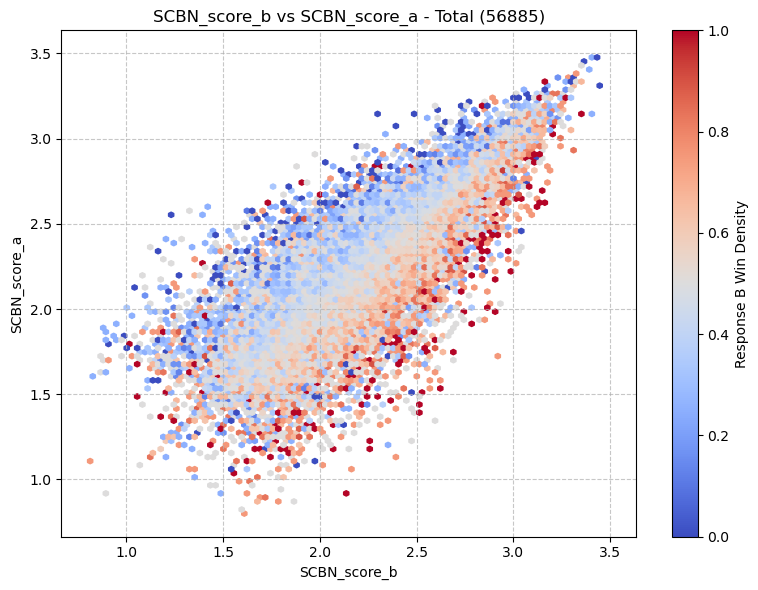

Regular questions (question-instruction). SCBN scores are highly correlated with user choice:


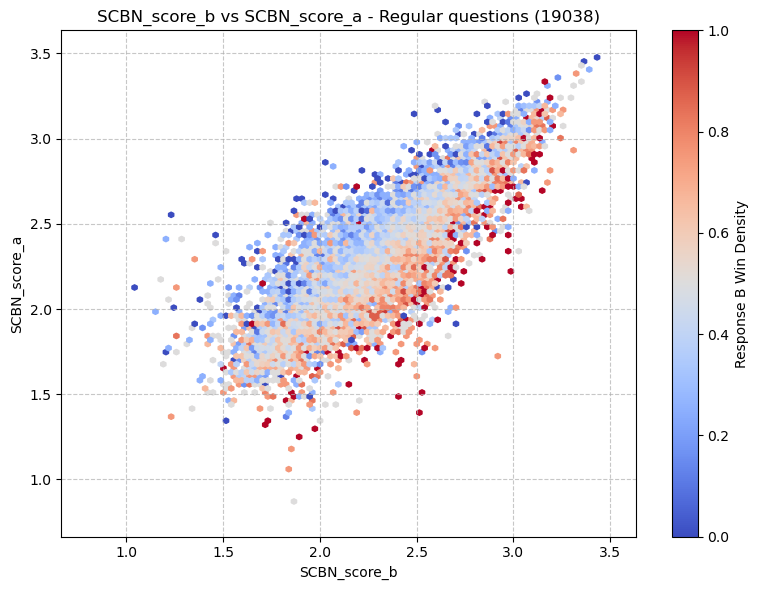

Trick questions (question-problem). SCBN scores are mildly correlated with user choice. 
S & C stronger in mid-range. B stronger in extremes:


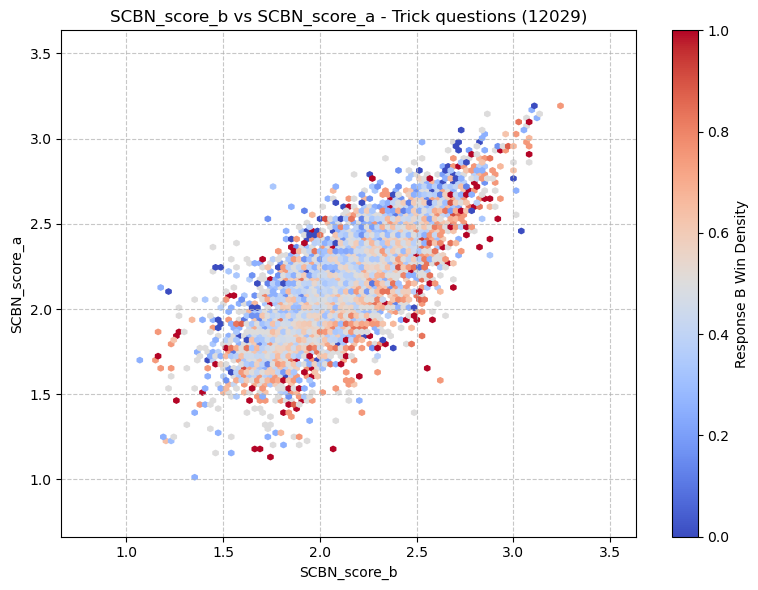

Regular requests (request-instruction). SCBN scores are mildly correlated with user choice.
N stronger in low-range, C mid-range, B extremes:


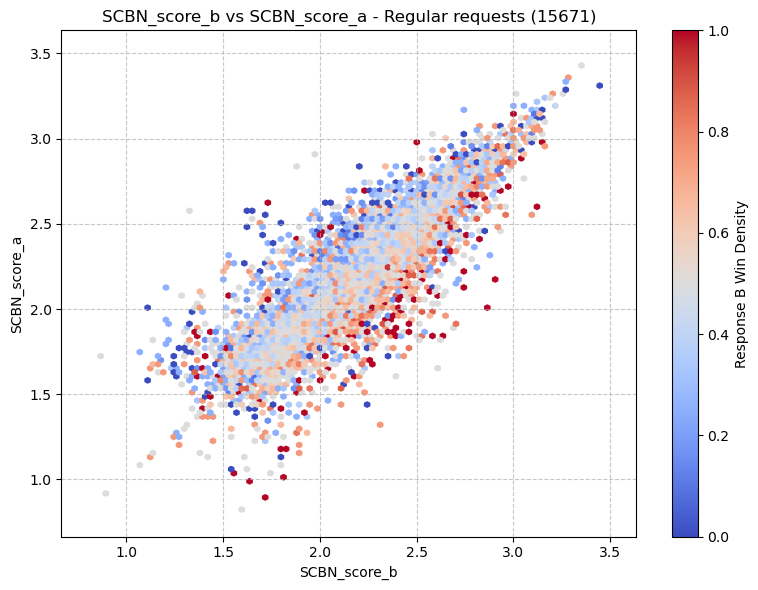

Problem-solving requests (request-problem). SCBN scores have the lowest predictive value.
S scores might be more significant than CBN:


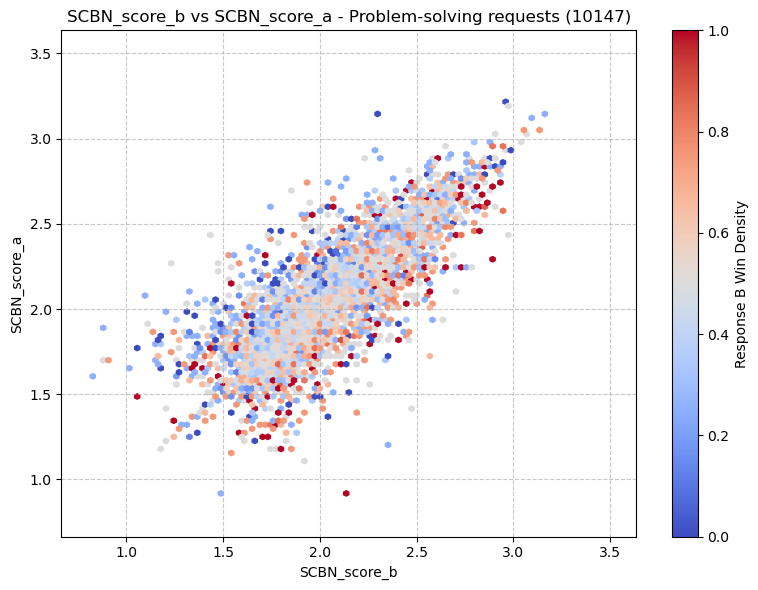

In [94]:
resolution = 100
plot_hexbin(df, 'SCBN_score_a', 'SCBN_score_b', title=f'Total ({df.shape[0]})', gridsize=resolution, range_min = 0.8, range_max = 3.5)

print('Regular questions (question-instruction). SCBN scores are highly correlated with user choice:')
df_qi = df[(df['label_rq'] == 'question') & (df['label_tl'] == 'instruction')]
plot_hexbin(df_qi, 'SCBN_score_a', 'SCBN_score_b', title=f'Regular questions ({df_qi.shape[0]})', gridsize=resolution, range_min = 0.8, range_max = 3.5)

print('Trick questions (question-problem). SCBN scores are mildly correlated with user choice. \nS & C stronger in mid-range. B stronger in extremes:')
df_qp = df[(df['label_rq'] == 'question') & (df['label_tl'] == 'problem')]
plot_hexbin(df_qp, 'SCBN_score_a', 'SCBN_score_b', title=f'Trick questions ({df_qp.shape[0]})', gridsize=resolution, range_min = 0.8, range_max = 3.5)

print('Regular requests (request-instruction). SCBN scores are mildly correlated with user choice.\nN stronger in low-range, C mid-range, B extremes:')
df_ri = df[(df['label_rq'] == 'request') & (df['label_tl'] == 'instruction')]
plot_hexbin(df_ri, 'SCBN_score_a', 'SCBN_score_b', title=f'Regular requests ({df_ri.shape[0]})', gridsize=resolution, range_min = 0.8, range_max = 3.5)

print('Problem-solving requests (request-problem). SCBN scores have the lowest predictive value.\nS scores might be more significant than CBN:')
df_rp = df[(df['label_rq'] == 'request') & (df['label_tl'] == 'problem')]
plot_hexbin(df_rp, 'SCBN_score_a', 'SCBN_score_b', title=f'Problem-solving requests ({df_rp.shape[0]})', gridsize=resolution, range_min = 0.8, range_max = 3.5)

In [131]:
if not sampled:
    df.to_pickle('df_features.pkl')
    test_df.to_pickle('test_df.pkl')

# 9. 📊 PCA and SCBN scores evaluation

In [9]:
if preload_data:
    df = pd.read_pickle(f'{BASE_PATH}df_features.pkl')
    test_df = pd.read_pickle(f'{BASE_PATH}test_df.pkl')
if not sampled and not preload_data:
    df = pd.read_pickle('df_features.pkl')
    test_df = pd.read_pickle('test_df.pkl')

print(df.shape)
print(df.columns)

(56885, 58)
Index(['id', 'model_a', 'model_b', 'prompt', 'response_a', 'response_b',
       'winner_model_a', 'winner_model_b', 'winner_tie', 'class_name',
       'class_label', 'encode_fail', 'options', 'trimmed_prompt', 'label_rq',
       'prob_rq', 'r_vs_q', 'r_vs_q_u', 'label_tl', 'prob_tl', 't_vs_l',
       't_vs_l_u', 'tfidf_prompt', 'tfidf_ra', 'tfidf_rb', 'N_score_a',
       'N_score_b', 'winner_vs_loser', 'pol_p', 'pol_ra', 'pol_rb',
       'rel_pol_ra', 'rel_pol_rb', 'subj_p', 'subj_ra', 'subj_rb',
       'rel_subj_ra', 'rel_subj_rb', 'S_score_a', 'S_score_b', 'C_score_a',
       'C_score_b', 'S_rel', 'C_rel', 'N_rel', 'p_len', 'ra_len', 'rb_len',
       'p_tc', 'ra_tc', 'rb_tc', 'p_chtk_ratio', 'ra_chtk_ratio',
       'rb_chtk_ratio', 'B_score_a', 'B_score_b', 'SCBN_score_a',
       'SCBN_score_b'],
      dtype='object')


In [10]:
# Separate features and target
X = df[['r_vs_q', 't_vs_l', 'tfidf_prompt', 'tfidf_ra', 'tfidf_rb', 
        'rel_pol_ra', 'rel_pol_rb', 'rel_subj_ra', 'rel_subj_rb', 'S_score_a',
        'S_score_b', 'C_score_a', 'C_score_b', 'B_score_a', 'B_score_b', 'N_score_a', 'N_score_b', 
        'SCBN_score_a', 'SCBN_score_b', 'p_len', 'ra_len', 'rb_len', 'p_tc', 'ra_tc', 'rb_tc',
       'p_chtk_ratio', 'ra_chtk_ratio', 'rb_chtk_ratio']] # 'r_vs_q_u'
y = df['class_label']

# Handle NaN values by imputing
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Standardize the features
scaler = StandardScaler()
X_std = scaler.fit_transform(X_imputed)

# Perform PCA
pca = PCA(n_components=3)  # You can adjust the number of components based on your requirement
principal_components = pca.fit_transform(X_std)

# Create a DataFrame with the principal components
df_pca = pd.DataFrame(data=principal_components, columns=['principal_component_1', 'principal_component_2', 'principal_component_3'])
df_pca['class_label'] = y.values

# Output feature influence
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
feature_influence = pd.DataFrame(loadings, columns=['PC1', 'PC2', 'PC3'], index=X.columns)

# Add column with the average of the absolute values of the principal components scores for each feature
feature_influence['average_abs_loading'] = feature_influence.apply(lambda row: np.mean(np.abs(row)), axis=1)
# feature_influence.sort_values(by="average_abs_loading", ascending=False)

feature_influence = feature_influence.sort_values(by="average_abs_loading", ascending=False)
print("Feature influence on the principal components with average absolute loading:")
print(feature_influence.sort_values(by="average_abs_loading", ascending=False))
print(feature_influence.index[:4])

Feature influence on the principal components with average absolute loading:
                    PC1       PC2       PC3  average_abs_loading
SCBN_score_b   0.649622  0.548354 -0.355742             0.517906
SCBN_score_a   0.653371  0.543736 -0.353480             0.516862
rel_subj_ra    0.526681 -0.552163  0.370410             0.483084
rel_subj_rb    0.527154 -0.554448  0.364066             0.481890
tfidf_prompt   0.707696 -0.268727 -0.447636             0.474687
ra_tc          0.258895  0.554420  0.574973             0.462763
rb_tc          0.258152  0.554011  0.573618             0.461927
ra_len         0.234564  0.556357  0.571353             0.454091
rb_len         0.229233  0.550416  0.569765             0.449805
S_score_a     -0.406052  0.698949 -0.231689             0.445563
S_score_b     -0.403918  0.701851 -0.229665             0.445145
C_score_b     -0.172143  0.648339 -0.461503             0.427328
C_score_a     -0.171018  0.646523 -0.460922             0.426154
p_tc         

# 🌱 Linear Decision Tree Model (first approximation and feature calibration)

With the calculated metrics, it's fairly easy to achieve higher than 40% accuracy on out-of-sample data with a decision tree classifier. Given that there are three fairly compensated classes, a "coin toss" approach would achieve 33.3% accuracy. This further proves the RQTL features and SCBN metrics are a good starting point to refine and incorporate to models that may add other additional approaches such as embeddings, vectorization of the prompt-responses sequences, LLM as judges, etc. In my opinion, all approaches that involve the use of LLMs for inference and classification beyond a simple theoretical scope such as the one used in this notebook might be good for achieving high scores on the Kaggle competition, but lack a practical purpose, considering the size of this competition's dataset is orders of magnitude smaller than that of any LLM, and considering the high cost (in processiong time) of inferences on a dataset like this. 

In [97]:
print(len(feature_influence.index))

28


In [98]:
feature_influence.index

Index(['SCBN_score_b', 'SCBN_score_a', 'rel_subj_ra', 'rel_subj_rb',
       'tfidf_prompt', 'ra_tc', 'rb_tc', 'ra_len', 'rb_len', 'S_score_a',
       'S_score_b', 'C_score_b', 'C_score_a', 'p_tc', 'tfidf_rb', 'tfidf_ra',
       'B_score_b', 'B_score_a', 'p_len', 'N_score_b', 'N_score_a',
       'rel_pol_rb', 'rel_pol_ra', 'p_chtk_ratio', 't_vs_l', 'r_vs_q',
       'ra_chtk_ratio', 'rb_chtk_ratio'],
      dtype='object')

In [99]:
def dtree_class(features, target, max_depth, min_samples_leaf=2, test_size=0.3, print_stats=True):
    X_train, X_test, y_train, y_test = train_test_split(features, target, 
                                                        test_size=test_size, 
                                                        stratify = target,
                                                        random_state=39)

    dTree = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf = min_samples_leaf)
    dTree.fit(X_train, y_train)
    X_train_predictions = dTree.predict(X_train)
    X_test_predictions = dTree.predict(X_test)

    if print_stats:
        print("Train Metrics:")
        print(classification_report(y_train, X_train_predictions))
        print("Test Metrics:")
        print(classification_report(y_test, X_test_predictions))

    return dTree

features_list = feature_influence.index[:25].to_list()
features = df[features_list].fillna(0)
target = df['class_name']

dTree_3 = dtree_class(features, target, 10, 2, 0.2)

Train Metrics:
                precision    recall  f1-score   support

winner_model_a       0.51      0.58      0.54     15886
winner_model_b       0.54      0.50      0.52     15536
    winner_tie       0.48      0.44      0.46     14086

      accuracy                           0.51     45508
     macro avg       0.51      0.51      0.51     45508
  weighted avg       0.51      0.51      0.51     45508

Test Metrics:
                precision    recall  f1-score   support

winner_model_a       0.43      0.49      0.46      3971
winner_model_b       0.45      0.42      0.43      3884
    winner_tie       0.38      0.35      0.36      3522

      accuracy                           0.42     11377
     macro avg       0.42      0.42      0.42     11377
  weighted avg       0.42      0.42      0.42     11377



For illustrative purposes, we can calculate the probabilities on the competition test file. An obvious approach for the competition would involve "fine-tuning" this notebook, the metrics and the trained models aiming at producing "reasonable" results for these particular cases (some of them are quite obvious to a human, such as the "trick question" about the oranges), but this notebook is not focused on competition scores.  

In [100]:
test_features = test_df[features_list].fillna(0)
# Get probabilities for all classes
probabilities_dtree = dTree_3.predict_proba(test_features)
# Create a dictionary to store probabilities for each class
class_probabilities = {}
# Extract probabilities for each class
for i, class_name in enumerate(dTree_3.classes_):
    class_probabilities[class_name] = probabilities_dtree[:, i]
# Now you can access probabilities for each class
prob_winner_model_a = class_probabilities['winner_model_a']
prob_winner_model_b = class_probabilities['winner_model_b']
prob_winner_tie = class_probabilities['winner_tie']
test_df['prob_winner_model_a'] = prob_winner_model_a
test_df['prob_winner_model_b'] = prob_winner_model_b
test_df['prob_winner_tie'] = prob_winner_tie
display(test_df[['id', 'prompt', 'response_a', 'response_b',
       'prob_winner_model_a', 'prob_winner_model_b', 'prob_winner_tie']])

id                                             prompt  \
0   136060  I have three oranges today, I ate an orange ye...   
1   211333  You are a mediator in a heated political debat...   
2  1233961  How to initialize the classification head when...   

                                          response_a  \
0                        You have two oranges today.   
1  Thank you for sharing the details of the situa...   
2  When you want to initialize the classification...   

                                          response_b  prob_winner_model_a  \
0  You still have three oranges. Eating an orange...             0.531746   
1  Mr Reddy and Ms Blue both have valid points in...             0.452830   
2  To initialize the classification head when per...             0.000000   

   prob_winner_model_b  prob_winner_tie  
0             0.206349         0.261905  
1             0.251572         0.295597  
2             1.000000         0.000000

# Logistic regression

In [101]:
def train_logistic_regression(features, target, test_size=0.2, max_iter=100, solver='lbfgs', print_stats=True):
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=test_size,
                                                        stratify = target, random_state=42)

    log_reg = LogisticRegression(max_iter=max_iter, solver=solver)
    log_reg.fit(X_train, y_train)
    X_train_predictions = log_reg.predict(X_train)
    X_test_predictions = log_reg.predict(X_test)

    if print_stats:
        print("Train Metrics:")
        print(classification_report(y_train, X_train_predictions, target_names=log_reg.classes_, zero_division=0))
        print("Test Metrics:")
        print(classification_report(y_test, X_test_predictions, target_names=log_reg.classes_, zero_division=0))

    return log_reg

Training:

In [102]:
features_list = feature_influence.index[:25].to_list()
features = df[features_list].fillna(0)
target = df['class_name']
log_reg_model = train_logistic_regression(features, target, 0.3, 1000, 'lbfgs')

Train Metrics:
                precision    recall  f1-score   support

winner_model_a       0.45      0.55      0.49     13900
winner_model_b       0.45      0.50      0.48     13594
    winner_tie       0.41      0.25      0.31     12325

      accuracy                           0.44     39819
     macro avg       0.44      0.43      0.43     39819
  weighted avg       0.44      0.44      0.43     39819

Test Metrics:
                precision    recall  f1-score   support

winner_model_a       0.45      0.55      0.50      5957
winner_model_b       0.46      0.50      0.48      5826
    winner_tie       0.40      0.25      0.31      5283

      accuracy                           0.44     17066
     macro avg       0.44      0.44      0.43     17066
  weighted avg       0.44      0.44      0.43     17066



Predictions:

In [103]:
test_features = test_df[features_list].fillna(0)
probabilities_lr = log_reg_model.predict_proba(test_features)
# Create a dictionary to store probabilities for each class
class_probabilities = {}
# Extract probabilities for each class
for i, class_name in enumerate(log_reg_model.classes_):
    class_probabilities[class_name] = probabilities_lr[:, i]
# Now we can access probabilities for each class
prob_winner_model_a = class_probabilities['winner_model_a']
prob_winner_model_b = class_probabilities['winner_model_b']
prob_winner_tie = class_probabilities['winner_tie']
test_df['prob_winner_model_a'] = prob_winner_model_a
test_df['prob_winner_model_b'] = prob_winner_model_b
test_df['prob_winner_tie'] = prob_winner_tie
display(test_df[['id', 'prompt', 'response_a', 'response_b',
       'prob_winner_model_a', 'prob_winner_model_b', 'prob_winner_tie']])

id                                             prompt  \
0   136060  I have three oranges today, I ate an orange ye...   
1   211333  You are a mediator in a heated political debat...   
2  1233961  How to initialize the classification head when...   

                                          response_a  \
0                        You have two oranges today.   
1  Thank you for sharing the details of the situa...   
2  When you want to initialize the classification...   

                                          response_b  prob_winner_model_a  \
0  You still have three oranges. Eating an orange...             0.276824   
1  Mr Reddy and Ms Blue both have valid points in...             0.442817   
2  To initialize the classification head when per...             0.314952   

   prob_winner_model_b  prob_winner_tie  
0             0.313589         0.409587  
1             0.199914         0.357269  
2             0.450846         0.234202

# 🧠 Neural Network

The acuracy metrics are similar if we train a small neural network. It's expected that the neural network does not add value if we are only using numerical metrics. This model will be potentially be more useful if we add embeddings for the full data set or other non-numeric features obtained from LLMs or some other model we might use to enrich the dataset.

In [104]:
features_list = feature_influence.index[:25].to_list()
target_feature = ['class_label']
print(features_list)

['SCBN_score_b', 'SCBN_score_a', 'rel_subj_ra', 'rel_subj_rb', 'tfidf_prompt', 'ra_tc', 'rb_tc', 'ra_len', 'rb_len', 'S_score_a', 'S_score_b', 'C_score_b', 'C_score_a', 'p_tc', 'tfidf_rb', 'tfidf_ra', 'B_score_b', 'B_score_a', 'p_len', 'N_score_b', 'N_score_a', 'rel_pol_rb', 'rel_pol_ra', 'p_chtk_ratio', 't_vs_l']


In [105]:
df.fillna(0, inplace=True)
train_df, valid_df = train_test_split(df, test_size=0.3, stratify=df["class_label"], random_state=37)
print('train_df', train_df.shape)
print('valid_df', valid_df.shape)
X_train = train_df[features_list]
y_train = train_df[target_feature]
X_test = valid_df[features_list]
y_test = valid_df[target_feature]
print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

train_df (39819, 58)
valid_df (17066, 58)
X_train (39819, 25)
y_train (39819, 1)
X_test (17066, 25)
y_test (17066, 1)


In [106]:
# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train.values.ravel())
y_test_encoded = label_encoder.transform(y_test.values.ravel())

In [107]:
def configura_modelo(X_train, nn_oculta, nn_oculta2, l1reg=0, l2reg=0, dropout=None, act_1='relu', act_2='relu', act_output='softmax'):
    n_metricas = X_train.shape[1]
    inputs = keras.Input(shape=(n_metricas,), name="input")
    x = keras.layers.Dense(nn_oculta, activation = act_1,
                           kernel_regularizer=keras.regularizers.l1_l2(l1=l1reg, l2=l2reg), name="oculta")(inputs)
    if dropout: x = keras.layers.Dropout(dropout)(x)
    x = keras.layers.Dense(nn_oculta2, activation = act_2,
                           kernel_regularizer=keras.regularizers.l1_l2(l1=l1reg, l2=l2reg), name="oculta2")(x)
    outputs = keras.layers.Dense(3, activation=act_output, name="output")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

model = configura_modelo(X_train_scaled, 50, 50)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 25)]              0         
                                                                 
 oculta (Dense)              (None, 50)                1300      
                                                                 
 oculta2 (Dense)             (None, 50)                2550      
                                                                 
 output (Dense)              (None, 3)                 153       
                                                                 
Total params: 4003 (15.64 KB)
Trainable params: 4003 (15.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [108]:
def entrenamiento(model, X_train, y_train, X_test, y_test, nepochs=100, bsize=20, optimizer_name='adam', lr=0.001, callbacks = None):
    if optimizer_name is not None:
        optimizer = keras.optimizers.get(optimizer_name)
        optimizer.learning_rate = lr
    else:
        optimizer = keras.optimizers.SGD(learning_rate=lr)

    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy', #
                  metrics=['acc'])

    history = model.fit(X_train,
                        y_train,
                        epochs=nepochs,
                        batch_size=bsize,
                        validation_data=(X_test, y_test),
                        callbacks = callbacks)
    return history

def plot_metrics(history, nepochs):
    hd = history.history
    epochs = range(1, nepochs+1)
    plt.figure(figsize=(12,3))
    plt.subplot(1,2,1)
    plt.plot(epochs, hd['acc'], "r", label="train")
    plt.plot(epochs, hd['val_acc'], "b", label="test")
    plt.grid(True)
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.title("Accuracy")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs, hd['loss'], "r", label="train")
    plt.plot(epochs, hd['val_loss'], "b", label="test")
    plt.grid(True)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title("Loss (sparse categorical crossentropy)")
    plt.legend()
    plt.show()


Epoch 1/8


1991/1991 [==============================] - 3s 1ms/step - loss: 1.2102 - acc: 0.4358 - val_loss: 1.1364 - val_acc: 0.4460
Epoch 2/8
1991/1991 [==============================] - 2s 999us/step - loss: 1.1038 - acc: 0.4417 - val_loss: 1.0845 - val_acc: 0.4435
Epoch 3/8
1991/1991 [==============================] - 2s 972us/step - loss: 1.0741 - acc: 0.4457 - val_loss: 1.0698 - val_acc: 0.4439
Epoch 4/8
1991/1991 [==============================] - 2s 963us/step - loss: 1.0671 - acc: 0.4469 - val_loss: 1.0656 - val_acc: 0.4436
Epoch 5/8
1991/1991 [==============================] - 2s 970us/step - loss: 1.0636 - acc: 0.4460 - val_loss: 1.0623 - val_acc: 0.4474
Epoch 6/8
1991/1991 [==============================] - 2s 963us/step - loss: 1.0618 - acc: 0.4472 - val_loss: 1.0617 - val_acc: 0.4449
Epoch 7/8
1991/1991 [==============================] - 2s 974us/step - loss: 1.0613 - acc: 0.4475 - val_loss: 1.0619 - val_acc: 0.4454
Epoch 8/8
534/534 [==============================] - 0

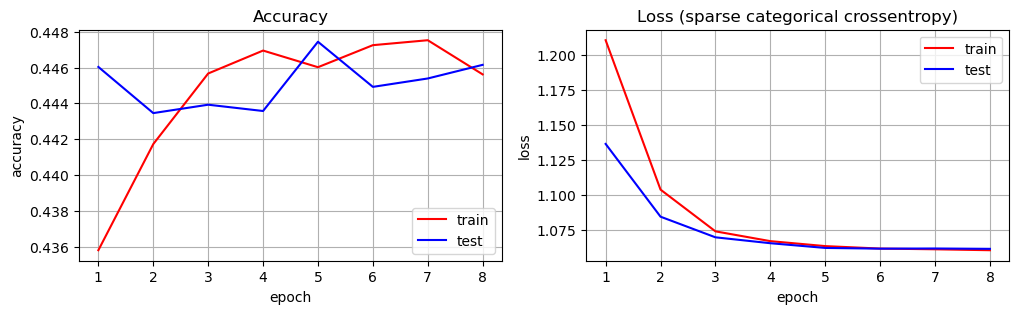

Features: 25


In [109]:
nepochs= 8
bsize = 20
lr = 0.0001
# reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, min_delta=0.1, min_lr=0.0001)
# early_stopping = EarlyStopping(monitor='loss', patience=6, min_delta=0.01, restore_best_weights=True)
optimizer_name= 'adam'
# model = configura_modelo(X_train, 30, 30, 'gelu', 'relu', 'softmax')
model = configura_modelo(X_train_scaled, 50, 50, l1reg=0.0005, l2reg=0, dropout=0.001)
history = entrenamiento (model, X_train_scaled, y_train_encoded, X_test_scaled, y_test_encoded, 
                         nepochs, bsize, optimizer_name, callbacks=None)
loss_test, acc_test = model.evaluate(X_test_scaled, y_test_encoded)
print("Val. Loss: %f" % (loss_test))
print("Val. Accuracy: %f" % (acc_test))
plot_metrics(history, nepochs)
print(f'Features: {X_train_scaled.shape[1]}')

In [110]:
test_features = test_df[features_list].fillna(0)
probabilities_nn = model.predict(test_features)
class_probabilities = {}
class_names = ['winner_model_a', 'winner_model_b', 'winner_tie']
for i, class_name in enumerate(class_names):
    class_probabilities[class_name] = probabilities_nn[:, i]

prob_winner_model_a = class_probabilities['winner_model_a']
prob_winner_model_b = class_probabilities['winner_model_b']
prob_winner_tie = class_probabilities['winner_tie']

test_df['prob_winner_model_a'] = prob_winner_model_a
test_df['prob_winner_model_b'] = prob_winner_model_b
test_df['prob_winner_tie'] = prob_winner_tie

pd.options.display.float_format = '{:.3f}'.format
display(test_df[['id', 'prompt', 'response_a', 'response_b',
                 'prob_winner_model_a', 'prob_winner_model_b', 'prob_winner_tie']])
pd.reset_option('display.float_format')

1/1 [==============================] - 0s 57ms/step


id                                             prompt  \
0   136060  I have three oranges today, I ate an orange ye...   
1   211333  You are a mediator in a heated political debat...   
2  1233961  How to initialize the classification head when...   

                                          response_a  \
0                        You have two oranges today.   
1  Thank you for sharing the details of the situa...   
2  When you want to initialize the classification...   

                                          response_b  prob_winner_model_a  \
0  You still have three oranges. Eating an orange...                0.000   
1  Mr Reddy and Ms Blue both have valid points in...                1.000   
2  To initialize the classification head when per...                0.000   

   prob_winner_model_b  prob_winner_tie  
0                1.000            0.000  
1                0.000            0.000  
2                1.000            0.000

# 📬 | Kaggle Submission

In [111]:
CFG.class_names

['winner_model_a', 'winner_model_b', 'winner_tie']

In [112]:
np.set_printoptions(suppress=True, formatter={'float': lambda x: "{:.2f}".format(x)})
print(f"Probabilities calculated with decision tree:\n{probabilities_dtree}")
print(f"Probabilities calculated with logistic regression:\n{probabilities_lr}")
print(f"Probabilities calculated with neural network:\n{probabilities_nn}")
np.set_printoptions(suppress=False, formatter=None) # reset the options back to default

Probabilities calculated with decision tree:
[[0.53 0.21 0.26]
 [0.45 0.25 0.30]
 [0.00 1.00 0.00]]
Probabilities calculated with logistic regression:
[[0.28 0.31 0.41]
 [0.44 0.20 0.36]
 [0.31 0.45 0.23]]
Probabilities calculated with neural network:
[[0.00 1.00 0.00]
 [1.00 0.00 0.00]
 [0.00 1.00 0.00]]


In [113]:
sub_df = test_df[["id"]].copy()
sub_df[CFG.class_names] = probabilities_nn.tolist()
sub_df.to_csv("submission.csv", index=False)
print("SUMBISSION:")
print(sub_df)

SUMBISSION:
        id  winner_model_a  winner_model_b    winner_tie
0   136060    9.606522e-10             1.0  1.953507e-11
1   211333    1.000000e+00             0.0  0.000000e+00
2  1233961    0.000000e+00             1.0  0.000000e+00
